<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/tabular%20learner%20training%20instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [64]:
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import fastbook
fastbook.setup_book()

In [66]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from collections import Counter
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data with SMILES 1
Everything that includes the SMILES code goes with _sm and if it does not in only contains the same features that we have been using for all the time: cl name, drug compound and monotherapy features.

In [ ]:
path = "/content/gdrive/MyDrive/archivos_tfm/smiles/dataset_selected_comb_smiles.csv"
df_drug_comb = pd.read_csv(path, index_col = 0)


In [ ]:
df_drug_comb.head(10)

Cell line name Compound A Compound B  Max. conc. A  ...  Drug_B_FPT163  \
0          CAMA-1      AKT_1        AKT           1.0  ...              1   
1  MDA-MB-175-VII      AKT_1        AKT           1.0  ...              1   
2        UACC-812      AKT_1        AKT           1.0  ...              1   
3        BFTC-905      ATR_4        AKT           3.0  ...              1   
4         HT-1197      ATR_4        AKT           3.0  ...              1   
5         HT-1376      ATR_4        AKT           3.0  ...              1   
6             J82      ATR_4        AKT           3.0  ...              1   
7        KU-19-19      ATR_4        AKT           3.0  ...              1   
8           SW780      ATR_4        AKT           3.0  ...              1   
9            T-24      ATR_4        AKT           3.0  ...              1   

   Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
0              1              1              0  
1              1              1              0  
2              1              1              0  
3              1              1              0  
4              1              1              0  
5              1              1              0  
6              1              1              0  
7              1              1              0  
8              1              1              0  
9              1              1              0  

[10 rows x 350 columns]

In [ ]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B',
       ...
       'Drug_B_FPT157', 'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160',
       'Drug_B_FPT161', 'Drug_B_FPT162', 'Drug_B_FPT163', 'Drug_B_FPT164',
       'Drug_B_FPT165', 'Drug_B_FPT166'],
      dtype='object', length=350)

In [ ]:
print("Splits: ",df_drug_comb['Dataset'].unique())
print("Challenge: ",df_drug_comb['Challenge'].unique())

Splits:  ['train' 'LB' 'test']
Challenge:  ['ch1']


In this dataset we have a train/test/Leaderboard split. Also, all of our data refers to challege 1, so we can just drop that column later.

In [ ]:
# A little bit of data analysis
df_drug_comb.describe()

Max. conc. A  Max. conc. B       IC50 A          H A  ...  \
count   2726.000000   2726.000000  2726.000000  2726.000000  ...   
mean       1.597506      1.629094     0.699869     3.117006  ...   
std        1.343032      1.273368     0.790489     3.762770  ...   
min        0.010000      0.010000     0.000010     0.000000  ...   
25%        1.000000      1.000000     0.174651     0.638139  ...   
50%        1.000000      1.000000     0.383899     1.299871  ...   
75%        3.000000      3.000000     1.000000     3.532311  ...   
max       10.000000     10.000000    10.000000    10.000000  ...   

       Drug_B_FPT163  Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
count         2726.0    2726.000000         2726.0         2726.0  
mean             1.0       0.991563            1.0            0.0  
std              0.0       0.091483            0.0            0.0  
min              1.0       0.000000            1.0            0.0  
25%              1.0       1.000000            1.0            0.0  
50%              1.0       1.000000            1.0            0.0  
75%              1.0       1.000000            1.0            0.0  
max              1.0       1.000000            1.0            0.0  

[8 rows x 342 columns]

We will choose to train only in high quality data, meaning QA=1.

In [ ]:
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
print("Values of QA:", df_drug_comb["QA"].unique())

Values of QA: [1]


We drop QA, Combination ID and Challenge.

In [ ]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B',
       ...
       'Drug_B_FPT157', 'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160',
       'Drug_B_FPT161', 'Drug_B_FPT162', 'Drug_B_FPT163', 'Drug_B_FPT164',
       'Drug_B_FPT165', 'Drug_B_FPT166'],
      dtype='object', length=350)

In [ ]:
df_drug_comb.drop(['QA','Challenge', 'Drug_A_SMILES', 'Drug_B_SMILES'], axis = 1, inplace = True)

It gives a warning but it has succesfully dropped QA and Challenge columns from the DataFrame.

# Loading Data with SMILES 2 

In [ ]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B',
       ...
       'Drug_B_FPT157', 'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160',
       'Drug_B_FPT161', 'Drug_B_FPT162', 'Drug_B_FPT163', 'Drug_B_FPT164',
       'Drug_B_FPT165', 'Drug_B_FPT166'],
      dtype='object', length=346)

In [ ]:
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]


In [ ]:
# We shuffle the data
df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
df_drug_comb.head(10)

Cell line name     Compound A Compound B  Max. conc. A  ...  Drug_B_FPT163  \
0        HCC1937    BCL2_BCL2L1      ATR_4           1.0  ...              1   
1        CAL-120        MAP2K_1      ATR_4           1.0  ...              1   
2     MDA-MB-453    BCL2_BCL2L1    AKT_SGK           1.0  ...              1   
3        DU-4475           FGFR       EGFR           1.0  ...              1   
4        HCC1806  PIK3CB_PIK3CD   ALK_IGFR           1.0  ...              1   
5         CAMA-1       ALK_IGFR     MTOR_1           1.0  ...              1   
6        DU-4475  PIK3CB_PIK3CD   ALK_IGFR           1.0  ...              1   
7        HCC1187           EGFR      AKT_1           0.1  ...              1   
8          647-V           ERBB        AKT           0.1  ...              1   
9         EVSA-T          PIK3C    MAP2K_3           3.0  ...              1   

   Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
0              1              1              0  
1              1              1              0  
2              1              1              0  
3              1              1              0  
4              1              1              0  
5              1              1              0  
6              1              1              0  
7              1              1              0  
8              1              1              0  
9              1              1              0  

[10 rows x 346 columns]

We create the train/test/LB splits and then create a copy of our dataset without the Combination ID. 
We want to retain the Combination ID because we use it for our Weighted Pearson metric.

In [ ]:
dataset_size = df_drug_comb.shape[0]
complete_list = np.arange(dataset_size, dtype = int)
mask_train = df_drug_comb["Dataset"]=="train"

train_idx = complete_list[mask_train]
test_idx = complete_list[~mask_train]
# For now we ignore the LB split

splits = (list(train_idx),list(test_idx))

df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)


In [ ]:
print("With Combination ID: ", df_drug_comb.columns)
print("Without Combination ID:", df_nocomb.columns )

With Combination ID:  Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B',
       ...
       'Drug_B_FPT157', 'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160',
       'Drug_B_FPT161', 'Drug_B_FPT162', 'Drug_B_FPT163', 'Drug_B_FPT164',
       'Drug_B_FPT165', 'Drug_B_FPT166'],
      dtype='object', length=345)
Without Combination ID: Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B',
       ...
       'Drug_B_FPT157', 'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160',
       'Drug_B_FPT161', 'Drug_B_FPT162', 'Drug_B_FPT163', 'Drug_B_FPT164',
       'Drug_B_FPT165', 'Drug_B_FPT166'],
      dtype='object', length=344)


In [ ]:
cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
to_sm = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to_sm.train),len(to_sm.valid)

(1662, 764)

In [ ]:
xs_sm,y_sm = to_sm.train.xs,to_sm.train.y
valid_xs_sm,valid_y_sm = to_sm.valid.xs,to_sm.valid.y
valid_xs_perm = pd.DataFrame()

test_df = df_drug_comb.iloc[test_idx]

In [ ]:
#valid_xs.to_csv("/content/gdrive/MyDrive/archivos_tfm/smiles/valid_xs")

# Loading data without SMILES
We want to load the same dataset, but we only preserve cell line names, drug names and monotherapy info.

In [67]:
df_no_sm = df_nocomb[['Cell line name', 
                      'Compound A', 'Compound B', 
                      'Max. conc. A', 'Max. conc. B', 
                      'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 
                      'Einf B', 'Synergy score']]
                     
cont , cat = cont_cat_split(df_no_sm, 1, dep_var=dep_var)
to = TabularPandas(df_no_sm, procs, cat, cont, y_names=dep_var, splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Loading data OR operation FP
We perform the binary operation OR to the Molecular FP vectors and use that as feature.
We add the suffix _bin that stands for binary.

In [ ]:
path = "/content/gdrive/MyDrive/archivos_tfm/smiles/dataset_selected_binary_fp.csv"
df_drug_bin = pd.read_csv(path, index_col = 0)
df_drug_bin = df_drug_bin[df_drug_bin["QA"] == 1]
print("Values of QA:", df_drug_bin["QA"].unique())
df_drug_bin.drop(['QA','Challenge'], axis = 1, inplace = True)
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]
# We shuffle the data
df_drug_bin = df_drug_bin.sample(frac=1).reset_index(drop=True)
df_drug_bin.head(10)
dep_var = "Synergy score"

Values of QA: [1]


In [ ]:
dataset_size = df_drug_bin.shape[0]
complete_list = np.arange(dataset_size, dtype = int)
mask_train = df_drug_bin["Dataset"]=="train"

train_idx = complete_list[mask_train]
test_idx = complete_list[~mask_train]
# For now we ignore the LB split

splits_bin = (list(train_idx),list(test_idx))

df_drug_bin.drop(['Dataset'], axis = 1, inplace = True)
df_bin_nocomb = df_drug_bin.drop(['Combination ID'], axis = 1)
cont,cat = cont_cat_split(df_bin_nocomb, 1, dep_var=dep_var)
to_bin = TabularPandas(df_bin_nocomb, procs, cat, cont, y_names=dep_var, splits=splits_bin)

xs_bin,y_bin = to_bin.train.xs,to_bin.train.y
valid_xs_bin,valid_y_bin = to_bin.valid.xs,to_bin.valid.y

test_df_bin = df_drug_bin.iloc[test_idx]


Cell line name Compound A   Compound B  Max. conc. A  ...  FPT163  \
0               J82      PIK3C       MTOR_1           3.0  ...       1   
2        MDA-MB-436   ALK_IGFR        AKT_1           1.0  ...       1   
6         NCI-H3122  Topotecan         BCL2           0.1  ...       1   
7           HCC1806   PIK3CA_4         ERBB           1.0  ...       1   
11         COLO-205    MAP2K_1         BCL2           1.0  ...       1   
...             ...        ...          ...           ...  ...     ...   
2418          HT-29    MAP2K_1         BCL2           3.0  ...       1   
2422         Calu-6     TOP2_2         PIM1           3.0  ...       1   
2423        HCC1143      PIK3C        AKT_1           1.0  ...       1   
2424       Hs-578-T       EGFR  BCL2_BCL2L1           0.1  ...       1   
2425         BT-549       FGFR      AKT_SGK           1.0  ...       1   

      FPT164  FPT165  FPT166  
0          1       1       0  
2          1       1       0  
6          1       1       0  
7          1       1       0  
11         1       1       0  
...      ...     ...     ...  
2418       1       1       0  
2422       1       1       0  
2423       1       1       0  
2424       1       1       0  
2425       1       1       0  

[764 rows x 179 columns]

# Understanding xs, ym valid_xs, valid_y

In [ ]:
xs.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Drug_A_FPT1',
       'Drug_A_FPT2', 'Drug_A_FPT3', 'Drug_A_FPT4', 'Drug_A_FPT5',
       'Drug_A_FPT6', 'Drug_A_FPT7',
       ...
       'Drug_B_FPT154', 'Drug_B_FPT155', 'Drug_B_FPT156', 'Drug_B_FPT157',
       'Drug_B_FPT158', 'Drug_B_FPT159', 'Drug_B_FPT160', 'Drug_B_FPT161',
       'Drug_B_FPT162', 'Drug_B_FPT164'],
      dtype='object', length=343)

In [ ]:
xs.head(10)

Cell line name  Compound A  Compound B  Drug_A_FPT1  ...  Drug_B_FPT160  \
1               35          13           1            1  ...              0   
3               12          19          13            1  ...              1   
4               41          22          14            1  ...              0   
5               12           9           3            1  ...              1   
8               16           4          25            1  ...              1   
9               49          22           5            1  ...              1   
10              17          27          24            1  ...              0   
12              50           1          15            1  ...              1   
13              23          15          22            1  ...              1   
14              33          19          13            1  ...              1   

    Drug_B_FPT161  Drug_B_FPT162  Drug_B_FPT164  
1               1              1              1  
3               1              1              1  
4               1              1              1  
5               1              1              1  
8               1              1              1  
9               1              1              1  
10              1              1              1  
12              1              1              1  
13              1              1              1  
14              1              1              1  

[10 rows x 343 columns]

It converts categorical variables into numerical ones. 

In [ ]:
to.classes["Compound A"]

['#na#', 'AKT', 'AKT_1', 'AKT_SGK', 'ALK', 'ALK_IGFR', 'ATM', 'ATR_4', 'BCL2', 'BCL2_BCL2L1', 'Doxorubicin', 'EGFR', 'EGFR_2', 'ERBB', 'FASN', 'FGFR', 'Gemcitabine', 'IGFR_4', 'JAK', 'MAP2K_1', 'MAP2K_3', 'MTOR', 'MTOR_1', 'Oxaliplatin', 'PARP1', 'PIK3C', 'PIK3CA_4', 'PIK3CB_PIK3CD', 'PIK3C_2', 'PIM1', 'PTK2', 'TKI', 'TOP2', 'TOP2_2', 'Topotecan']

In [ ]:
df_nocomb["Compound A"].unique()

array(['PIK3C', 'ERBB', 'ALK_IGFR', 'MAP2K_1', 'MTOR_1', 'BCL2_BCL2L1', 'Topotecan', 'PIK3CA_4', 'ALK', 'PIK3CB_PIK3CD', 'AKT', 'FGFR', 'EGFR_2', 'BCL2', 'AKT_1', 'AKT_SGK', 'TOP2_2', 'TOP2',
       'ATR_4', 'Doxorubicin', 'Gemcitabine', 'EGFR', 'PIM1', 'PIK3C_2', 'FASN', 'Oxaliplatin', 'TKI', 'MAP2K_3', 'PTK2', 'MTOR', 'PARP1', 'IGFR_4', 'ATM', 'JAK'], dtype=object)

When we do to.classes there appears a "#na#" item that does not appear in the original DataFrame. Ask Pablo about that.

In [ ]:
y

1        5.710976
3       11.677470
4      -19.810539
5       33.140400
8       26.717560
          ...    
2415    -2.780770
2417   -17.263430
2419     7.464531
2420     4.862411
2421    20.264940
Name: Synergy score, Length: 1662, dtype: float32

We create a permutated valid_xs to make the evaluation conmutative

In [ ]:
valid_xs_perm = pd.DataFrame()
valid_xs_perm[['Cell line name', 'Compound A', 
               'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 
       'H A', 'Einf A', 
       'IC50 B', 'H B', 'Einf B']] = valid_xs[['Cell line name', 'Compound B', 
               'Compound A', 'Max. conc. B',
       'Max. conc. A', 'IC50 B', 
       'H B', 'Einf B', 
       'IC50 A', 'H A', 'Einf A']]

Sanity check: let's see of valid_xs_perm is the permuted version of valid_xs

In [ ]:
print(valid_xs_perm.head(5))
print(valid_xs.head(5))

    Cell line name  Compound A  Compound B  Max. conc. A  ...      Einf A  \
0               36          22          25           3.0  ...   28.358469   
2               47           2           5           1.0  ...   52.282074   
6               63           8          34           3.0  ...   78.999336   
7               26          13          26           1.0  ...  100.000000   
11              13           8          19           3.0  ...    0.000000   

      IC50 B       H B     Einf B  
0   1.133866  1.082867  23.753824  
2   0.239793  3.566139  52.605583  
6   0.030103  2.560450   2.685533  
7   0.321987  9.996956  67.599609  
11  0.032538  1.082171   2.523726  

[5 rows x 11 columns]
    Cell line name  Compound A  Compound B  Drug_A_FPT1  ...  Drug_B_FPT160  \
0               36          25          22            1  ...              1   
2               47           5           2            1  ...              0   
6               63          34           8            1  ... 

# Baseline model: mean and median

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [ ]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747145652770996


We create our metrics

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.020177 
 Error Mean = 27.897856


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.

In [ ]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

We make a function that accounts for possible values of nan's in the dataset and sets them to 0.


In [ ]:
def nan_weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        rho_list.append(rho_i)
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

And one that only gives metric for fast training:

In [ ]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear

In [ ]:
test_df = df_drug_comb.iloc[test_idx]
test_df

Cell line name  Compound A     Compound B  Max. conc. A  ...        H B  \
5           HT-1197        FGFR            AKT           3.0  ...   2.531000   
11           BT-549    PIK3CA_4            AKT           1.0  ...   1.182479   
19          MFM-223     MAP2K_1           ERBB           1.0  ...   0.000000   
33         Hs-578-T         AKT         ADAM17           1.0  ...   4.851464   
40          HCC1954         IAP         BCL2L1           3.0  ...   0.103996   
...             ...         ...            ...           ...  ...        ...   
5256        MFM-223         AKT         ADAM17           1.0  ...   0.000000   
5260        HCC1806      MTOR_1           FASN           1.0  ...  10.000000   
5261            RKO         TKI        MAP2K_1           3.0  ...   0.969392   
5262        CAL-120  TNKS_PARP6  PIK3CB_PIK3CD           1.0  ...  10.000000   
5265      NCI-H1975      TOP2_2            IAP           3.0  ...   0.493178   

          Einf B  Synergy score            Combination ID  
5      58.538453      -3.891046                  AKT.FGFR  
11     34.658416      12.835160              AKT.PIK3CA_4  
19    100.000000     -18.621690              ERBB.MAP2K_1  
33     73.495692      11.609180                ADAM17.AKT  
40      0.764862      56.365480                BCL2L1.IAP  
...          ...            ...                       ...  
5256  100.000000      38.850700                ADAM17.AKT  
5260   75.080116     -50.139620               FASN.MTOR_1  
5261    0.000000      11.056320               MAP2K_1.TKI  
5262   70.299621      14.689200  PIK3CB_PIK3CD.TNKS_PARP6  
5265   71.768277      46.534060                IAP.TOP2_2  

[1089 rows x 13 columns]

**Sanity check:** we try the metric by predicting values around the mean of the synergy score of the train split. As this values are random, statistically they will be uncorrelated with the experimental values. We should obtain a weighted Pearson score close to 0.

In [ ]:
n_exp = len(test_idx)
y_pred = np.ones(n_exp)* mean  + np.random.random(n_exp)*1000
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)

Weighted Pearson:  0.02658564225109192


It's very small and oscillates around 0. 

# SMILES DATA




# Decision Trees


In [ ]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

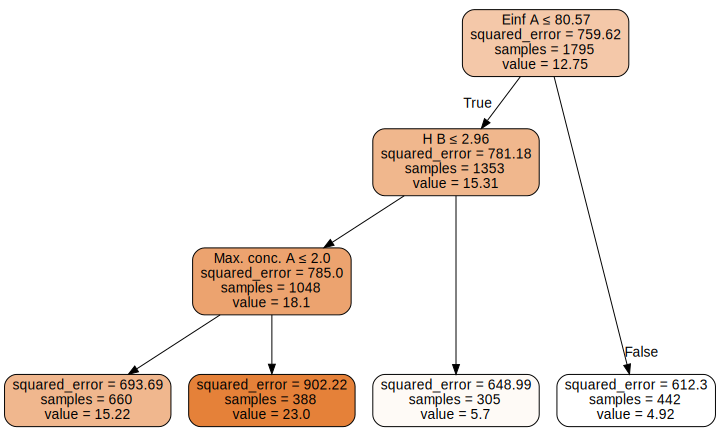

In [ ]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


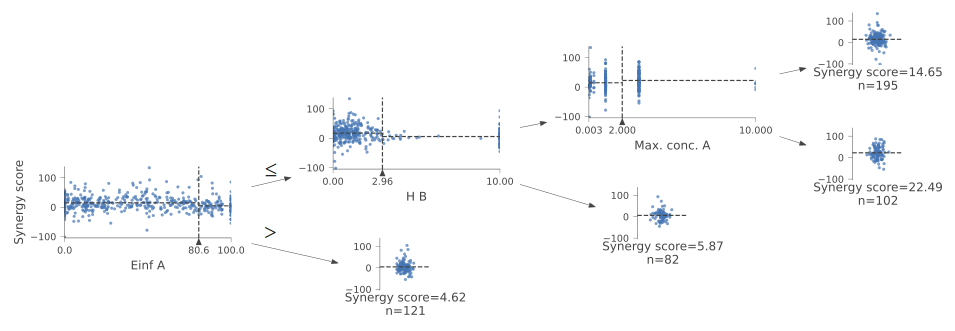

In [ ]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [ ]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [ ]:
m_rmse(m, valid_xs, valid_y)


36.81299

Now we will check for overfitting:

In [ ]:
m.get_n_leaves(), len(xs)

(1795, 1795)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.997595, 28.145969)

In [ ]:
m.get_n_leaves()


55

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [ ]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [ ]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 152 
 Error = 27.38495


Let's check our metric

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf = best_leaf)
m.fit(to.train.xs, to.train.y)
y_pred = m.predict(valid_xs)
print(test_df.shape)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)


(1089, 13)
Weighted Pearson:  nan
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


For some drug combination we obtain NaN's. My hypothesis is that for some drug pairs the predicted value is the same for all cell lines.

In [ ]:
check_nan = pear_weights_df["Pearson coefficient"].isnull()
combination_index = np.arange(pear_weights_df.shape[0], dtype = int)
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

Combination ID  n_cl  Pearson coefficient
54       ALK.CSNK2A1_2     6                  NaN
96   MTOR_1.TNKS_PARP6     7                  NaN
133    Cisplatin.PIK3C     3                  NaN
138      AKT.Cisplatin     3                  NaN
148    AKT.Chloroquine     5                  NaN
157     MTOR_1.SLC16A4     7                  NaN

These are the drug combinations that have a NaN Pearson correlation. We pick the first one and check for the predicted values.

In [ ]:
nan_mask = test_df["Combination ID"] == "ALK.CSNK2A1_2"
ALK_CSNK2A1_2_df = test_df[nan_mask]
ALK_CSNK2A1_2_df

Cell line name Compound A Compound B  Max. conc. A  ...       H B  \
217       NCI-H1563  CSNK2A1_2        ALK          0.03  ...  1.831949   
272        NCI-H522  CSNK2A1_2        ALK          0.03  ...  1.652920   
1386      NCI-H2085  CSNK2A1_2        ALK          0.03  ...  1.161107   
1633          SW900  CSNK2A1_2        ALK          0.01  ...  0.685584   
3290      NCI-H2291  CSNK2A1_2        ALK          0.01  ...  0.796128   
3331       NCI-H838  CSNK2A1_2        ALK          0.10  ...  1.619777   

        Einf B  Synergy score  Combination ID  
217   1.578234       5.147264   ALK.CSNK2A1_2  
272   0.000000     -15.121200   ALK.CSNK2A1_2  
1386  0.000000       9.019851   ALK.CSNK2A1_2  
1633  0.000000      15.030920   ALK.CSNK2A1_2  
3290  0.000000      16.914830   ALK.CSNK2A1_2  
3331  0.000000      16.545240   ALK.CSNK2A1_2  

[6 rows x 13 columns]

In [ ]:
y_pred_ALK_CSNK2A1_2 = y_pred[nan_mask]
y_pred_ALK_CSNK2A1_2

array([21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048])

Just as I imagined. We are predicting the same values over and over. That's why our metric fails.

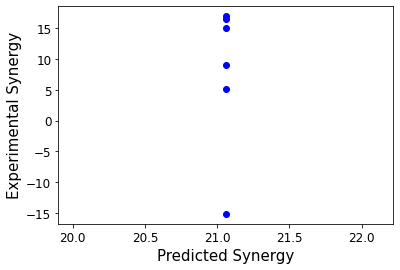

In [ ]:
plt.plot(y_pred_ALK_CSNK2A1_2 , ALK_CSNK2A1_2_df["Synergy score"] , "bo")
plt.ylabel("Experimental Synergy", fontsize = 15)
plt.xlabel("Predicted Synergy", fontsize = 15)
plt.savefig("predicted_experimental_synergy_decision_tree_nan.eps", format = 'eps', dpi=300)


Now with our metric function that takes nan's into account:


In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.11147801629765684
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Just to make sure we check for the previous rows of pear_weights_df where there were nan's.

In [ ]:
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

Combination ID  n_cl  Pearson coefficient
54       ALK.CSNK2A1_2     6                  0.0
96   MTOR_1.TNKS_PARP6     7                  0.0
133    Cisplatin.PIK3C     3                  0.0
138      AKT.Cisplatin     3                  0.0
148    AKT.Chloroquine     5                  0.0
157     MTOR_1.SLC16A4     7                  0.0

The function works.

# Random Forest

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(24.374761, 26.497797)

A little better than the Tree regressor, but not that great.

In [ ]:
y_pred = m.predict(valid_xs)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.16706360356491573
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.429530
1        FASN.MTOR_1     7            -0.013100
2         IAP.IGFR_3     3             0.884104
3        FGFR.MTOR_3     5             0.914940
4         IAP.PIK3CB    10             0.398945
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.755894
163      HSP90.PIK3C     3             0.304881
164  ATM.Gemcitabine     3            -0.278453
165     ATR_4.HDAC_4     3             0.999990
166   BCL2.CSNK2A1_2     6            -0.554555

[167 rows x 3 columns]


We see that Random Forest gives better prediction than Decision Trees. 

Let's try to obtain meaningful info. For example, let's order drug combinations from highest to lowest correlation

In [ ]:
ordered_df = pear_weights_df.sort_values(by = "Pearson coefficient",
                                         ascending = False)
print(ordered_df)

        Combination ID  n_cl  Pearson coefficient
165       ATR_4.HDAC_4     3             0.999990
31            FGFR.WNT     3             0.999920
8    Gemcitabine.PARP1     3             0.999857
156  EG5.PIK3CB_PIK3CD     3             0.998560
151        MAP2K_1.TKI     3             0.998325
..                 ...   ...                  ...
145  AKT_1.Chloroquine     5            -0.803913
148    AKT.Chloroquine     5            -0.807129
77            IAP.SN38     3            -0.971769
65      IGFR_4.MAP2K_1     3            -0.992857
85      IGFR_3.MAP2K_1     3            -0.996501

[167 rows x 3 columns]


Now the most uncorrelated:

In [ ]:
ordered_df["abs Pearson"] = np.abs(ordered_df["Pearson coefficient"])
ordered_df = ordered_df.sort_values(by ="abs Pearson",
                                         ascending = True)
ordered_df.head(10)

Combination ID  n_cl  Pearson coefficient  abs Pearson
123          BCL2.MAP2K_1     3             0.005340     0.005340
122          FGFR.SLC16A4     6            -0.008699     0.008699
20        FGFR.TNKS_PARP6     7            -0.009324     0.009324
107  CarboTaxol.CSNK2A1_2     5            -0.009835     0.009835
1             FASN.MTOR_1     7            -0.013100     0.013100
137            AKT.HDAC_4     5            -0.015835     0.015835
117    ADAM17.BCL2_BCL2L1     7             0.022154     0.022154
13   ADAM17.PIK3CB_PIK3CD     8            -0.025216     0.025216
118             AKT.ATR_4    10            -0.027071     0.027071
149       Cisplatin.PARP1     3             0.028164     0.028164

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

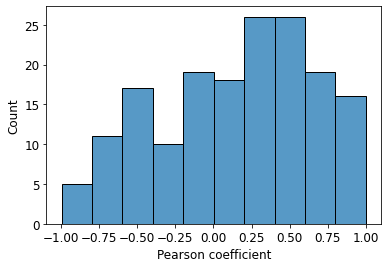

In [ ]:
sns.histplot(data = ordered_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_random_forest.eps", format = 'eps', dpi=300)


Let's try to do a bit of hyperparameter tuning to check for the best hyperparameters for random forest. 

In [ ]:
def rf_training(xs, y, test_df, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, random_state = 42, **kwargs):
   m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf,random_state = random_state , 
        oob_score=True)
   m.fit(xs, y)      
   y_pred = m.predict(valid_xs)
   weighted_pear = wpc_score(test_df, y_pred)
   return weighted_pear

Let's try our function and see if it reproduces previous results.

In [ ]:
rf_training(xs, y, test_df)

0.186327856782357

Close enough, the small difference can be explained by the fact that we didn't fix the random seed. Let's try some hyperparameter tuning.

# Tabular learner fastai
As next model we will try a Tabular Learner from FastAI. 
First thing we have to do is normalize the data. We create another TabularPandas object:


In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)

Now we create our dataloader and check for the maximum and minimum of our data. This is useful as we will limit the output interval of our model

In [ ]:
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

(-178.6540985107422, 237.37640380859375)

We create our learner and look for an optimal learning rate with lr_find.

SuggestedLRs(valley=0.0010000000474974513)

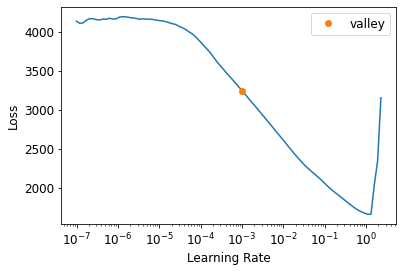

In [ ]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[200,50, 20],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()


Now we finetune our learner by a few epochs.



In [ ]:
learn.fit_one_cycle(50, 1e-3)


Lastly, we obtain our predictions and compute the WPC metric. Since the FastAI learner outputs a tensor, we have to Flatten it.


In [ ]:
y_pred, targs = learn.get_preds()
y_pred = np.asarray(y_pred[:,0])
wpc_score(test_df, y_pred)


0.10968063703535985

In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.10968063703535985
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.727809
1        FASN.MTOR_1     7             0.467770
2         IAP.IGFR_3     3            -0.944783
3        FGFR.MTOR_3     5             0.505273
4         IAP.PIK3CB    10             0.643841
..               ...   ...                  ...
162   Cisplatin.FGFR     3             0.678983
163      HSP90.PIK3C     3            -0.456856
164  ATM.Gemcitabine     3             0.647182
165     ATR_4.HDAC_4     3             0.328268
166   BCL2.CSNK2A1_2     6             0.292057

[167 rows x 3 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

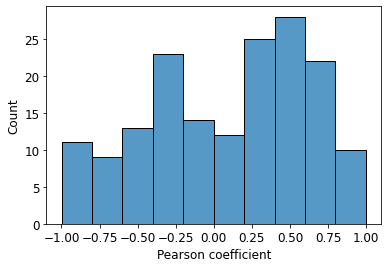

In [ ]:
sns.histplot(data = pear_weights_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_tabular_learner.eps", format = 'eps', dpi=300)

# Ensemble: Tabular Learner + Random Forest.

We will average predictions between Tabular Learner and Random Forest to create a superior model.

In [68]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear


def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [ ]:


"Random Forest"
"Without SMILES"
m_rf = rf(xs, y);
y_pred_rf = m_rf.predict(valid_xs)
#y_pred_rf_2 = m_rf.predict(valid_xs_perm)
#y_pred_rf = (y_pred_rf_1 + y_pred_rf_2)/2
wpc_rf = wpc_score(test_df, y_pred_rf)
print("Without SMILES:", wpc_rf)





Without SMILES: 0.27135957310695213


In [ ]:
"With SMILES"
m_rf = rf(xs_sm, y_sm);
y_pred_rf_sm = m_rf.predict(valid_xs_sm)
wpc_rf_sm = wpc_score(test_df, y_pred_rf_sm)
print("With SMILES:", wpc_rf_sm)

With SMILES: 0.277029610596915


In [ ]:
"Binary operation"
m_rf = rf(xs_bin, y_bin);
y_pred_rf_bin = m_rf.predict(valid_xs_bin)
wpc_rf_bin = wpc_score(test_df_bin, y_pred_rf_bin)
print("Binary operation", wpc_rf_bin)

Binary operation 0.28507221481074907


Let's see if performance increases when we use pearson correlation coefficient as metric and EarlyStopping and SaveModelCallback callbacks

Better model found at epoch 0 with pearsonr value: -0.11933581536248486.
Better model found at epoch 1 with pearsonr value: -0.11512954346894645.
Better model found at epoch 2 with pearsonr value: -0.1082308246639444.
Better model found at epoch 3 with pearsonr value: -0.1037587807061582.
Better model found at epoch 4 with pearsonr value: -0.09661131928533405.
Better model found at epoch 5 with pearsonr value: -0.08747904418315261.
Better model found at epoch 6 with pearsonr value: -0.07838330429602004.
Better model found at epoch 7 with pearsonr value: -0.06689306554482186.
Better model found at epoch 8 with pearsonr value: -0.053523156085637846.
Better model found at epoch 9 with pearsonr value: -0.04012124955177783.
Better model found at epoch 10 with pearsonr value: -0.026201493341297236.
Better model found at epoch 11 with pearsonr value: -0.012269797776779817.
Better model found at epoch 12 with pearsonr value: 0.002020143094756439.
Better model found at epoch 13 with pearsonr va

Without SMILES: 0.16136427992234295


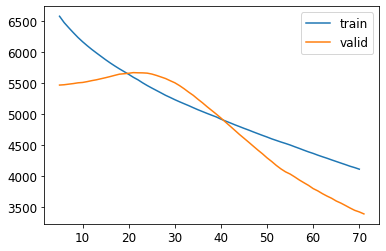

In [ ]:
"Tabular learner"

"Without SMILES"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn = TabularPandas(df_no_sm, procs, cat, cont, y_names=dep_var, 
                      splits=splits)
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()
dls = to.dataloaders(1024)


callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]


learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[20, 10],
                        n_out=1, loss_func=F.mse_loss, 
                        metrics = PearsonCorrCoef(), cbs = callbacks)
#learn.lr_find()
learn.fit(n_epoch = 300, lr = 0.001)
learn.recorder.plot_loss()
y_pred_nn_1, targs = learn.get_preds()
y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


wpc_tl = wpc_score(test_df, y_pred_nn_1)
print("Without SMILES:", wpc_tl)


Better model found at epoch 0 with pearsonr value: -0.007387478601815768.
Better model found at epoch 2 with pearsonr value: 0.0005053342566513661.
Better model found at epoch 3 with pearsonr value: 0.016306503660247534.
Better model found at epoch 4 with pearsonr value: 0.03678133823367594.
Better model found at epoch 5 with pearsonr value: 0.05609051312792833.
Better model found at epoch 6 with pearsonr value: 0.07475186089687892.
Better model found at epoch 7 with pearsonr value: 0.0962689728506677.
Better model found at epoch 8 with pearsonr value: 0.11448233870173574.
Better model found at epoch 9 with pearsonr value: 0.13084030447946468.
Better model found at epoch 10 with pearsonr value: 0.1493628090234401.
Better model found at epoch 11 with pearsonr value: 0.1684028843481948.
Better model found at epoch 12 with pearsonr value: 0.1847942625866994.
Better model found at epoch 13 with pearsonr value: 0.1985382291438663.
Better model found at epoch 14 with pearsonr value: 0.210939

With SMILES: 0.22277660265082064


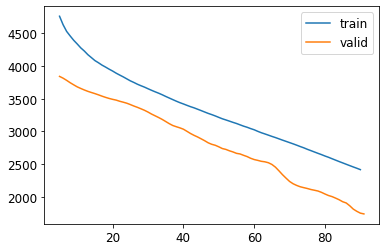

In [ ]:
"Tabular learner"

"With SMILES"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn_sm = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)
dls = to_nn_sm.dataloaders(1024)
y = to_nn_sm.train.y
y.min(),y.max()

callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]


learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[20,10],
                        n_out=1, loss_func=F.mse_loss, 
                        metrics = PearsonCorrCoef(), cbs = callbacks)
#learn.lr_find()
learn.fit(n_epoch = 300, lr = 0.001)
learn.recorder.plot_loss()
y_pred_nn_1_sm, targs = learn.get_preds()
y_pred_nn_1_sm = np.asarray(y_pred_nn_1_sm[:,0])


wpc_tl_sm = wpc_score(test_df, y_pred_nn_1_sm)
print("With SMILES:", wpc_tl_sm)

Better model found at epoch 0 with pearsonr value: -0.007600830949564965.
Better model found at epoch 1 with pearsonr value: 0.012630940860312842.
Better model found at epoch 2 with pearsonr value: 0.03203539694523722.
Better model found at epoch 3 with pearsonr value: 0.056437339137271246.
Better model found at epoch 4 with pearsonr value: 0.08811926633950935.
Better model found at epoch 5 with pearsonr value: 0.11829947231361007.
Better model found at epoch 6 with pearsonr value: 0.1487782426475888.
Better model found at epoch 7 with pearsonr value: 0.17418966760599158.
Better model found at epoch 8 with pearsonr value: 0.1951176578104453.
Better model found at epoch 9 with pearsonr value: 0.21336363346548665.
Better model found at epoch 10 with pearsonr value: 0.22742412975230666.
Better model found at epoch 11 with pearsonr value: 0.23911027388251863.
Better model found at epoch 12 with pearsonr value: 0.24996383916722645.
Better model found at epoch 13 with pearsonr value: 0.26027

Binary Operation 0.2244584759512901


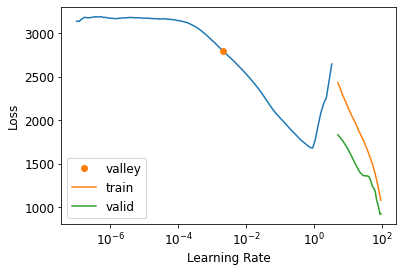

In [ ]:
"Tabular learner"

"Binary Operation"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn_bin = TabularPandas(df_bin_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits_bin)
dls = to_nn_bin.dataloaders(1024)
y_bin = to_nn_bin.train.y
y_bin.min(),y_bin.max()

callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=40), SaveModelCallback(monitor='pearsonr')]


learn = tabular_learner(dls, y_range=(y_bin.min(),y_bin.max()), layers=[20,10],
                        n_out=1, loss_func=F.mse_loss, 
                        metrics = PearsonCorrCoef(), cbs = callbacks)
learn.lr_find()
learn.fit(n_epoch = 500, lr = 0.001)
learn.recorder.plot_loss()
y_pred_nn_1_bin, targs = learn.get_preds()
y_pred_nn_1_bin = np.asarray(y_pred_nn_1_bin[:,0])


wpc_tl_bin= wpc_score(test_df_bin, y_pred_nn_1_bin)
print("Binary Operation", wpc_tl_bin)

let's save this learner and try to optimise it more.

In [ ]:
learn.save("/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth")

Path('/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth.pth')

In [ ]:
"And load it"
learn.load("/content/drive/MyDrive/archivos_tfm/tabular_model_commutative.pth")
y_pred_nn_1_sm, targs = learn.get_preds()
y_pred_nn_1_sm = np.asarray(y_pred_nn_1_sm[:,0])


wpc_score(test_df, y_pred_nn_1_sm)

0.18039657801792186

In [ ]:
valid_xs_perm_nn = to_nn.valid.xs.copy()

valid_xs_perm_nn[[ 'Compound A', 'Compound B', 
                         'Max. conc. A',
                         'Max. conc. B', 
                         'IC50 A', 'H A', 
                         'Einf A', 'IC50 B', 
                         'H B', 'Einf B']] = to_nn.valid.xs[[ 'Compound B', 'Compound A', 
                         'Max. conc. B',
                         'Max. conc. A', 
                         'IC50 B', 'H B', 
                         'Einf B', 'IC50 A', 
                         'H A', 'Einf A']]
valid_xs_perm_nn

Cell line name  Compound A  Compound B  Max. conc. A  ...      Einf A  \
5                 32           2          32           1.0  ...   58.538452   
11                 7           2          49           1.0  ...   34.658417   
19                51          27          40           1.0  ...  100.000000   
33                35           1           2          75.0  ...   73.495689   
40                28          11          36           3.0  ...    0.764862   
...              ...         ...         ...           ...  ...         ...   
5256              51           1           2          75.0  ...  100.000000   
5260              26          31          43           1.0  ...   75.080116   
5261              71          40          61           3.0  ...    0.000000   
5262               9          51          64           1.0  ...   70.299622   
5265              57          36          66           3.0  ...   71.768280   

        IC50 B        H B      Einf B  
5     1.000008  10.000000   78.399574  
11    1.000000   0.556940   54.700432  
19    1.000000  10.000000   93.800095  
33    1.000000   0.258988   17.701706  
40    0.006467   0.244922    0.000000  
...        ...        ...         ...  
5256  0.226297   1.952148   17.477798  
5260  0.068121   2.789950   27.901039  
5261  1.000000   0.000000  100.000000  
5262  0.009716   0.380575   38.365410  
5265  0.464939   1.345137    2.480696  

[1089 rows x 11 columns]

In [ ]:
y_pred_nn_2, targs = learn.predict(valid_xs_perm_nn)
y_pred_nn_2 = np.asarray(y_pred_nn_2[:,0])


wpc_score(test_df, y_pred_nn_2)

NameError: ignored

I have not been able to use valid_xs_perm_nn to predict something in the tabular learner.

All together:

In [ ]:
y_pred_avg = (y_pred_rf + y_pred_nn_1 )/ 2
wpc_score(test_df, y_pred_avg)

0.27555959920998935

# XGBOOST

Out of curiosity, let's try XGBoost and ensemble it.

In [ ]:
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
"Without SMILES"
m_xgb.fit(xs, y)
y_pred_xgb = m_xgb.predict(valid_xs)
#y_pred_xgb_2 = m_xgb.predict(valid_xs_perm)
#y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)/2

wpc_xgb = wpc_score(test_df, y_pred_xgb)

print("Without SMILES", wpc_xgb)





[14:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Without SMILES 0.27298620418946834


In [ ]:
"With SMILES"
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs_sm, y_sm)
y_pred_xgb_sm = m_xgb.predict(valid_xs_sm)
#y_pred_xgb_2 = m_xgb.predict(valid_xs_perm)
#y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)/2

wpc_xgb_sm = wpc_score(test_df, y_pred_xgb_sm)
print("With SMILES", wpc_xgb_sm)

[14:13:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
With SMILES 0.2827124249534873


In [ ]:
"Binary Operator"
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs_bin, y_bin)
y_pred_xgb_bin = m_xgb.predict(valid_xs_bin)
#y_pred_xgb_2 = m_xgb.predict(valid_xs_perm)
#y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)/2

wpc_xgb_bin = wpc_score(test_df_bin, y_pred_xgb_bin)
print("Binary Operator", wpc_xgb_bin)

[14:09:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Binary Operator 0.26434462237977757


Now we ensemble RF, XGBoost and Tabular Learner.

In [ ]:
"Without SMILES"
y_pred_avg = (y_pred_rf + y_pred_nn_1 + y_pred_xgb)/ 3
print("Without SMILES", wpc_score(test_df, y_pred_avg))

"With SMILES"
y_pred_avg_sm = (y_pred_rf_sm + y_pred_nn_1_sm + y_pred_xgb_sm)/ 3
print("With SMILES", wpc_score(test_df, y_pred_avg_sm))

Without SMILES 0.3006394025106124
With SMILES 0.31157114849664486


And only Random Forest and XGBoost

In [ ]:
"Without SMILES"
y_pred_avg = (y_pred_rf +  y_pred_xgb)/ 2
print("Without SMILES", wpc_score(test_df, y_pred_avg))

"With SMILES"
y_pred_avg_sm = (y_pred_rf_sm  + y_pred_xgb_sm)/ 2
print("With SMILES", wpc_score(test_df, y_pred_avg_sm))

Without SMILES 0.28158655835777713
With SMILES 0.3031739283443954


# Support Vector Regressor

In [ ]:


procs_nn = [Categorify, FillMissing, Normalize]

"Without SMILES"
to_nn = TabularPandas(df_no_sm, procs_nn, cat, cont, y_names=dep_var, 
                      splits=splits)
m_SVR = SVR(kernel="linear")
m_SVR.fit(to_nn.train.xs, to_nn.train.y)
y_pred_SVR = m_SVR.predict(to_nn.valid.xs)

wpc_svr = wpc_score(test_df, y_pred_SVR)
print("Without SMILES", wpc_svr)




Without SMILES 0.17396829091777904


In [ ]:
"With SMILES"

m_SVR = SVR(kernel="linear")
m_SVR.fit(xs_sm, y_sm)
y_pred_SVR_sm = m_SVR.predict(valid_xs_sm)

wpc_svr_sm = wpc_score(test_df, y_pred_SVR_sm)
print("With SMILES", wpc_svr_sm)


With SMILES 0.2409617051693177


In [ ]:
"Binary Operator"

m_SVR = SVR(kernel="linear")
m_SVR.fit(xs_bin, y_bin)
y_pred_SVR_bin = m_SVR.predict(valid_xs_bin)

wpc_svr_bin = wpc_score(test_df_bin, y_pred_SVR_bin)
print("Binary Operator", wpc_svr_bin)

Binary Operator 0.22381522941908988


With both permutations

In [ ]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(xs, y)
y_pred_SVR_1 = m_SVR.predict(valid_xs)
y_pred_SVR_2 = m_SVR.predict(valid_xs_perm)
y_pred_SVR = (y_pred_SVR_1 + y_pred_SVR_2)/2

wpc_score(test_df, y_pred_SVR)

0.14511698665160222

Now we ensemble the 4 of them:
Random Forest + XGBoost + Neural Networks + SVM

In [ ]:
"Without SMILES"
y_pred_avg = (y_pred_rf + y_pred_nn_1 + y_pred_xgb + y_pred_SVR)/ 4
wpc_all = wpc_score(test_df, y_pred_avg)
print("Without SMILES", wpc_all)



Without SMILES 0.2862508820658359


In [ ]:
"With SMILES"
y_pred_avg_sm = (y_pred_rf_sm + y_pred_nn_1_sm + y_pred_xgb_sm + y_pred_SVR_sm)/ 4
wpc_all_sm = wpc_score(test_df, y_pred_avg_sm)
print("With SMILES", wpc_all_sm)

With SMILES 0.32507911895544267


In [ ]:
"Binary Operator"
y_pred_avg_bin = (y_pred_rf_bin + y_pred_nn_1_bin + y_pred_xgb_bin + y_pred_SVR_bin)/ 4
wpc_all_bin = wpc_score(test_df_bin, y_pred_avg_bin)
print("Binary Operator", wpc_all_bin)

Binary Operator 0.3208208885726087


Without tabular learner

In [ ]:
"Without SMILES"
y_pred_avg = (y_pred_rf  + y_pred_xgb + y_pred_SVR)/ 3
print("Without SMILES", wpc_score(test_df, y_pred_avg))


In [ ]:

"With SMILES"
y_pred_avg_sm = (y_pred_rf_sm  + y_pred_xgb_sm + y_pred_SVR_sm)/ 3
print("With SMILES", wpc_score(test_df, y_pred_avg_sm))


With SMILES 0.32415018840154103


In [ ]:
"Binary Operator"
y_pred_avg_bin = (y_pred_rf_bin  + y_pred_xgb_bin + y_pred_SVR_bin)/ 3
print("Binary Operator", wpc_score(test_df_bin, y_pred_avg_bin))

Binary Operator 0.30034907691795704


We construct and evalutation table. We are mixing variables so we are going to freeze old  wpc and keep adding new ones.

In [ ]:
eval_df = pd.DataFrame()
eval_df["Model"] = ["Random Forest", "Tabular Learner", "XGBoost", "SVR", "Ensemble"]
eval_df["WPC without FP"] = [wpc_rf, wpc_tl, wpc_xgb, wpc_svr, wpc_all]

eval_df["WPC with FP"] = [wpc_rf_sm, wpc_tl_sm, wpc_xgb_sm, wpc_svr_sm, wpc_all_sm]
eval_df["Binary Operation OR"] = [wpc_rf_bin, wpc_tl_bin, wpc_xgb_bin, wpc_svr_bin, wpc_all_bin]

eval_df.set_index(["Model"])
eval_df

Model  WPC without FP  WPC with FP  Binary Operation OR
0    Random Forest        0.271360     0.277030             0.285072
1  Tabular Learner        0.161364     0.222777             0.224458
2          XGBoost        0.272986     0.282712             0.264345
3              SVR        0.173968     0.240962             0.223815
4         Ensemble        0.286251     0.325079             0.320821

In [ ]:
eval_df

Model  WPC without FP  WPC with FP  Binary Operation OR
0    Random Forest        0.251828     0.261953             0.254812
1  Tabular Learner        0.205399     0.234823             0.245236
2          XGBoost        0.263119     0.280912             0.289202
3              SVR        0.174010     0.240955             0.223810
4         Ensemble        0.314619     0.325675             0.167639

In [ ]:
eval_df_bin = pd.DataFrame()

eval_df_bin["Binary Operation OR"] = [wpc_rf_bin, wpc_tl_bin, wpc_xgb_bin, wpc_svr_bin, wpc_all_bin]
eval_df_bin

Binary Operation OR
0             0.285072
1             0.224458
2             0.264345
3             0.223815
4             0.320821

## Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m_rf, xs)
fi[:10]

cols       imp
0   Cell line name  0.122700
7           Einf A  0.119059
9              H B  0.117066
10          Einf B  0.109905
6              H A  0.107753
8           IC50 B  0.097234
5           IC50 A  0.094072
1       Compound A  0.081534
2       Compound B  0.081325
3     Max. conc. A  0.038421

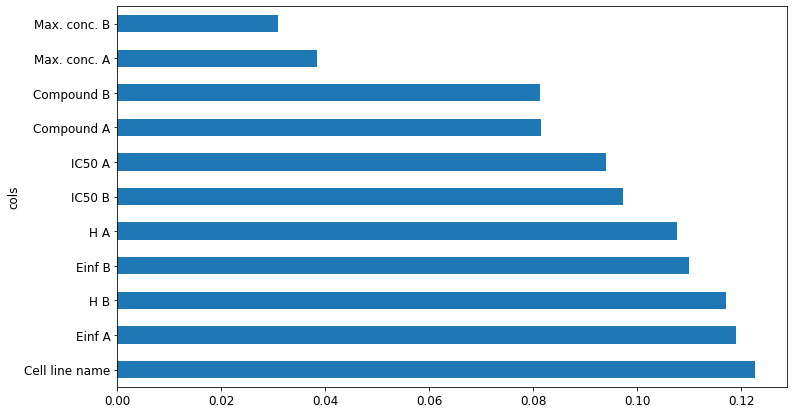

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Here we don't have a lot of columns, so we don't have
to erase any of them.

# Creating new features:

We will try to do some feature engineering.

First we are going to create features independent of the order of the drugs, since we would want our input to be commutative with respect to the drug.

In [ ]:
df_nocomb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score'],
      dtype='object')

In [ ]:
df_new_f = pd.DataFrame()
df_new_f[['Cell line name', 
          'Compound A', 'Compound B', 
          'Synergy score']] = df_nocomb[['Cell line name', 'Compound A', 
                     'Compound B', 'Synergy score']]
df_new_f["Av_max_conc"] =  (df_nocomb['Max. conc. A'] + df_nocomb['Max. conc. B']) / 2

df_new_f["abs_dif_max_conc"] =  np.abs(df_nocomb['Max. conc. A'] - df_nocomb['Max. conc. B'])

df_new_f["Av_IC50"] =  (df_nocomb['IC50 A'] + df_nocomb['IC50 B']) / 2

df_new_f["abs_dif_IC50"] =  np.abs(df_nocomb['IC50 A'] - df_nocomb['IC50 B'])

df_new_f["Av_H"] =  (df_nocomb['H A'] + df_nocomb['H B']) / 2

df_new_f["abs_dif_IC50"] =  np.abs(df_nocomb['H A'] + df_nocomb['H B'])

df_new_f["Av_Einf"] =  (df_nocomb['Einf A'] + df_nocomb['Einf B']) / 2

df_new_f["abs_dif_Einf"] =  np.abs(df_nocomb['Einf A'] + df_nocomb['Einf B'])

df_new_f


Cell line name Compound A Compound B  Synergy score  ...  abs_dif_IC50  \
0           HCC1143       FGFR       EGFR      25.848650  ...      1.106136   
1        MDA-MB-468      PIK3C      AKT_1      24.378630  ...     11.502789   
2           MFM-223    MAP2K_1      ATR_4     -19.085140  ...     10.000000   
3             BT-20     MTOR_1       FASN      20.951370  ...      1.660213   
4             SW948     IGFR_3        IAP      40.200730  ...      1.233020   
...             ...        ...        ...            ...  ...           ...   
3470            RKO        JAK        IAP      -1.023761  ...     11.452473   
3471      NCI-H1703   PIK3CA_3        IAP      12.894160  ...      2.845207   
3472          SW948       PTK2    MAP2K_1      19.809670  ...      2.290002   
3473     MDA-MB-453      PIK3C     ESR1_1      47.096230  ...      2.648087   
3474          BT-20      PIK3C    MAP2K_3      42.359970  ...      1.813260   

          Av_H    Av_Einf  abs_dif_Einf  
0     0.553068  82.493124    164.986248  
1     5.751395  34.949883     69.899766  
2     5.000000  87.549419    175.098838  
3     0.830107   7.193071     14.386142  
4     0.616510  49.210384     98.420767  
...        ...        ...           ...  
3470  5.726236  41.609320     83.218641  
3471  1.422604   9.990222     19.980445  
3472  1.145001   4.404042      8.808083  
3473  1.324043  24.829379     49.658758  
3474  0.906630  41.595543     83.191086  

[3475 rows x 11 columns]

In [ ]:
cont,cat = cont_cat_split(df_new_f, 1, dep_var=dep_var)
to_new_f = TabularPandas(df_new_f, procs, cat, cont, y_names=dep_var, 
                         splits=splits)
xs_new_f, y_new_f = to_new_f.train.xs, to_new_f.train.y
valid_xs_new_f, valid_y_new_f = to_new_f.valid.xs, to_new_f.valid.y

In [ ]:
"Random Forest"
m_rf = rf(xs_new_f, y_new_f, n_estimators=100, max_samples=500,
       max_features=0.7, min_samples_leaf=1 , random_state = 42);
y_pred_rf_new_f = m_rf.predict(valid_xs_new_f)
wpc_score(test_df, y_pred_rf_new_f)


KeyboardInterrupt: ignored

In [ ]:
"XGBoost"
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs_new_f, y_new_f)
y_pred_xgb_new_f = m_xgb.predict(valid_xs_new_f)
wpc_score(test_df, y_pred_xgb_new_f)

It's doesn't improve predictions. We have to look in other direction. 

# Tabular Learner training instability
The results given by tabular learner heavily depend on random seed. We are going to plot a distribution of WPC scores

In [76]:
"Tabular learner"
wpc_tl_list = list()
"Without SMILES"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn = TabularPandas(df_no_sm, procs, cat, cont, y_names=dep_var, 
                      splits=splits)
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()
dls = to.dataloaders(1024)


callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]

for i in range(1000):
  learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[20, 10],
                          n_out=1, loss_func=F.mse_loss, 
                          metrics = PearsonCorrCoef(), cbs = callbacks)
  #learn.lr_find()
  learn.fit(n_epoch = 300, lr = 0.001, )
  y_pred_nn_1, targs = learn.get_preds()
  y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


  wpc_tl_list.append(wpc_score(test_df, y_pred_nn_1))
  print(wpc_tl_list)

Better model found at epoch 15 with pearsonr value: 0.034073567183175564.
Better model found at epoch 16 with pearsonr value: 0.047037798580863245.
Better model found at epoch 17 with pearsonr value: 0.058451827510906815.
Better model found at epoch 18 with pearsonr value: 0.07079669842305791.
Better model found at epoch 19 with pearsonr value: 0.08299332282074415.
Better model found at epoch 20 with pearsonr value: 0.09629358220909023.
Better model found at epoch 21 with pearsonr value: 0.10815837592778793.
Better model found at epoch 22 with pearsonr value: 0.12000429682504998.
Better model found at epoch 23 with pearsonr value: 0.13158894498010748.
Better model found at epoch 24 with pearsonr value: 0.14173177334407466.
Better model found at epoch 25 with pearsonr value: 0.15099016942283744.
Better model found at epoch 26 with pearsonr value: 0.16062292496083264.
Better model found at epoch 27 with pearsonr value: 0.16922960357801642.
Better model found at epoch 28 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13978070138974039.
Better model found at epoch 1 with pearsonr value: -0.13467788210746612.
Better model found at epoch 2 with pearsonr value: -0.12425340432098406.
Better model found at epoch 3 with pearsonr value: -0.11175056300145823.
Better model found at epoch 4 with pearsonr value: -0.09739729683641782.
Better model found at epoch 5 with pearsonr value: -0.0829080620768505.
Better model found at epoch 6 with pearsonr value: -0.06890646097104992.
Better model found at epoch 7 with pearsonr value: -0.058293984191498144.
Better model found at epoch 8 with pearsonr value: -0.04882654284561857.
Better model found at epoch 9 with pearsonr value: -0.03925467597234485.
Better model found at epoch 10 with pearsonr value: -0.02871631304867088.
Better model found at epoch 11 with pearsonr value: -0.019687179083725997.
Better model found at epoch 12 with pearsonr value: -0.010239194870772564.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08839922175995514.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.03343951529560516.
Better model found at epoch 1 with pearsonr value: -0.011095874727299865.
Better model found at epoch 2 with pearsonr value: 0.005865176665198595.
Better model found at epoch 3 with pearsonr value: 0.01760937979827203.
Better model found at epoch 4 with pearsonr value: 0.027821314269523736.
Better model found at epoch 5 with pearsonr value: 0.0392983077933558.
Better model found at epoch 6 with pearsonr value: 0.05128062414890537.
Better model found at epoch 7 with pearsonr value: 0.06369933463554983.
Better model found at epoch 8 with pearsonr value: 0.07662320827114016.
Better model found at epoch 9 with pearsonr value: 0.09041423928841227.
Better model found at epoch 10 with pearsonr value: 0.10448677459188062.
Better model found at epoch 11 with pearsonr value: 0.11821656258591469.
Better model found at epoch 12 with pearsonr value: 0.13049016805647512.
Better model found at epoch 13 with pearsonr value: 0.142

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.022196408506740407.
Better model found at epoch 1 with pearsonr value: -0.0022167680003694124.
Better model found at epoch 2 with pearsonr value: 0.012700023726232284.
Better model found at epoch 3 with pearsonr value: 0.02681401656399214.
Better model found at epoch 4 with pearsonr value: 0.03881657969605468.
Better model found at epoch 5 with pearsonr value: 0.047235234101555786.
Better model found at epoch 6 with pearsonr value: 0.053948755866045896.
Better model found at epoch 7 with pearsonr value: 0.05887750890838412.
Better model found at epoch 8 with pearsonr value: 0.06529496816493931.
Better model found at epoch 9 with pearsonr value: 0.07455110152502595.
Better model found at epoch 10 with pearsonr value: 0.08586493782778107.
Better model found at epoch 11 with pearsonr value: 0.09707782526961149.
Better model found at epoch 12 with pearsonr value: 0.10790064870601716.
Better model found at epoch 13 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08882355713447879.
Better model found at epoch 18 with pearsonr value: 0.09784041074940997.
Better model found at epoch 19 with pearsonr value: 0.10876086006226317.
Better model found at epoch 20 with pearsonr value: 0.11957341667953028.
Better model found at epoch 21 with pearsonr value: 0.129658186873002.
Better model found at epoch 22 with pearsonr value: 0.13996430212982808.
Better model found at epoch 23 with pearsonr value: 0.14948060388807682.
Better model found at epoch 24 with pearsonr value: 0.15876476795405098.
Better model found at epoch 25 with pearsonr value: 0.16797840747703816.
Better model found at epoch 26 with pearsonr value: 0.1765509137457624.
Better model found at epoch 27 with pearsonr value: 0.18567142866286918.
Better model found at epoch 28 with pearsonr value: 0.1937801813233178.
Better model found at epoch 29 with pearsonr value: 0.20164652604831615.
Better model found at epoch 30 with pearsonr value: 0.20

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.025419790816775947.
Better model found at epoch 10 with pearsonr value: 0.02845228374354316.
Better model found at epoch 11 with pearsonr value: 0.03517799172138432.
Better model found at epoch 12 with pearsonr value: 0.042609533395104655.
Better model found at epoch 13 with pearsonr value: 0.04996892264642296.
Better model found at epoch 14 with pearsonr value: 0.057389239110720386.
Better model found at epoch 15 with pearsonr value: 0.06409174906556463.
Better model found at epoch 16 with pearsonr value: 0.0698541026183536.
Better model found at epoch 17 with pearsonr value: 0.07518463270932453.
Better model found at epoch 18 with pearsonr value: 0.07908632537035219.
Better model found at epoch 19 with pearsonr value: 0.08259395062339181.
Better model found at epoch 20 with pearsonr value: 0.0858287088941703.
Better model found at epoch 21 with pearsonr value: 0.08820272633966673.
Better model found at epoch 22 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.10233462059935176.
Better model found at epoch 1 with pearsonr value: -0.08811860249181734.
Better model found at epoch 2 with pearsonr value: -0.07565789076015535.
Better model found at epoch 3 with pearsonr value: -0.06629003015604247.
Better model found at epoch 4 with pearsonr value: -0.059325745432268456.
Better model found at epoch 5 with pearsonr value: -0.05086818720951659.
Better model found at epoch 6 with pearsonr value: -0.04513045074359533.
Better model found at epoch 7 with pearsonr value: -0.03721475447602467.
Better model found at epoch 8 with pearsonr value: -0.02676807785099098.
Better model found at epoch 9 with pearsonr value: -0.018052829916387687.
Better model found at epoch 10 with pearsonr value: -0.0072616906434210685.
Better model found at epoch 11 with pearsonr value: 0.004051347429518112.
Better model found at epoch 12 with pearsonr value: 0.01325936886994729.
Better model found at epoch 13 with pearsonr 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0018498486075151218.
Better model found at epoch 1 with pearsonr value: 0.008199756697192988.
Better model found at epoch 2 with pearsonr value: 0.019804084636403062.
Better model found at epoch 3 with pearsonr value: 0.028526706698629212.
Better model found at epoch 4 with pearsonr value: 0.03427988763238129.
Better model found at epoch 5 with pearsonr value: 0.03744624348633222.
Better model found at epoch 6 with pearsonr value: 0.038640178721321236.
Better model found at epoch 7 with pearsonr value: 0.039058395742841166.
Better model found at epoch 8 with pearsonr value: 0.04058678821150732.
Better model found at epoch 9 with pearsonr value: 0.0422595844185713.
Better model found at epoch 10 with pearsonr value: 0.04249265660214945.
Better model found at epoch 11 with pearsonr value: 0.04387053914596938.
Better model found at epoch 12 with pearsonr value: 0.04464133567279307.
Better model found at epoch 13 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0073236438053345485.
Better model found at epoch 1 with pearsonr value: 0.01072802688394185.
Better model found at epoch 2 with pearsonr value: 0.011784457680313255.
Better model found at epoch 3 with pearsonr value: 0.014880825595773504.
Better model found at epoch 4 with pearsonr value: 0.01696772110686017.
Better model found at epoch 5 with pearsonr value: 0.01927883159962676.
Better model found at epoch 6 with pearsonr value: 0.02305491295157884.
Better model found at epoch 7 with pearsonr value: 0.03019644037332784.
Better model found at epoch 8 with pearsonr value: 0.04220820360437108.
Better model found at epoch 9 with pearsonr value: 0.055068532558709936.
Better model found at epoch 10 with pearsonr value: 0.06895360427757073.
Better model found at epoch 11 with pearsonr value: 0.08357115722179917.
Better model found at epoch 12 with pearsonr value: 0.09770068983311292.
Better model found at epoch 13 with pearsonr value: 0.11

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.10993582433552622.
Better model found at epoch 1 with pearsonr value: 0.11370640117172132.
Better model found at epoch 2 with pearsonr value: 0.11461578159899431.
Better model found at epoch 3 with pearsonr value: 0.11552552686773243.
Better model found at epoch 4 with pearsonr value: 0.11636325494865413.
Better model found at epoch 5 with pearsonr value: 0.11887798329208861.
Better model found at epoch 6 with pearsonr value: 0.12244451320155675.
Better model found at epoch 7 with pearsonr value: 0.12745110344947658.
Better model found at epoch 8 with pearsonr value: 0.13391585229998948.
Better model found at epoch 9 with pearsonr value: 0.14079323558754345.
Better model found at epoch 10 with pearsonr value: 0.14717674980992004.
Better model found at epoch 11 with pearsonr value: 0.15228338256400414.
Better model found at epoch 12 with pearsonr value: 0.15611109512779858.
Better model found at epoch 13 with pearsonr value: 0.1593552

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.02392365810575285.
Better model found at epoch 12 with pearsonr value: -0.021085625307742578.
Better model found at epoch 13 with pearsonr value: -0.012390589422593247.
Better model found at epoch 14 with pearsonr value: -0.0019735492868784114.
Better model found at epoch 15 with pearsonr value: 0.008930981041996269.
Better model found at epoch 16 with pearsonr value: 0.020085430906079768.
Better model found at epoch 17 with pearsonr value: 0.03206833602282943.
Better model found at epoch 18 with pearsonr value: 0.04412505171624389.
Better model found at epoch 19 with pearsonr value: 0.056351802897713035.
Better model found at epoch 20 with pearsonr value: 0.06822481659745622.
Better model found at epoch 21 with pearsonr value: 0.07877483806876835.
Better model found at epoch 22 with pearsonr value: 0.08910218019250658.
Better model found at epoch 23 with pearsonr value: 0.09847683073368542.
Better model found at epoch 24 with pears

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13995145874395498.
Better model found at epoch 16 with pearsonr value: 0.14305510459771867.
Better model found at epoch 17 with pearsonr value: 0.14899702527392938.
Better model found at epoch 18 with pearsonr value: 0.15587034197605107.
Better model found at epoch 19 with pearsonr value: 0.16218292007656238.
Better model found at epoch 20 with pearsonr value: 0.1692764110121786.
Better model found at epoch 21 with pearsonr value: 0.1763189811845964.
Better model found at epoch 22 with pearsonr value: 0.18289915020251893.
Better model found at epoch 23 with pearsonr value: 0.1898478381605304.
Better model found at epoch 24 with pearsonr value: 0.1964475498313642.
Better model found at epoch 25 with pearsonr value: 0.20340126988428892.
Better model found at epoch 26 with pearsonr value: 0.2097553367171771.
Better model found at epoch 27 with pearsonr value: 0.21563659127207765.
Better model found at epoch 28 with pearsonr value: 0.221

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.16303745484734627.
Better model found at epoch 1 with pearsonr value: -0.15237251163464519.
Better model found at epoch 2 with pearsonr value: -0.1319267894721038.
Better model found at epoch 3 with pearsonr value: -0.10770145508234442.
Better model found at epoch 4 with pearsonr value: -0.0846760959065893.
Better model found at epoch 5 with pearsonr value: -0.06120903093182645.
Better model found at epoch 6 with pearsonr value: -0.03854347164780798.
Better model found at epoch 7 with pearsonr value: -0.01719328040122171.
Better model found at epoch 8 with pearsonr value: 0.0013069868763841107.
Better model found at epoch 9 with pearsonr value: 0.017813894308480686.
Better model found at epoch 10 with pearsonr value: 0.03336244667282757.
Better model found at epoch 11 with pearsonr value: 0.04728469310849306.
Better model found at epoch 12 with pearsonr value: 0.05959840994605983.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.11548165661560346.
Better model found at epoch 1 with pearsonr value: -0.10420252498309113.
Better model found at epoch 2 with pearsonr value: -0.09055146598958523.
Better model found at epoch 3 with pearsonr value: -0.07651167996069154.
Better model found at epoch 4 with pearsonr value: -0.06486204579300102.
Better model found at epoch 5 with pearsonr value: -0.05062524131931057.
Better model found at epoch 6 with pearsonr value: -0.034455405636945324.
Better model found at epoch 7 with pearsonr value: -0.019394713235507444.
Better model found at epoch 8 with pearsonr value: 0.0006487764996915161.
Better model found at epoch 9 with pearsonr value: 0.018376222631509495.
Better model found at epoch 10 with pearsonr value: 0.03214485745682597.
Better model found at epoch 11 with pearsonr value: 0.04578382944018191.
Better model found at epoch 12 with pearsonr value: 0.0534012693983964.
Better model found at epoch 13 with pearsonr valu

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.07688931788407574.
Better model found at epoch 1 with pearsonr value: 0.09415183051205932.
Better model found at epoch 2 with pearsonr value: 0.10201218347714734.
Better model found at epoch 3 with pearsonr value: 0.10568920018175144.
Better model found at epoch 4 with pearsonr value: 0.10629495427383484.
Better model found at epoch 15 with pearsonr value: 0.10713163040826887.
Better model found at epoch 16 with pearsonr value: 0.10962514355374033.
Better model found at epoch 17 with pearsonr value: 0.11328837881705074.
Better model found at epoch 18 with pearsonr value: 0.11702714268957094.
Better model found at epoch 19 with pearsonr value: 0.12157788627910764.
Better model found at epoch 20 with pearsonr value: 0.12588860592018206.
Better model found at epoch 21 with pearsonr value: 0.13048833867246729.
Better model found at epoch 22 with pearsonr value: 0.1356346009667822.
Better model found at epoch 23 with pearsonr value: 0.140

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.027275995256909442.
Better model found at epoch 1 with pearsonr value: 0.05393488444928449.
Better model found at epoch 2 with pearsonr value: 0.06519202667120624.
Better model found at epoch 3 with pearsonr value: 0.06904460013946574.
Better model found at epoch 4 with pearsonr value: 0.06995958489063836.
Better model found at epoch 5 with pearsonr value: 0.07142892075651062.
Better model found at epoch 6 with pearsonr value: 0.07302986146233788.
Better model found at epoch 8 with pearsonr value: 0.07311289312582038.
Better model found at epoch 9 with pearsonr value: 0.07388433706557211.
Better model found at epoch 10 with pearsonr value: 0.07421610170865453.
Better model found at epoch 11 with pearsonr value: 0.07434626485860556.
Better model found at epoch 12 with pearsonr value: 0.07529430978186545.
Better model found at epoch 13 with pearsonr value: 0.07708702520556122.
Better model found at epoch 14 with pearsonr value: 0.07805

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.12785471598843187.
Better model found at epoch 3 with pearsonr value: -0.1264619149012989.
Better model found at epoch 4 with pearsonr value: -0.12288415297540412.
Better model found at epoch 5 with pearsonr value: -0.11798729881000465.
Better model found at epoch 6 with pearsonr value: -0.1133512504054997.
Better model found at epoch 7 with pearsonr value: -0.10893355294094227.
Better model found at epoch 8 with pearsonr value: -0.10371385536571873.
Better model found at epoch 9 with pearsonr value: -0.0990656054181737.
Better model found at epoch 10 with pearsonr value: -0.0950124393983713.
Better model found at epoch 11 with pearsonr value: -0.0897288404192938.
Better model found at epoch 12 with pearsonr value: -0.08230478056226367.
Better model found at epoch 13 with pearsonr value: -0.07228497061037567.
Better model found at epoch 14 with pearsonr value: -0.06321409134352436.
Better model found at epoch 15 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.15049425597751875.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.01926535987972143.
Better model found at epoch 1 with pearsonr value: 0.03389926811121905.
Better model found at epoch 2 with pearsonr value: 0.041706040285644126.
Better model found at epoch 3 with pearsonr value: 0.04918008212228459.
Better model found at epoch 4 with pearsonr value: 0.0560610245123654.
Better model found at epoch 5 with pearsonr value: 0.06249880647410895.
Better model found at epoch 6 with pearsonr value: 0.06931271866242189.
Better model found at epoch 7 with pearsonr value: 0.07539842308810872.
Better model found at epoch 8 with pearsonr value: 0.08290935253942401.
Better model found at epoch 9 with pearsonr value: 0.0918801865011385.
Better model found at epoch 10 with pearsonr value: 0.10019171255805379.
Better model found at epoch 11 with pearsonr value: 0.10845632809446899.
Better model found at epoch 12 with pearsonr value: 0.1156732766230275.
Better model found at epoch 13 with pearsonr value: 0.121813708

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.04899292921550453.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0188206862568648.
Better model found at epoch 1 with pearsonr value: 0.030566129714476312.
Better model found at epoch 2 with pearsonr value: 0.04209680019999746.
Better model found at epoch 3 with pearsonr value: 0.05301951082811894.
Better model found at epoch 4 with pearsonr value: 0.05926583335083221.
Better model found at epoch 5 with pearsonr value: 0.06188971324627389.
Better model found at epoch 6 with pearsonr value: 0.06480811500767535.
Better model found at epoch 7 with pearsonr value: 0.06905986580188818.
Better model found at epoch 8 with pearsonr value: 0.0731284184772368.
Better model found at epoch 9 with pearsonr value: 0.07724928060661404.
Better model found at epoch 10 with pearsonr value: 0.08198445139533772.
Better model found at epoch 11 with pearsonr value: 0.08667236007681693.
Better model found at epoch 12 with pearsonr value: 0.09251143423682923.
Better model found at epoch 13 with pearsonr value: 0.09827981

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.10138929952127133.
Better model found at epoch 1 with pearsonr value: -0.09607587575121282.
Better model found at epoch 2 with pearsonr value: -0.08925401947281629.
Better model found at epoch 3 with pearsonr value: -0.08156465323740168.
Better model found at epoch 4 with pearsonr value: -0.07753469932186985.
Better model found at epoch 5 with pearsonr value: -0.07521436970751531.
Better model found at epoch 6 with pearsonr value: -0.07405749547623725.
Better model found at epoch 7 with pearsonr value: -0.07312470669831149.
Better model found at epoch 8 with pearsonr value: -0.07232815779364635.
Better model found at epoch 9 with pearsonr value: -0.07078919777297749.
Better model found at epoch 10 with pearsonr value: -0.06838286120603651.
Better model found at epoch 11 with pearsonr value: -0.0625955234004706.
Better model found at epoch 12 with pearsonr value: -0.05525206844902916.
Better model found at epoch 13 with pearsonr valu

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08861000314028009.
Better model found at epoch 1 with pearsonr value: 0.09794094079687958.
Better model found at epoch 2 with pearsonr value: 0.10220128862592942.
Better model found at epoch 3 with pearsonr value: 0.10462523216651988.
Better model found at epoch 4 with pearsonr value: 0.10680677657405839.
Better model found at epoch 5 with pearsonr value: 0.10838737583121948.
Better model found at epoch 15 with pearsonr value: 0.10909301096029678.
Better model found at epoch 16 with pearsonr value: 0.11133678982870375.
Better model found at epoch 17 with pearsonr value: 0.11277721070842084.
Better model found at epoch 18 with pearsonr value: 0.11430944192835078.
Better model found at epoch 19 with pearsonr value: 0.11612030980510087.
Better model found at epoch 20 with pearsonr value: 0.11787362492782189.
Better model found at epoch 21 with pearsonr value: 0.12102639453893374.
Better model found at epoch 22 with pearsonr value: 0.123

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1320351108404445.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13472575799780082.
Better model found at epoch 14 with pearsonr value: 0.13515703848554977.
Better model found at epoch 15 with pearsonr value: 0.13901444987057998.
Better model found at epoch 16 with pearsonr value: 0.14262935741930613.
Better model found at epoch 17 with pearsonr value: 0.14618743081958682.
Better model found at epoch 18 with pearsonr value: 0.1498104176067257.
Better model found at epoch 19 with pearsonr value: 0.1536130551252588.
Better model found at epoch 20 with pearsonr value: 0.15740743833939458.
Better model found at epoch 21 with pearsonr value: 0.16143271342465285.
Better model found at epoch 22 with pearsonr value: 0.16491984456897668.
Better model found at epoch 23 with pearsonr value: 0.16779424823183559.
Better model found at epoch 24 with pearsonr value: 0.1707154735020784.
Better model found at epoch 25 with pearsonr value: 0.1743833424658098.
Better model found at epoch 26 with pearsonr value: 0.17

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.006711256610547429.
Better model found at epoch 4 with pearsonr value: -0.002970080714767777.
Better model found at epoch 5 with pearsonr value: 0.002154759444847005.
Better model found at epoch 6 with pearsonr value: 0.006821327007822381.
Better model found at epoch 7 with pearsonr value: 0.011683461429448195.
Better model found at epoch 8 with pearsonr value: 0.01794034812334041.
Better model found at epoch 9 with pearsonr value: 0.024858263296816164.
Better model found at epoch 10 with pearsonr value: 0.030753221007009838.
Better model found at epoch 11 with pearsonr value: 0.03833383912970815.
Better model found at epoch 12 with pearsonr value: 0.04589314900831398.
Better model found at epoch 13 with pearsonr value: 0.05171764109277573.
Better model found at epoch 14 with pearsonr value: 0.057036049934310745.
Better model found at epoch 15 with pearsonr value: 0.06135833544302739.
Better model found at epoch 16 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.03677722209498433.
Better model found at epoch 16 with pearsonr value: -0.03141583230122488.
Better model found at epoch 17 with pearsonr value: -0.0178135697976499.
Better model found at epoch 18 with pearsonr value: -0.0037756726479646675.
Better model found at epoch 19 with pearsonr value: 0.008378950851233984.
Better model found at epoch 20 with pearsonr value: 0.02059608681919851.
Better model found at epoch 21 with pearsonr value: 0.03214807612078636.
Better model found at epoch 22 with pearsonr value: 0.042555774958957286.
Better model found at epoch 23 with pearsonr value: 0.0528276194512171.
Better model found at epoch 24 with pearsonr value: 0.0636171758260721.
Better model found at epoch 25 with pearsonr value: 0.07415698181312236.
Better model found at epoch 26 with pearsonr value: 0.08472834865661204.
Better model found at epoch 27 with pearsonr value: 0.09446838034014664.
Better model found at epoch 28 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.007982463809479718.
Better model found at epoch 1 with pearsonr value: 0.026267300835864513.
Better model found at epoch 2 with pearsonr value: 0.03508193532495054.
Better model found at epoch 3 with pearsonr value: 0.0416296932589414.
Better model found at epoch 4 with pearsonr value: 0.0474593173811859.
Better model found at epoch 5 with pearsonr value: 0.05347176016028424.
Better model found at epoch 6 with pearsonr value: 0.06406462134607858.
Better model found at epoch 7 with pearsonr value: 0.07588702493115042.
Better model found at epoch 8 with pearsonr value: 0.0897373201718959.
Better model found at epoch 9 with pearsonr value: 0.10482253458589415.
Better model found at epoch 10 with pearsonr value: 0.11931643109240264.
Better model found at epoch 11 with pearsonr value: 0.13483720317323025.
Better model found at epoch 12 with pearsonr value: 0.1484519562814843.
Better model found at epoch 13 with pearsonr value: 0.159774157

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.03953650326700808.
Better model found at epoch 8 with pearsonr value: 0.04310590022759565.
Better model found at epoch 9 with pearsonr value: 0.04583811530190405.
Better model found at epoch 10 with pearsonr value: 0.04697078244876276.
Better model found at epoch 11 with pearsonr value: 0.048507761944656794.
Better model found at epoch 12 with pearsonr value: 0.05019297971595633.
Better model found at epoch 13 with pearsonr value: 0.052423070265669336.
Better model found at epoch 14 with pearsonr value: 0.054853873313168974.
Better model found at epoch 15 with pearsonr value: 0.0572741480272796.
Better model found at epoch 16 with pearsonr value: 0.06016783543380411.
Better model found at epoch 17 with pearsonr value: 0.0650072090274769.
Better model found at epoch 18 with pearsonr value: 0.06979871430982737.
Better model found at epoch 19 with pearsonr value: 0.0757014846552462.
Better model found at epoch 20 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.14269031594151038.
Better model found at epoch 15 with pearsonr value: 0.14707361255933643.
Better model found at epoch 16 with pearsonr value: 0.15237723313536783.
Better model found at epoch 17 with pearsonr value: 0.15706164997018288.
Better model found at epoch 18 with pearsonr value: 0.16083442810727916.
Better model found at epoch 19 with pearsonr value: 0.1654587120027049.
Better model found at epoch 20 with pearsonr value: 0.16855575090753194.
Better model found at epoch 21 with pearsonr value: 0.17151462679261997.
Better model found at epoch 22 with pearsonr value: 0.1751918885484318.
Better model found at epoch 23 with pearsonr value: 0.17910081208483228.
Better model found at epoch 24 with pearsonr value: 0.18266105088742912.
Better model found at epoch 25 with pearsonr value: 0.18702499566283004.
Better model found at epoch 26 with pearsonr value: 0.1921153527647555.
Better model found at epoch 27 with pearsonr value: 0.1

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.028697568373444504.
Better model found at epoch 1 with pearsonr value: -0.0066530067256550356.
Better model found at epoch 2 with pearsonr value: 0.010217682022633038.
Better model found at epoch 3 with pearsonr value: 0.024307392459372745.
Better model found at epoch 4 with pearsonr value: 0.03438569289520758.
Better model found at epoch 5 with pearsonr value: 0.041969289121388774.
Better model found at epoch 6 with pearsonr value: 0.04906428906089245.
Better model found at epoch 7 with pearsonr value: 0.05617020431695188.
Better model found at epoch 8 with pearsonr value: 0.06312241665209366.
Better model found at epoch 9 with pearsonr value: 0.0711270413622027.
Better model found at epoch 10 with pearsonr value: 0.07992216756734427.
Better model found at epoch 11 with pearsonr value: 0.08774477499512838.
Better model found at epoch 12 with pearsonr value: 0.09348773842543695.
Better model found at epoch 13 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08095713348892315.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.014569680110877363.
Better model found at epoch 1 with pearsonr value: -0.013142455714064244.
Better model found at epoch 2 with pearsonr value: -0.008556222477176014.
Better model found at epoch 3 with pearsonr value: -0.003549870789162463.
Better model found at epoch 4 with pearsonr value: 0.0031350090671147988.
Better model found at epoch 5 with pearsonr value: 0.006206381944515551.
Better model found at epoch 6 with pearsonr value: 0.009784036632309997.
Better model found at epoch 7 with pearsonr value: 0.014729572609340439.
Better model found at epoch 8 with pearsonr value: 0.02054947649061715.
Better model found at epoch 9 with pearsonr value: 0.027401529301171276.
Better model found at epoch 10 with pearsonr value: 0.032658033833174976.
Better model found at epoch 11 with pearsonr value: 0.03730984344846556.
Better model found at epoch 12 with pearsonr value: 0.04263735416952983.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1059729354968017.
Better model found at epoch 9 with pearsonr value: 0.10716737785834622.
Better model found at epoch 10 with pearsonr value: 0.1126907243462425.
Better model found at epoch 11 with pearsonr value: 0.11902528945645123.
Better model found at epoch 12 with pearsonr value: 0.12463567428487238.
Better model found at epoch 13 with pearsonr value: 0.13178112764116554.
Better model found at epoch 14 with pearsonr value: 0.13832561439675914.
Better model found at epoch 15 with pearsonr value: 0.14496405294101408.
Better model found at epoch 16 with pearsonr value: 0.15192408335898896.
Better model found at epoch 17 with pearsonr value: 0.158562316882491.
Better model found at epoch 18 with pearsonr value: 0.16480394635155532.
Better model found at epoch 19 with pearsonr value: 0.170602672131704.
Better model found at epoch 20 with pearsonr value: 0.1752337042823911.
Better model found at epoch 21 with pearsonr value: 0.178933

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.09550656639553957.
Better model found at epoch 9 with pearsonr value: -0.08741085768431892.
Better model found at epoch 10 with pearsonr value: -0.07191448728711686.
Better model found at epoch 11 with pearsonr value: -0.05538671324542067.
Better model found at epoch 12 with pearsonr value: -0.039398328632652836.
Better model found at epoch 13 with pearsonr value: -0.024710227040530462.
Better model found at epoch 14 with pearsonr value: -0.01113649377470887.
Better model found at epoch 15 with pearsonr value: 0.0018823591820762845.
Better model found at epoch 16 with pearsonr value: 0.014476685625917267.
Better model found at epoch 17 with pearsonr value: 0.027360914237492838.
Better model found at epoch 18 with pearsonr value: 0.038968957715177055.
Better model found at epoch 19 with pearsonr value: 0.050514528047364976.
Better model found at epoch 20 with pearsonr value: 0.061433906527372635.
Better model found at epoch 21 with p

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.15138531137409228.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.056875445296202164.
Better model found at epoch 1 with pearsonr value: -0.0473876919306824.
Better model found at epoch 2 with pearsonr value: -0.036001518927046.
Better model found at epoch 3 with pearsonr value: -0.023744078222054075.
Better model found at epoch 4 with pearsonr value: -0.012433217721086303.
Better model found at epoch 5 with pearsonr value: -0.0021683684872253707.
Better model found at epoch 6 with pearsonr value: 0.0082594015321543.
Better model found at epoch 7 with pearsonr value: 0.018162592153309932.
Better model found at epoch 8 with pearsonr value: 0.027475362068791833.
Better model found at epoch 9 with pearsonr value: 0.03669645308292957.
Better model found at epoch 10 with pearsonr value: 0.04453313343175932.
Better model found at epoch 11 with pearsonr value: 0.05241817312024107.
Better model found at epoch 12 with pearsonr value: 0.06169710666845436.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08999173330230455.
Better model found at epoch 15 with pearsonr value: 0.09110427715165939.
Better model found at epoch 16 with pearsonr value: 0.09722458809680812.
Better model found at epoch 17 with pearsonr value: 0.10377305466716652.
Better model found at epoch 18 with pearsonr value: 0.11000628621231123.
Better model found at epoch 19 with pearsonr value: 0.11600373522693232.
Better model found at epoch 20 with pearsonr value: 0.12187783447263799.
Better model found at epoch 21 with pearsonr value: 0.12824355336638202.
Better model found at epoch 22 with pearsonr value: 0.1341598931074342.
Better model found at epoch 23 with pearsonr value: 0.14029729451768352.
Better model found at epoch 24 with pearsonr value: 0.147105868422967.
Better model found at epoch 25 with pearsonr value: 0.15426310000340832.
Better model found at epoch 26 with pearsonr value: 0.1614972383909527.
Better model found at epoch 27 with pearsonr value: 0.16

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.013483739356188212.
Better model found at epoch 1 with pearsonr value: -0.005505155949569692.
Better model found at epoch 2 with pearsonr value: 0.010160209575065218.
Better model found at epoch 3 with pearsonr value: 0.026775063410504906.
Better model found at epoch 4 with pearsonr value: 0.04025138552927337.
Better model found at epoch 5 with pearsonr value: 0.05591588107799967.
Better model found at epoch 6 with pearsonr value: 0.07317077158215875.
Better model found at epoch 7 with pearsonr value: 0.09343297598822879.
Better model found at epoch 8 with pearsonr value: 0.1106579000275525.
Better model found at epoch 9 with pearsonr value: 0.12571259644713761.
Better model found at epoch 10 with pearsonr value: 0.13809884750704948.
Better model found at epoch 11 with pearsonr value: 0.1503253768340583.
Better model found at epoch 12 with pearsonr value: 0.16170650066331585.
Better model found at epoch 13 with pearsonr value: 0.171

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.1006017190836965.
Better model found at epoch 1 with pearsonr value: -0.08005683970752035.
Better model found at epoch 2 with pearsonr value: -0.05635339233393646.
Better model found at epoch 3 with pearsonr value: -0.03354463336725452.
Better model found at epoch 4 with pearsonr value: -0.014864221788567205.
Better model found at epoch 5 with pearsonr value: 0.0024094987937383254.
Better model found at epoch 6 with pearsonr value: 0.018777092676772824.
Better model found at epoch 7 with pearsonr value: 0.0349619656067917.
Better model found at epoch 8 with pearsonr value: 0.04810189049916205.
Better model found at epoch 9 with pearsonr value: 0.05967181021627917.
Better model found at epoch 10 with pearsonr value: 0.06924507386875273.
Better model found at epoch 11 with pearsonr value: 0.07583764131398738.
Better model found at epoch 12 with pearsonr value: 0.0831548488933092.
Better model found at epoch 13 with pearsonr value: 0.0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.014715856229338213.
Better model found at epoch 3 with pearsonr value: 0.025681431828804446.
Better model found at epoch 4 with pearsonr value: 0.03946517719199208.
Better model found at epoch 5 with pearsonr value: 0.05182657424182258.
Better model found at epoch 6 with pearsonr value: 0.06352671573181344.
Better model found at epoch 7 with pearsonr value: 0.07486816325776063.
Better model found at epoch 8 with pearsonr value: 0.08618582951052813.
Better model found at epoch 9 with pearsonr value: 0.09760026665621976.
Better model found at epoch 10 with pearsonr value: 0.1065510800782979.
Better model found at epoch 11 with pearsonr value: 0.11446467463813592.
Better model found at epoch 12 with pearsonr value: 0.12176963471034624.
Better model found at epoch 13 with pearsonr value: 0.12902335842654925.
Better model found at epoch 14 with pearsonr value: 0.1361555187200222.
Better model found at epoch 15 with pearsonr value: 0.14270

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.05876771099652956.
Better model found at epoch 8 with pearsonr value: 0.06020844393576479.
Better model found at epoch 9 with pearsonr value: 0.07808001234327412.
Better model found at epoch 10 with pearsonr value: 0.09506802379901655.
Better model found at epoch 11 with pearsonr value: 0.11136772067369254.
Better model found at epoch 12 with pearsonr value: 0.12532621686088605.
Better model found at epoch 13 with pearsonr value: 0.14061979350032758.
Better model found at epoch 14 with pearsonr value: 0.15264561095242418.
Better model found at epoch 15 with pearsonr value: 0.1599841463413003.
Better model found at epoch 16 with pearsonr value: 0.16732536618655378.
Better model found at epoch 17 with pearsonr value: 0.17356311922303055.
Better model found at epoch 18 with pearsonr value: 0.17965615058978396.
Better model found at epoch 19 with pearsonr value: 0.18548117068743167.
Better model found at epoch 20 with pearsonr value: 0.1

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08727957519685889.
Better model found at epoch 1 with pearsonr value: 0.09107892368513948.
Better model found at epoch 18 with pearsonr value: 0.0940542085363005.
Better model found at epoch 19 with pearsonr value: 0.09750530514777314.
Better model found at epoch 20 with pearsonr value: 0.10063632200425572.
Better model found at epoch 21 with pearsonr value: 0.10404422005406866.
Better model found at epoch 22 with pearsonr value: 0.10785907428442118.
Better model found at epoch 23 with pearsonr value: 0.11234664024084338.
Better model found at epoch 24 with pearsonr value: 0.11741275401596125.
Better model found at epoch 25 with pearsonr value: 0.12313800699117475.
Better model found at epoch 26 with pearsonr value: 0.12809249022927183.
Better model found at epoch 27 with pearsonr value: 0.13327045643691218.
Better model found at epoch 28 with pearsonr value: 0.13854296119106643.
Better model found at epoch 29 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11791231682408847.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08109385542303786.
Better model found at epoch 5 with pearsonr value: 0.08260448299609979.
Better model found at epoch 6 with pearsonr value: 0.08659658253440373.
Better model found at epoch 7 with pearsonr value: 0.0901542693381189.
Better model found at epoch 8 with pearsonr value: 0.09507202112466696.
Better model found at epoch 9 with pearsonr value: 0.10171852876782211.
Better model found at epoch 10 with pearsonr value: 0.1077625970734047.
Better model found at epoch 11 with pearsonr value: 0.11357582267204483.
Better model found at epoch 12 with pearsonr value: 0.11859920437138988.
Better model found at epoch 13 with pearsonr value: 0.12351612313142514.
Better model found at epoch 14 with pearsonr value: 0.12891657812633145.
Better model found at epoch 15 with pearsonr value: 0.13504540305806573.
Better model found at epoch 16 with pearsonr value: 0.14145760725126122.
Better model found at epoch 17 with pearsonr value: 0.14741

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.006838809107801135.
Better model found at epoch 4 with pearsonr value: -0.004691080957009992.
Better model found at epoch 5 with pearsonr value: 0.004580025821282214.
Better model found at epoch 6 with pearsonr value: 0.015307715338656602.
Better model found at epoch 7 with pearsonr value: 0.026910818171674542.
Better model found at epoch 8 with pearsonr value: 0.039087067842645665.
Better model found at epoch 9 with pearsonr value: 0.051765481288507505.
Better model found at epoch 10 with pearsonr value: 0.06462443608697692.
Better model found at epoch 11 with pearsonr value: 0.07702385632745314.
Better model found at epoch 12 with pearsonr value: 0.08983780433089898.
Better model found at epoch 13 with pearsonr value: 0.10127665891695226.
Better model found at epoch 14 with pearsonr value: 0.11213113917092854.
Better model found at epoch 15 with pearsonr value: 0.12176409382293507.
Better model found at epoch 16 with pearsonr valu

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.003252074945466453.
Better model found at epoch 1 with pearsonr value: 0.01944605030819584.
Better model found at epoch 2 with pearsonr value: 0.03371745951204834.
Better model found at epoch 3 with pearsonr value: 0.044184143499053447.
Better model found at epoch 4 with pearsonr value: 0.05239517288697778.
Better model found at epoch 5 with pearsonr value: 0.06042336034502018.
Better model found at epoch 6 with pearsonr value: 0.06899905594408183.
Better model found at epoch 7 with pearsonr value: 0.07946520079825226.
Better model found at epoch 8 with pearsonr value: 0.08989616769466094.
Better model found at epoch 9 with pearsonr value: 0.09849264587099758.
Better model found at epoch 10 with pearsonr value: 0.10582742745569908.
Better model found at epoch 11 with pearsonr value: 0.11299306438181829.
Better model found at epoch 12 with pearsonr value: 0.11997557636106032.
Better model found at epoch 13 with pearsonr value: 0.1275

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.14663025098337054.
Better model found at epoch 15 with pearsonr value: 0.14762246405032123.
Better model found at epoch 16 with pearsonr value: 0.15702283591136215.
Better model found at epoch 17 with pearsonr value: 0.16717881449042582.
Better model found at epoch 18 with pearsonr value: 0.1773126636437533.
Better model found at epoch 19 with pearsonr value: 0.18596987708959356.
Better model found at epoch 20 with pearsonr value: 0.19464289230187343.
Better model found at epoch 21 with pearsonr value: 0.20278084494029433.
Better model found at epoch 22 with pearsonr value: 0.20941819795762984.
Better model found at epoch 23 with pearsonr value: 0.2155445877721602.
Better model found at epoch 24 with pearsonr value: 0.2205345415944922.
Better model found at epoch 25 with pearsonr value: 0.2248814146429343.
Better model found at epoch 26 with pearsonr value: 0.2285842680200166.
Better model found at epoch 27 with pearsonr value: 0.231

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.007005903104945399.
Better model found at epoch 1 with pearsonr value: 0.00011281964410942609.
Better model found at epoch 2 with pearsonr value: 0.008179112365521731.
Better model found at epoch 3 with pearsonr value: 0.018779727916883596.
Better model found at epoch 4 with pearsonr value: 0.027629650081430337.
Better model found at epoch 5 with pearsonr value: 0.0354218357685823.
Better model found at epoch 6 with pearsonr value: 0.04327327895821921.
Better model found at epoch 7 with pearsonr value: 0.05309045918639874.
Better model found at epoch 8 with pearsonr value: 0.06173433306054613.
Better model found at epoch 9 with pearsonr value: 0.06919164010167482.
Better model found at epoch 10 with pearsonr value: 0.07606283731355448.
Better model found at epoch 11 with pearsonr value: 0.08243054276409195.
Better model found at epoch 12 with pearsonr value: 0.08824686496055242.
Better model found at epoch 13 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1308190262879658.
Better model found at epoch 20 with pearsonr value: 0.13193680810226266.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1305053566963596.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.12976607369885834.
Better model found at epoch 20 with pearsonr value: 0.13303604742438246.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.018517320804546433.
Better model found at epoch 11 with pearsonr value: -0.01640568938048897.
Better model found at epoch 12 with pearsonr value: -0.01350655874735568.
Better model found at epoch 13 with pearsonr value: -0.009464206973916143.
Better model found at epoch 14 with pearsonr value: -0.004280334954678239.
Better model found at epoch 15 with pearsonr value: 0.0027895404035033202.
Better model found at epoch 16 with pearsonr value: 0.01220652983923214.
Better model found at epoch 17 with pearsonr value: 0.02222028243060588.
Better model found at epoch 18 with pearsonr value: 0.0331997297712845.
Better model found at epoch 19 with pearsonr value: 0.04667742446248427.
Better model found at epoch 20 with pearsonr value: 0.0601612269209314.
Better model found at epoch 21 with pearsonr value: 0.07638952085900914.
Better model found at epoch 22 with pearsonr value: 0.0895765961020964.
Better model found at epoch 23 with pearsonr 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0013400373805607302.
Better model found at epoch 16 with pearsonr value: 0.004438028794876263.
Better model found at epoch 17 with pearsonr value: 0.01210861983497188.
Better model found at epoch 18 with pearsonr value: 0.020713977415507484.
Better model found at epoch 19 with pearsonr value: 0.029175819666445186.
Better model found at epoch 20 with pearsonr value: 0.03926554939263849.
Better model found at epoch 21 with pearsonr value: 0.049032349809433946.
Better model found at epoch 22 with pearsonr value: 0.05904770596941581.
Better model found at epoch 23 with pearsonr value: 0.07023571072949357.
Better model found at epoch 24 with pearsonr value: 0.0816839808120821.
Better model found at epoch 25 with pearsonr value: 0.09135932234066212.
Better model found at epoch 26 with pearsonr value: 0.1025416272079329.
Better model found at epoch 27 with pearsonr value: 0.11183153809805019.
Better model found at epoch 28 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.16895181049827715.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.03521873239684947.
Better model found at epoch 1 with pearsonr value: 0.04667036834053418.
Better model found at epoch 2 with pearsonr value: 0.05933465091533454.
Better model found at epoch 3 with pearsonr value: 0.07353009420159783.
Better model found at epoch 4 with pearsonr value: 0.08491684027393666.
Better model found at epoch 5 with pearsonr value: 0.09359111712546982.
Better model found at epoch 6 with pearsonr value: 0.09789338702083897.
Better model found at epoch 7 with pearsonr value: 0.10174333990726817.
Better model found at epoch 8 with pearsonr value: 0.10698115133028514.
Better model found at epoch 9 with pearsonr value: 0.1122084644785741.
Better model found at epoch 10 with pearsonr value: 0.12030859961800547.
Better model found at epoch 11 with pearsonr value: 0.1277172241787551.
Better model found at epoch 12 with pearsonr value: 0.13386107210524056.
Better model found at epoch 13 with pearsonr value: 0.138374526

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13331254120695257.
Better model found at epoch 1 with pearsonr value: -0.1159577708647472.
Better model found at epoch 2 with pearsonr value: -0.10093495115987511.
Better model found at epoch 3 with pearsonr value: -0.08495205364067704.
Better model found at epoch 4 with pearsonr value: -0.06971751360380486.
Better model found at epoch 5 with pearsonr value: -0.05314749875620938.
Better model found at epoch 6 with pearsonr value: -0.034468978830949015.
Better model found at epoch 7 with pearsonr value: -0.018901631363823397.
Better model found at epoch 8 with pearsonr value: -0.004250307158209632.
Better model found at epoch 9 with pearsonr value: 0.009868587483084779.
Better model found at epoch 10 with pearsonr value: 0.02399598507462823.
Better model found at epoch 11 with pearsonr value: 0.03584184967347374.
Better model found at epoch 12 with pearsonr value: 0.046728025844947126.
Better model found at epoch 13 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.10510953981800752.
Better model found at epoch 1 with pearsonr value: 0.12772262084420924.
Better model found at epoch 2 with pearsonr value: 0.13816985687603722.
Better model found at epoch 3 with pearsonr value: 0.14575194410632625.
Better model found at epoch 4 with pearsonr value: 0.15199050685596296.
Better model found at epoch 5 with pearsonr value: 0.15675893586044162.
Better model found at epoch 6 with pearsonr value: 0.15913797803949364.
Better model found at epoch 7 with pearsonr value: 0.15951403790679713.
No improvement since epoch 4: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.07379233913745802.
Better model found at epoch 5 with pearsonr value: 0.07558751838323607.
Better model found at epoch 6 with pearsonr value: 0.07861879667990326.
Better model found at epoch 7 with pearsonr value: 0.08075988491219115.
Better model found at epoch 8 with pearsonr value: 0.08425210287900282.
Better model found at epoch 9 with pearsonr value: 0.08797324070049757.
Better model found at epoch 10 with pearsonr value: 0.09251455695772434.
Better model found at epoch 11 with pearsonr value: 0.09752048995337087.
Better model found at epoch 12 with pearsonr value: 0.10304959453494239.
Better model found at epoch 13 with pearsonr value: 0.11026579004527778.
Better model found at epoch 14 with pearsonr value: 0.11700419795148008.
Better model found at epoch 15 with pearsonr value: 0.12318960591487847.
Better model found at epoch 16 with pearsonr value: 0.12928733254051958.
Better model found at epoch 17 with pearsonr value: 0.135

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.008818667247767207.
Better model found at epoch 1 with pearsonr value: 0.015780489603638995.
Better model found at epoch 2 with pearsonr value: 0.03335674234337738.
Better model found at epoch 3 with pearsonr value: 0.04867278171015531.
Better model found at epoch 4 with pearsonr value: 0.061205211354484826.
Better model found at epoch 5 with pearsonr value: 0.07116348325841432.
Better model found at epoch 6 with pearsonr value: 0.07953366333069782.
Better model found at epoch 7 with pearsonr value: 0.08416778148065274.
Better model found at epoch 8 with pearsonr value: 0.08836480585067547.
Better model found at epoch 9 with pearsonr value: 0.09207472837171302.
Better model found at epoch 10 with pearsonr value: 0.0955804748091829.
Better model found at epoch 11 with pearsonr value: 0.09824065796538246.
Better model found at epoch 12 with pearsonr value: 0.09976237700390143.
No improvement since epoch 9: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.015683872182185355.
Better model found at epoch 12 with pearsonr value: 0.023020757714946844.
Better model found at epoch 13 with pearsonr value: 0.03369378077679751.
Better model found at epoch 14 with pearsonr value: 0.04572677998728208.
Better model found at epoch 15 with pearsonr value: 0.058663251491088704.
Better model found at epoch 16 with pearsonr value: 0.0722249490229402.
Better model found at epoch 17 with pearsonr value: 0.08700699314103906.
Better model found at epoch 18 with pearsonr value: 0.10264284930804941.
Better model found at epoch 19 with pearsonr value: 0.11665262627142318.
Better model found at epoch 20 with pearsonr value: 0.1301925289943139.
Better model found at epoch 21 with pearsonr value: 0.14247507549578606.
Better model found at epoch 22 with pearsonr value: 0.1552504521214434.
Better model found at epoch 23 with pearsonr value: 0.16629685521334048.
Better model found at epoch 24 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11028216748615301.
Better model found at epoch 14 with pearsonr value: 0.1116950153105537.
Better model found at epoch 15 with pearsonr value: 0.1180909588906005.
Better model found at epoch 16 with pearsonr value: 0.12303108300432727.
Better model found at epoch 17 with pearsonr value: 0.1288356959901026.
Better model found at epoch 18 with pearsonr value: 0.13450673177137426.
Better model found at epoch 19 with pearsonr value: 0.13949420054161174.
Better model found at epoch 20 with pearsonr value: 0.14498208406795898.
Better model found at epoch 21 with pearsonr value: 0.15032216824677885.
Better model found at epoch 22 with pearsonr value: 0.15546864106498254.
Better model found at epoch 23 with pearsonr value: 0.16130840315948297.
Better model found at epoch 24 with pearsonr value: 0.16671770455696863.
Better model found at epoch 25 with pearsonr value: 0.17143674884766422.
Better model found at epoch 26 with pearsonr value: 0.1

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0892426844350415.
Better model found at epoch 1 with pearsonr value: -0.081360843140815.
Better model found at epoch 2 with pearsonr value: -0.07618343877279547.
Better model found at epoch 3 with pearsonr value: -0.07116389587690096.
Better model found at epoch 4 with pearsonr value: -0.06332156660072676.
Better model found at epoch 5 with pearsonr value: -0.05465177285796215.
Better model found at epoch 6 with pearsonr value: -0.04342244964383058.
Better model found at epoch 7 with pearsonr value: -0.03022455328165258.
Better model found at epoch 8 with pearsonr value: -0.014582998902566894.
Better model found at epoch 9 with pearsonr value: 0.005990756402795637.
Better model found at epoch 10 with pearsonr value: 0.028672237383575057.
Better model found at epoch 11 with pearsonr value: 0.05190616082567087.
Better model found at epoch 12 with pearsonr value: 0.07581027969010772.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.03794922939531262.
Better model found at epoch 1 with pearsonr value: -0.023439044638225166.
Better model found at epoch 2 with pearsonr value: -0.011780113637497163.
Better model found at epoch 3 with pearsonr value: -0.0019436489622836441.
Better model found at epoch 4 with pearsonr value: 0.009003696232836854.
Better model found at epoch 5 with pearsonr value: 0.01831356431464231.
Better model found at epoch 6 with pearsonr value: 0.029641095988716518.
Better model found at epoch 7 with pearsonr value: 0.04084482520293251.
Better model found at epoch 8 with pearsonr value: 0.05085839876973306.
Better model found at epoch 9 with pearsonr value: 0.06060764107998757.
Better model found at epoch 10 with pearsonr value: 0.0698038823205652.
Better model found at epoch 11 with pearsonr value: 0.07838399977816574.
Better model found at epoch 12 with pearsonr value: 0.08543661858640927.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1662680758476671.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.01405298927529942.
Better model found at epoch 9 with pearsonr value: -0.009729223359142357.
Better model found at epoch 10 with pearsonr value: -0.0036731910555919027.
Better model found at epoch 11 with pearsonr value: 0.0033554083838563727.
Better model found at epoch 12 with pearsonr value: 0.00879772970364201.
Better model found at epoch 13 with pearsonr value: 0.015566890252458877.
Better model found at epoch 14 with pearsonr value: 0.019001113780277207.
Better model found at epoch 15 with pearsonr value: 0.024606743939648203.
Better model found at epoch 16 with pearsonr value: 0.02988611284711924.
Better model found at epoch 17 with pearsonr value: 0.03747472878414778.
Better model found at epoch 18 with pearsonr value: 0.04538859295247383.
Better model found at epoch 19 with pearsonr value: 0.051210807115295805.
Better model found at epoch 20 with pearsonr value: 0.05807549208834404.
Better model found at epoch 21 with pears

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.05008636546037568.
Better model found at epoch 1 with pearsonr value: -0.015172033535806958.
Better model found at epoch 2 with pearsonr value: 0.012439027265026475.
Better model found at epoch 3 with pearsonr value: 0.034324980245237.
Better model found at epoch 4 with pearsonr value: 0.05096712781201805.
Better model found at epoch 5 with pearsonr value: 0.06345043319673442.
Better model found at epoch 6 with pearsonr value: 0.07482336443994567.
Better model found at epoch 7 with pearsonr value: 0.08441468973820627.
Better model found at epoch 8 with pearsonr value: 0.09230215991569884.
Better model found at epoch 9 with pearsonr value: 0.09907504480286419.
Better model found at epoch 10 with pearsonr value: 0.10520548475254918.
Better model found at epoch 11 with pearsonr value: 0.11072620582248359.
Better model found at epoch 12 with pearsonr value: 0.11457237308734856.
Better model found at epoch 13 with pearsonr value: 0.11755

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11093719126492294.
Better model found at epoch 1 with pearsonr value: 0.11203378697304428.
Better model found at epoch 2 with pearsonr value: 0.1157634724824381.
Better model found at epoch 3 with pearsonr value: 0.11914992927042173.
Better model found at epoch 4 with pearsonr value: 0.1225489365960841.
Better model found at epoch 5 with pearsonr value: 0.1286738803632117.
Better model found at epoch 6 with pearsonr value: 0.13452083423013644.
Better model found at epoch 7 with pearsonr value: 0.14123381788420858.
Better model found at epoch 8 with pearsonr value: 0.14975102911686666.
Better model found at epoch 9 with pearsonr value: 0.15750322609981782.
Better model found at epoch 10 with pearsonr value: 0.16295906880786984.
Better model found at epoch 11 with pearsonr value: 0.1674586719061156.
Better model found at epoch 12 with pearsonr value: 0.17204428291563523.
Better model found at epoch 13 with pearsonr value: 0.17563289492

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13877469079621793.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.06511578272350985.
Better model found at epoch 3 with pearsonr value: -0.059455013521773785.
Better model found at epoch 4 with pearsonr value: -0.05112755216065626.
Better model found at epoch 5 with pearsonr value: -0.042775000645046385.
Better model found at epoch 6 with pearsonr value: -0.03399080794370595.
Better model found at epoch 7 with pearsonr value: -0.02434542029639872.
Better model found at epoch 8 with pearsonr value: -0.013664739266875165.
Better model found at epoch 9 with pearsonr value: -0.0029100443775007625.
Better model found at epoch 10 with pearsonr value: 0.008463433266254759.
Better model found at epoch 11 with pearsonr value: 0.01948437391350368.
Better model found at epoch 12 with pearsonr value: 0.029967161671425272.
Better model found at epoch 13 with pearsonr value: 0.03961124031479071.
Better model found at epoch 14 with pearsonr value: 0.04880445693147177.
Better model found at epoch 15 with pearsonr

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.10561497513693265.
Better model found at epoch 1 with pearsonr value: -0.09569442595500309.
Better model found at epoch 2 with pearsonr value: -0.08906543556369353.
Better model found at epoch 3 with pearsonr value: -0.08187165438598534.
Better model found at epoch 4 with pearsonr value: -0.0756173875951263.
Better model found at epoch 5 with pearsonr value: -0.06577240913383443.
Better model found at epoch 6 with pearsonr value: -0.0536931166442884.
Better model found at epoch 7 with pearsonr value: -0.041446261341528894.
Better model found at epoch 8 with pearsonr value: -0.029737382382742605.
Better model found at epoch 9 with pearsonr value: -0.018076717042175543.
Better model found at epoch 10 with pearsonr value: -0.006925409362731114.
Better model found at epoch 11 with pearsonr value: 0.005254054012584641.
Better model found at epoch 12 with pearsonr value: 0.016875049008802694.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.07047203084379292.
Better model found at epoch 7 with pearsonr value: 0.08034700053516702.
Better model found at epoch 8 with pearsonr value: 0.09016765581960212.
Better model found at epoch 9 with pearsonr value: 0.09804868303219794.
Better model found at epoch 10 with pearsonr value: 0.10662943167931524.
Better model found at epoch 11 with pearsonr value: 0.11203841399885527.
Better model found at epoch 12 with pearsonr value: 0.11540803192205305.
Better model found at epoch 13 with pearsonr value: 0.1171302241426437.
Better model found at epoch 14 with pearsonr value: 0.11842396365089955.
Better model found at epoch 15 with pearsonr value: 0.11939456991010397.
Better model found at epoch 16 with pearsonr value: 0.12026173538100875.
Better model found at epoch 17 with pearsonr value: 0.12060055313674366.
Better model found at epoch 18 with pearsonr value: 0.12065601336358243.
Better model found at epoch 19 with pearsonr value: 0.12

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.021664692092040132.
Better model found at epoch 1 with pearsonr value: 0.012440105387183868.
Better model found at epoch 2 with pearsonr value: 0.03362735911359714.
Better model found at epoch 3 with pearsonr value: 0.05068107732414209.
Better model found at epoch 4 with pearsonr value: 0.06182157214028789.
Better model found at epoch 5 with pearsonr value: 0.07181964864632781.
Better model found at epoch 6 with pearsonr value: 0.08011454105074929.
Better model found at epoch 7 with pearsonr value: 0.08830739287504373.
Better model found at epoch 8 with pearsonr value: 0.09518140135898873.
Better model found at epoch 9 with pearsonr value: 0.10124440549253515.
Better model found at epoch 10 with pearsonr value: 0.10682953025390306.
Better model found at epoch 11 with pearsonr value: 0.11148851929805054.
Better model found at epoch 12 with pearsonr value: 0.11402910247802618.
Better model found at epoch 13 with pearsonr value: 0.1160

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09139593815732455.
Better model found at epoch 1 with pearsonr value: 0.09672431088505934.
Better model found at epoch 2 with pearsonr value: 0.09749287435114509.
Better model found at epoch 3 with pearsonr value: 0.09989995701532077.
Better model found at epoch 4 with pearsonr value: 0.1028334530722.
Better model found at epoch 5 with pearsonr value: 0.10512566783187134.
Better model found at epoch 6 with pearsonr value: 0.10820880580171399.
Better model found at epoch 7 with pearsonr value: 0.11100655602141418.
Better model found at epoch 8 with pearsonr value: 0.11441482481005037.
Better model found at epoch 9 with pearsonr value: 0.1179162072597437.
Better model found at epoch 10 with pearsonr value: 0.12125080152915273.
Better model found at epoch 11 with pearsonr value: 0.1255929251275938.
Better model found at epoch 12 with pearsonr value: 0.13039738884811672.
Better model found at epoch 13 with pearsonr value: 0.1347816933900

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13067127136369924.
Better model found at epoch 12 with pearsonr value: -0.12861659671307477.
Better model found at epoch 13 with pearsonr value: -0.12173018691411784.
Better model found at epoch 14 with pearsonr value: -0.11395710436243786.
Better model found at epoch 15 with pearsonr value: -0.10549498095657349.
Better model found at epoch 16 with pearsonr value: -0.09675930512683945.
Better model found at epoch 17 with pearsonr value: -0.0874328727078689.
Better model found at epoch 18 with pearsonr value: -0.07656061749821341.
Better model found at epoch 19 with pearsonr value: -0.06566423782725275.
Better model found at epoch 20 with pearsonr value: -0.052920993495233964.
Better model found at epoch 21 with pearsonr value: -0.04000757874171224.
Better model found at epoch 22 with pearsonr value: -0.02595458018985964.
Better model found at epoch 23 with pearsonr value: -0.011561001479437913.
Better model found at epoch 24 with pe

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1381528920626633.
Better model found at epoch 1 with pearsonr value: 0.14013537566959322.
Better model found at epoch 2 with pearsonr value: 0.14082308138293534.
Better model found at epoch 3 with pearsonr value: 0.1426222138051824.
Better model found at epoch 6 with pearsonr value: 0.14725289160581312.
Better model found at epoch 7 with pearsonr value: 0.15295328377427708.
Better model found at epoch 8 with pearsonr value: 0.1594440559221336.
Better model found at epoch 9 with pearsonr value: 0.16191313392076592.
Better model found at epoch 10 with pearsonr value: 0.16613286908273073.
Better model found at epoch 11 with pearsonr value: 0.1714711522882499.
Better model found at epoch 12 with pearsonr value: 0.1776205139261053.
Better model found at epoch 13 with pearsonr value: 0.1846119247525344.
Better model found at epoch 14 with pearsonr value: 0.19245993627712757.
Better model found at epoch 15 with pearsonr value: 0.20132611668

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0749323594377702.
Better model found at epoch 2 with pearsonr value: 0.07540630646258063.
Better model found at epoch 3 with pearsonr value: 0.07908573547968097.
Better model found at epoch 4 with pearsonr value: 0.08310640185621472.
Better model found at epoch 5 with pearsonr value: 0.08871416241992697.
Better model found at epoch 6 with pearsonr value: 0.09489038798940566.
Better model found at epoch 7 with pearsonr value: 0.10085641862175697.
Better model found at epoch 8 with pearsonr value: 0.10625071045007348.
Better model found at epoch 9 with pearsonr value: 0.11188100514372538.
Better model found at epoch 10 with pearsonr value: 0.11724734442097048.
Better model found at epoch 11 with pearsonr value: 0.12315296218605704.
Better model found at epoch 12 with pearsonr value: 0.12870353861838463.
Better model found at epoch 13 with pearsonr value: 0.1343699044322186.
Better model found at epoch 14 with pearsonr value: 0.13993980

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.10115068309336303.
Better model found at epoch 1 with pearsonr value: 0.11707444903485918.
Better model found at epoch 2 with pearsonr value: 0.12131052943020676.
Better model found at epoch 3 with pearsonr value: 0.12270109152969146.
No improvement since epoch 1: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.17178885249413198.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13046485858748597.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.15134701462801856.
Better model found at epoch 2 with pearsonr value: -0.1444448867522752.
Better model found at epoch 3 with pearsonr value: -0.1336876780054067.
Better model found at epoch 4 with pearsonr value: -0.12610742553202603.
Better model found at epoch 5 with pearsonr value: -0.12086114040207738.
Better model found at epoch 6 with pearsonr value: -0.11330294338251988.
Better model found at epoch 7 with pearsonr value: -0.10247199964052721.
Better model found at epoch 8 with pearsonr value: -0.08856016544953096.
Better model found at epoch 9 with pearsonr value: -0.07243118000313337.
Better model found at epoch 10 with pearsonr value: -0.05566494337975043.
Better model found at epoch 11 with pearsonr value: -0.03732645863034227.
Better model found at epoch 12 with pearsonr value: -0.017983269873638432.
Better model found at epoch 13 with pearsonr value: 0.0012728564719985658.
Better model found at epoch 14 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.16758923297098646.
Better model found at epoch 1 with pearsonr value: 0.18149807756958053.
Better model found at epoch 18 with pearsonr value: 0.18315215410608587.
Better model found at epoch 19 with pearsonr value: 0.18646655783455895.
Better model found at epoch 20 with pearsonr value: 0.19028405187772182.
Better model found at epoch 21 with pearsonr value: 0.19457312654942147.
Better model found at epoch 22 with pearsonr value: 0.19918663174140538.
Better model found at epoch 23 with pearsonr value: 0.20423344324469284.
Better model found at epoch 24 with pearsonr value: 0.2081892049540678.
Better model found at epoch 25 with pearsonr value: 0.2122592407785787.
Better model found at epoch 26 with pearsonr value: 0.2159013570444895.
Better model found at epoch 27 with pearsonr value: 0.2189054608936971.
Better model found at epoch 28 with pearsonr value: 0.22233116021907265.
Better model found at epoch 29 with pearsonr value: 0.226

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0863676238019801.
Better model found at epoch 1 with pearsonr value: -0.0738818254328796.
Better model found at epoch 2 with pearsonr value: -0.05675068843158891.
Better model found at epoch 3 with pearsonr value: -0.039596318693814296.
Better model found at epoch 4 with pearsonr value: -0.020359654815476375.
Better model found at epoch 5 with pearsonr value: -0.00013369324964370333.
Better model found at epoch 6 with pearsonr value: 0.01897865375022209.
Better model found at epoch 7 with pearsonr value: 0.037557227614791126.
Better model found at epoch 8 with pearsonr value: 0.05548729032878844.
Better model found at epoch 9 with pearsonr value: 0.07243302286435883.
Better model found at epoch 10 with pearsonr value: 0.08798998480585193.
Better model found at epoch 11 with pearsonr value: 0.10243754537238373.
Better model found at epoch 12 with pearsonr value: 0.11495641832072825.
Better model found at epoch 13 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.1125422845696947.
Better model found at epoch 1 with pearsonr value: -0.10162407419908961.
Better model found at epoch 2 with pearsonr value: -0.0895094764176294.
Better model found at epoch 3 with pearsonr value: -0.08154694537693476.
Better model found at epoch 4 with pearsonr value: -0.0751925315293903.
Better model found at epoch 5 with pearsonr value: -0.06841993436057282.
Better model found at epoch 6 with pearsonr value: -0.06255736450161203.
Better model found at epoch 7 with pearsonr value: -0.05731110081969435.
Better model found at epoch 8 with pearsonr value: -0.0511846867721375.
Better model found at epoch 9 with pearsonr value: -0.04471224764207854.
Better model found at epoch 10 with pearsonr value: -0.03849888294013527.
Better model found at epoch 11 with pearsonr value: -0.0314764199504912.
Better model found at epoch 12 with pearsonr value: -0.023491589015660536.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13041375276574113.
Better model found at epoch 1 with pearsonr value: -0.1182035767526063.
Better model found at epoch 2 with pearsonr value: -0.10251841405235755.
Better model found at epoch 3 with pearsonr value: -0.08644471364487467.
Better model found at epoch 4 with pearsonr value: -0.07085822224822871.
Better model found at epoch 5 with pearsonr value: -0.05786565858946866.
Better model found at epoch 6 with pearsonr value: -0.045475842023435645.
Better model found at epoch 7 with pearsonr value: -0.0320294659959074.
Better model found at epoch 8 with pearsonr value: -0.018184922122727182.
Better model found at epoch 9 with pearsonr value: -0.0058955916928911875.
Better model found at epoch 10 with pearsonr value: 0.006678314171023768.
Better model found at epoch 11 with pearsonr value: 0.019638272240240638.
Better model found at epoch 12 with pearsonr value: 0.03140736713876384.
Better model found at epoch 13 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11288680352674796.
Better model found at epoch 15 with pearsonr value: 0.11299118286711224.
Better model found at epoch 16 with pearsonr value: 0.11754122921434466.
Better model found at epoch 17 with pearsonr value: 0.12258988114890838.
Better model found at epoch 18 with pearsonr value: 0.12911604830380358.
Better model found at epoch 19 with pearsonr value: 0.13691386681443346.
Better model found at epoch 20 with pearsonr value: 0.14151606282148962.
Better model found at epoch 21 with pearsonr value: 0.14648778275236202.
Better model found at epoch 22 with pearsonr value: 0.15112774728456094.
Better model found at epoch 23 with pearsonr value: 0.15515777273463213.
Better model found at epoch 24 with pearsonr value: 0.1596942316144639.
Better model found at epoch 25 with pearsonr value: 0.16309095948607208.
Better model found at epoch 26 with pearsonr value: 0.1663025899502496.
Better model found at epoch 27 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.15583025909867668.
Better model found at epoch 18 with pearsonr value: 0.15751384100735502.
Better model found at epoch 19 with pearsonr value: 0.16089267116322772.
Better model found at epoch 20 with pearsonr value: 0.1645421641285534.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.004988111607666199.
Better model found at epoch 1 with pearsonr value: 0.015321751241097113.
Better model found at epoch 2 with pearsonr value: 0.0254429916934397.
Better model found at epoch 3 with pearsonr value: 0.0375637666643134.
Better model found at epoch 4 with pearsonr value: 0.046881730171802985.
Better model found at epoch 5 with pearsonr value: 0.056366315470180894.
Better model found at epoch 6 with pearsonr value: 0.06653514091700866.
Better model found at epoch 7 with pearsonr value: 0.07647474271380458.
Better model found at epoch 8 with pearsonr value: 0.0856277645303383.
Better model found at epoch 9 with pearsonr value: 0.09396688261425486.
Better model found at epoch 10 with pearsonr value: 0.10199234776520862.
Better model found at epoch 11 with pearsonr value: 0.10934547871100954.
Better model found at epoch 12 with pearsonr value: 0.11601118969672869.
Better model found at epoch 13 with pearsonr value: 0.121963

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.04013045437077383.
Better model found at epoch 1 with pearsonr value: 0.0514421175346243.
Better model found at epoch 2 with pearsonr value: 0.052327673949005546.
Better model found at epoch 7 with pearsonr value: 0.05293044522320464.
Better model found at epoch 8 with pearsonr value: 0.058338499770161985.
Better model found at epoch 9 with pearsonr value: 0.06289214672386952.
Better model found at epoch 10 with pearsonr value: 0.06959553255410889.
Better model found at epoch 11 with pearsonr value: 0.07780408981631388.
Better model found at epoch 12 with pearsonr value: 0.08441704454335411.
Better model found at epoch 13 with pearsonr value: 0.09029248065578842.
Better model found at epoch 14 with pearsonr value: 0.09360658188202155.
Better model found at epoch 15 with pearsonr value: 0.09607928420845693.
Better model found at epoch 16 with pearsonr value: 0.09699562679305675.
Better model found at epoch 17 with pearsonr value: 0.09

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0350661173074053.
Better model found at epoch 1 with pearsonr value: -0.013378711359445156.
Better model found at epoch 2 with pearsonr value: 0.00140638895106053.
Better model found at epoch 3 with pearsonr value: 0.010974992868977178.
Better model found at epoch 4 with pearsonr value: 0.018419661924346697.
Better model found at epoch 5 with pearsonr value: 0.020330893905232947.
Better model found at epoch 10 with pearsonr value: 0.02064061715283651.
Better model found at epoch 11 with pearsonr value: 0.02289307869176015.
Better model found at epoch 12 with pearsonr value: 0.02602731753077484.
Better model found at epoch 13 with pearsonr value: 0.029999916882717133.
Better model found at epoch 14 with pearsonr value: 0.03487425227371051.
Better model found at epoch 15 with pearsonr value: 0.04091910159565737.
Better model found at epoch 16 with pearsonr value: 0.04721339597240373.
Better model found at epoch 17 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11340354259006814.
Better model found at epoch 12 with pearsonr value: 0.11818024306860624.
Better model found at epoch 13 with pearsonr value: 0.12528327918915733.
Better model found at epoch 14 with pearsonr value: 0.1334755430525425.
Better model found at epoch 15 with pearsonr value: 0.14144078050147257.
Better model found at epoch 16 with pearsonr value: 0.15072689885821955.
Better model found at epoch 17 with pearsonr value: 0.15806773611975442.
Better model found at epoch 18 with pearsonr value: 0.1671986008790115.
Better model found at epoch 19 with pearsonr value: 0.17409382025123302.
Better model found at epoch 20 with pearsonr value: 0.18048904835669466.
Better model found at epoch 21 with pearsonr value: 0.1876507619294344.
Better model found at epoch 22 with pearsonr value: 0.19272255388982837.
Better model found at epoch 23 with pearsonr value: 0.19719875459107838.
Better model found at epoch 24 with pearsonr value: 0.2

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09455005405190553.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.1343048492211809.
Better model found at epoch 7 with pearsonr value: -0.1271619435942383.
Better model found at epoch 8 with pearsonr value: -0.11156958068005365.
Better model found at epoch 9 with pearsonr value: -0.09149627094575082.
Better model found at epoch 10 with pearsonr value: -0.07036398915707141.
Better model found at epoch 11 with pearsonr value: -0.047365392665237836.
Better model found at epoch 12 with pearsonr value: -0.023526091235124176.
Better model found at epoch 13 with pearsonr value: -0.001333636133700765.
Better model found at epoch 14 with pearsonr value: 0.020630477645922546.
Better model found at epoch 15 with pearsonr value: 0.04071250838598861.
Better model found at epoch 16 with pearsonr value: 0.060814443017207814.
Better model found at epoch 17 with pearsonr value: 0.07936780365248458.
Better model found at epoch 18 with pearsonr value: 0.09484896343996298.
Better model found at epoch 19 with pearsonr

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.04805251768283304.
Better model found at epoch 12 with pearsonr value: 0.05430910046753275.
Better model found at epoch 13 with pearsonr value: 0.060811540527924514.
Better model found at epoch 14 with pearsonr value: 0.06844394638524401.
Better model found at epoch 15 with pearsonr value: 0.0766933660644293.
Better model found at epoch 16 with pearsonr value: 0.08375840524715301.
Better model found at epoch 17 with pearsonr value: 0.0887565443921769.
Better model found at epoch 18 with pearsonr value: 0.09417559743163922.
Better model found at epoch 19 with pearsonr value: 0.09939614048122714.
Better model found at epoch 20 with pearsonr value: 0.10365909829935993.
Better model found at epoch 21 with pearsonr value: 0.1065120014605458.
Better model found at epoch 22 with pearsonr value: 0.10964900288962849.
Better model found at epoch 23 with pearsonr value: 0.11317316782063475.
Better model found at epoch 24 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13037866052176325.
Better model found at epoch 7 with pearsonr value: 0.13098395818612155.
Better model found at epoch 8 with pearsonr value: 0.13242341820310422.
Better model found at epoch 14 with pearsonr value: 0.13253986223729322.
Better model found at epoch 15 with pearsonr value: 0.13257219328050143.
Better model found at epoch 16 with pearsonr value: 0.13308660057683824.
Better model found at epoch 17 with pearsonr value: 0.1340870994981054.
Better model found at epoch 18 with pearsonr value: 0.1359415061174677.
Better model found at epoch 19 with pearsonr value: 0.13884000761902462.
Better model found at epoch 20 with pearsonr value: 0.14164352941721822.
Better model found at epoch 21 with pearsonr value: 0.14425558100278174.
Better model found at epoch 22 with pearsonr value: 0.14702203022530222.
Better model found at epoch 23 with pearsonr value: 0.15021428726272132.
Better model found at epoch 24 with pearsonr value: 0.15

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09911256720524264.
Better model found at epoch 1 with pearsonr value: 0.11038511220196447.
Better model found at epoch 2 with pearsonr value: 0.1190885703742446.
Better model found at epoch 3 with pearsonr value: 0.12302656863404832.
Better model found at epoch 4 with pearsonr value: 0.12656910701596993.
Better model found at epoch 5 with pearsonr value: 0.12856455893990526.
Better model found at epoch 6 with pearsonr value: 0.12894308600944945.
Better model found at epoch 7 with pearsonr value: 0.1294126859190541.
Better model found at epoch 8 with pearsonr value: 0.12997116694319122.
Better model found at epoch 9 with pearsonr value: 0.1308317512910507.
Better model found at epoch 10 with pearsonr value: 0.13244035826808195.
Better model found at epoch 11 with pearsonr value: 0.13380655376372638.
Better model found at epoch 12 with pearsonr value: 0.13622486062861833.
Better model found at epoch 13 with pearsonr value: 0.1379167201

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.10171451367814324.
Better model found at epoch 1 with pearsonr value: 0.10464324059496002.
Better model found at epoch 2 with pearsonr value: 0.10504249881552098.
Better model found at epoch 3 with pearsonr value: 0.10692640032812337.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.07291142034281214.
Better model found at epoch 1 with pearsonr value: -0.05607077222895791.
Better model found at epoch 2 with pearsonr value: -0.03960955202688428.
Better model found at epoch 3 with pearsonr value: -0.02582834462590912.
Better model found at epoch 4 with pearsonr value: -0.01437928885663778.
Better model found at epoch 5 with pearsonr value: -0.0014518993511194425.
Better model found at epoch 6 with pearsonr value: 0.010821573808925813.
Better model found at epoch 7 with pearsonr value: 0.02213994221142855.
Better model found at epoch 8 with pearsonr value: 0.03150738870987111.
Better model found at epoch 9 with pearsonr value: 0.039860181050943466.
Better model found at epoch 10 with pearsonr value: 0.04781504832952167.
Better model found at epoch 11 with pearsonr value: 0.054193788335701015.
Better model found at epoch 12 with pearsonr value: 0.060374419512349564.
Better model found at epoch 13 with pearsonr valu

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.13861490496456794.
Better model found at epoch 11 with pearsonr value: 0.1388532163422963.
Better model found at epoch 12 with pearsonr value: 0.14383433444240903.
Better model found at epoch 13 with pearsonr value: 0.14883928996614018.
Better model found at epoch 14 with pearsonr value: 0.15530200509350542.
Better model found at epoch 15 with pearsonr value: 0.163389379933352.
Better model found at epoch 16 with pearsonr value: 0.17122062446704026.
Better model found at epoch 17 with pearsonr value: 0.17909541927551384.
Better model found at epoch 18 with pearsonr value: 0.1879923112228204.
Better model found at epoch 19 with pearsonr value: 0.19583754365525444.
Better model found at epoch 20 with pearsonr value: 0.2023261852452243.
Better model found at epoch 21 with pearsonr value: 0.2062916908497214.
Better model found at epoch 22 with pearsonr value: 0.21085912651942537.
Better model found at epoch 23 with pearsonr value: 0.2170

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08777268813031629.
Better model found at epoch 1 with pearsonr value: 0.09710818436140461.
Better model found at epoch 2 with pearsonr value: 0.10159162665132615.
Better model found at epoch 3 with pearsonr value: 0.10476084502945042.
Better model found at epoch 4 with pearsonr value: 0.10683321557941532.
Better model found at epoch 17 with pearsonr value: 0.10743277752436563.
Better model found at epoch 18 with pearsonr value: 0.11267573022466137.
Better model found at epoch 19 with pearsonr value: 0.1197727438893021.
Better model found at epoch 20 with pearsonr value: 0.1261640011173736.
Better model found at epoch 21 with pearsonr value: 0.1329865863069523.
Better model found at epoch 22 with pearsonr value: 0.13987826984814622.
Better model found at epoch 23 with pearsonr value: 0.14640330154692555.
Better model found at epoch 24 with pearsonr value: 0.1525087236123352.
Better model found at epoch 25 with pearsonr value: 0.157889

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.02413745253490148.
Better model found at epoch 12 with pearsonr value: 0.028881777999572488.
Better model found at epoch 13 with pearsonr value: 0.03736544834583526.
Better model found at epoch 14 with pearsonr value: 0.04595022688686079.
Better model found at epoch 15 with pearsonr value: 0.05611555606436237.
Better model found at epoch 16 with pearsonr value: 0.06479685708229894.
Better model found at epoch 17 with pearsonr value: 0.07214897910137574.
Better model found at epoch 18 with pearsonr value: 0.07841811125295668.
Better model found at epoch 19 with pearsonr value: 0.08482544384349859.
Better model found at epoch 20 with pearsonr value: 0.09072983916431875.
Better model found at epoch 21 with pearsonr value: 0.09544683015194629.
Better model found at epoch 22 with pearsonr value: 0.10099934175534432.
Better model found at epoch 23 with pearsonr value: 0.10557533814908607.
Better model found at epoch 24 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08872836072201355.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.05193269955953572.
Better model found at epoch 1 with pearsonr value: 0.07042461068496457.
Better model found at epoch 10 with pearsonr value: 0.07089504398618274.
Better model found at epoch 11 with pearsonr value: 0.07633314822784393.
Better model found at epoch 12 with pearsonr value: 0.0838981173382062.
Better model found at epoch 13 with pearsonr value: 0.09151030429750603.
Better model found at epoch 14 with pearsonr value: 0.09964633771119649.
Better model found at epoch 15 with pearsonr value: 0.10854542058550122.
Better model found at epoch 16 with pearsonr value: 0.11742672836926132.
Better model found at epoch 17 with pearsonr value: 0.12519002071397176.
Better model found at epoch 18 with pearsonr value: 0.1336959883489082.
Better model found at epoch 19 with pearsonr value: 0.14207631209272223.
Better model found at epoch 20 with pearsonr value: 0.14967151261409556.
Better model found at epoch 21 with pearsonr value: 0.1

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.10928754593627937.
Better model found at epoch 1 with pearsonr value: 0.12692767843513839.
Better model found at epoch 2 with pearsonr value: 0.1361121871273732.
Better model found at epoch 3 with pearsonr value: 0.14136545458286479.
Better model found at epoch 4 with pearsonr value: 0.14216167647978303.
Better model found at epoch 5 with pearsonr value: 0.14234808539473692.
Better model found at epoch 7 with pearsonr value: 0.1428423729988681.
Better model found at epoch 8 with pearsonr value: 0.1436280539487339.
Better model found at epoch 9 with pearsonr value: 0.14420492163380919.
Better model found at epoch 10 with pearsonr value: 0.14505226959064174.
Better model found at epoch 11 with pearsonr value: 0.14667601407645967.
Better model found at epoch 12 with pearsonr value: 0.14826171942352318.
Better model found at epoch 13 with pearsonr value: 0.14976249616866372.
Better model found at epoch 14 with pearsonr value: 0.150970425

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.037069412497177906.
Better model found at epoch 1 with pearsonr value: -0.03475358404538926.
Better model found at epoch 2 with pearsonr value: -0.030213492261384336.
Better model found at epoch 3 with pearsonr value: -0.024169357754969138.
Better model found at epoch 4 with pearsonr value: -0.01412534982209076.
Better model found at epoch 5 with pearsonr value: -0.004711044066212141.
Better model found at epoch 6 with pearsonr value: 0.004950934679305994.
Better model found at epoch 7 with pearsonr value: 0.013726299834922764.
Better model found at epoch 8 with pearsonr value: 0.021274400542743228.
Better model found at epoch 9 with pearsonr value: 0.028668448638675816.
Better model found at epoch 10 with pearsonr value: 0.03768114654533151.
Better model found at epoch 11 with pearsonr value: 0.04475519609372375.
Better model found at epoch 12 with pearsonr value: 0.05122526497463788.
Better model found at epoch 13 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.015540403897557184.
Better model found at epoch 2 with pearsonr value: 0.019204821805939444.
Better model found at epoch 3 with pearsonr value: 0.03322095899644.
Better model found at epoch 4 with pearsonr value: 0.039885732065386606.
Better model found at epoch 5 with pearsonr value: 0.048221637692002106.
Better model found at epoch 6 with pearsonr value: 0.05455878900848344.
Better model found at epoch 7 with pearsonr value: 0.05985843705110677.
Better model found at epoch 8 with pearsonr value: 0.06661727138760302.
Better model found at epoch 9 with pearsonr value: 0.07486414406372206.
Better model found at epoch 10 with pearsonr value: 0.08512350338058644.
Better model found at epoch 11 with pearsonr value: 0.09702895553219788.
Better model found at epoch 12 with pearsonr value: 0.10890944088356885.
Better model found at epoch 13 with pearsonr value: 0.12014729776298859.
Better model found at epoch 14 with pearsonr value: 0.13119

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.09426211344835603.
Better model found at epoch 1 with pearsonr value: -0.05870527753961267.
Better model found at epoch 2 with pearsonr value: -0.025942943844092514.
Better model found at epoch 3 with pearsonr value: 0.0006267110832441518.
Better model found at epoch 4 with pearsonr value: 0.023581103944809244.
Better model found at epoch 5 with pearsonr value: 0.04032374685921069.
Better model found at epoch 6 with pearsonr value: 0.05427022262652657.
Better model found at epoch 7 with pearsonr value: 0.06921813125078803.
Better model found at epoch 8 with pearsonr value: 0.0825981465708457.
Better model found at epoch 9 with pearsonr value: 0.09394370583766486.
Better model found at epoch 10 with pearsonr value: 0.1041273865408634.
Better model found at epoch 11 with pearsonr value: 0.11455825938609791.
Better model found at epoch 12 with pearsonr value: 0.12308724325201305.
Better model found at epoch 13 with pearsonr value: 0.13

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.10479060633354498.
Better model found at epoch 1 with pearsonr value: -0.08940493108301058.
Better model found at epoch 2 with pearsonr value: -0.07319104007915435.
Better model found at epoch 3 with pearsonr value: -0.05443462291373532.
Better model found at epoch 4 with pearsonr value: -0.03293374403282612.
Better model found at epoch 5 with pearsonr value: -0.010826792416140488.
Better model found at epoch 6 with pearsonr value: 0.011668712352678377.
Better model found at epoch 7 with pearsonr value: 0.031219304630603347.
Better model found at epoch 8 with pearsonr value: 0.05087843596313125.
Better model found at epoch 9 with pearsonr value: 0.06853380655086662.
Better model found at epoch 10 with pearsonr value: 0.08557078190561555.
Better model found at epoch 11 with pearsonr value: 0.0997554492224544.
Better model found at epoch 12 with pearsonr value: 0.11321545593774679.
Better model found at epoch 13 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.07692453986036138.
Better model found at epoch 1 with pearsonr value: -0.07252817461538526.
Better model found at epoch 2 with pearsonr value: -0.06410956940378386.
Better model found at epoch 3 with pearsonr value: -0.05399336227117986.
Better model found at epoch 4 with pearsonr value: -0.046975937272223316.
Better model found at epoch 5 with pearsonr value: -0.04156389122047918.
Better model found at epoch 6 with pearsonr value: -0.03592025916767576.
Better model found at epoch 7 with pearsonr value: -0.028841175997559216.
Better model found at epoch 8 with pearsonr value: -0.02034974540200308.
Better model found at epoch 9 with pearsonr value: -0.01198483947828822.
Better model found at epoch 10 with pearsonr value: -0.0030158238385291757.
Better model found at epoch 11 with pearsonr value: 0.006439523980118598.
Better model found at epoch 12 with pearsonr value: 0.015601909838577607.
Better model found at epoch 13 with pearsonr

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.01066143943178173.
Better model found at epoch 1 with pearsonr value: 0.017370799833140643.
Better model found at epoch 2 with pearsonr value: 0.020408222355541687.
Better model found at epoch 3 with pearsonr value: 0.02480824178880933.
Better model found at epoch 4 with pearsonr value: 0.028923710343992888.
Better model found at epoch 5 with pearsonr value: 0.03195296246303965.
Better model found at epoch 6 with pearsonr value: 0.03619842069404845.
Better model found at epoch 7 with pearsonr value: 0.0389467821386346.
Better model found at epoch 8 with pearsonr value: 0.04236360459285559.
Better model found at epoch 9 with pearsonr value: 0.045682129528990166.
Better model found at epoch 10 with pearsonr value: 0.04964199508565302.
Better model found at epoch 11 with pearsonr value: 0.05332896207488733.
Better model found at epoch 12 with pearsonr value: 0.056819671956392245.
Better model found at epoch 13 with pearsonr value: 0.062

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.09870732617342323.
Better model found at epoch 1 with pearsonr value: -0.0666350545743937.
Better model found at epoch 2 with pearsonr value: -0.04057748577414252.
Better model found at epoch 3 with pearsonr value: -0.01892515901736554.
Better model found at epoch 4 with pearsonr value: -6.658666590556343e-06.
Better model found at epoch 5 with pearsonr value: 0.01245481694078714.
Better model found at epoch 6 with pearsonr value: 0.0247383833529366.
Better model found at epoch 7 with pearsonr value: 0.03733700650964575.
Better model found at epoch 8 with pearsonr value: 0.04819009110333978.
Better model found at epoch 9 with pearsonr value: 0.05759784117882242.
Better model found at epoch 10 with pearsonr value: 0.06709647255352495.
Better model found at epoch 11 with pearsonr value: 0.07531037249161315.
Better model found at epoch 12 with pearsonr value: 0.08122341025499095.
Better model found at epoch 13 with pearsonr value: 0.08

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13442984491216223.
Better model found at epoch 1 with pearsonr value: -0.10583454532202023.
Better model found at epoch 2 with pearsonr value: -0.08219872682701432.
Better model found at epoch 3 with pearsonr value: -0.061666397723885616.
Better model found at epoch 4 with pearsonr value: -0.0447050688234211.
Better model found at epoch 5 with pearsonr value: -0.03348669254045311.
Better model found at epoch 6 with pearsonr value: -0.02313793676733301.
Better model found at epoch 7 with pearsonr value: -0.012994736029712243.
Better model found at epoch 8 with pearsonr value: -0.0007090283152603647.
Better model found at epoch 9 with pearsonr value: 0.009680060000454013.
Better model found at epoch 10 with pearsonr value: 0.019833698456994064.
Better model found at epoch 11 with pearsonr value: 0.02939789194645582.
Better model found at epoch 12 with pearsonr value: 0.03906623257019262.
Better model found at epoch 13 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.03589482106829892.
Better model found at epoch 1 with pearsonr value: -0.006801888102260949.
Better model found at epoch 2 with pearsonr value: 0.010523607010220672.
Better model found at epoch 3 with pearsonr value: 0.023327914765238753.
Better model found at epoch 4 with pearsonr value: 0.03488744950438427.
Better model found at epoch 5 with pearsonr value: 0.04632181093349197.
Better model found at epoch 6 with pearsonr value: 0.053803016299642445.
Better model found at epoch 7 with pearsonr value: 0.06102388706969952.
Better model found at epoch 8 with pearsonr value: 0.06668115767130287.
Better model found at epoch 9 with pearsonr value: 0.07293501160268695.
Better model found at epoch 10 with pearsonr value: 0.07888098745830797.
Better model found at epoch 11 with pearsonr value: 0.08221067960662926.
Better model found at epoch 12 with pearsonr value: 0.0851467750201325.
Better model found at epoch 13 with pearsonr value: 0.08

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.16671768577390977.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.11219615843880165.
Better model found at epoch 1 with pearsonr value: -0.09937381414389523.
Better model found at epoch 2 with pearsonr value: -0.07866456771890591.
Better model found at epoch 3 with pearsonr value: -0.0561903086900995.
Better model found at epoch 4 with pearsonr value: -0.035364711285146636.
Better model found at epoch 5 with pearsonr value: -0.017090158817303306.
Better model found at epoch 6 with pearsonr value: 0.002442611999143975.
Better model found at epoch 7 with pearsonr value: 0.01960567928319905.
Better model found at epoch 8 with pearsonr value: 0.03619434842192938.
Better model found at epoch 9 with pearsonr value: 0.05113820492415272.
Better model found at epoch 10 with pearsonr value: 0.062398209275142266.
Better model found at epoch 11 with pearsonr value: 0.0721452500264319.
Better model found at epoch 12 with pearsonr value: 0.07977716627281711.
Better model found at epoch 13 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.04411702043880356.
Better model found at epoch 8 with pearsonr value: -0.04335926773213297.
Better model found at epoch 9 with pearsonr value: -0.03558659896138659.
Better model found at epoch 10 with pearsonr value: -0.027767425865190265.
Better model found at epoch 11 with pearsonr value: -0.01851311460087455.
Better model found at epoch 12 with pearsonr value: -0.008606038220198876.
Better model found at epoch 13 with pearsonr value: 0.002797306520478591.
Better model found at epoch 14 with pearsonr value: 0.014545624024448221.
Better model found at epoch 15 with pearsonr value: 0.02681888884898273.
Better model found at epoch 16 with pearsonr value: 0.039785711465250645.
Better model found at epoch 17 with pearsonr value: 0.05317081009905008.
Better model found at epoch 18 with pearsonr value: 0.06718101376278342.
Better model found at epoch 19 with pearsonr value: 0.0816965007170408.
Better model found at epoch 20 with pearsonr

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0701200087067776.
Better model found at epoch 1 with pearsonr value: -0.052040435699720666.
Better model found at epoch 2 with pearsonr value: -0.04135188746680755.
Better model found at epoch 3 with pearsonr value: -0.034743098401143514.
Better model found at epoch 4 with pearsonr value: -0.02796710934608642.
Better model found at epoch 5 with pearsonr value: -0.021434930407976928.
Better model found at epoch 6 with pearsonr value: -0.015286844778460934.
Better model found at epoch 7 with pearsonr value: -0.010034111949466936.
Better model found at epoch 8 with pearsonr value: -0.004023535214432384.
Better model found at epoch 9 with pearsonr value: 0.0030076661455886956.
Better model found at epoch 10 with pearsonr value: 0.012686350057093869.
Better model found at epoch 11 with pearsonr value: 0.021918793841184708.
Better model found at epoch 12 with pearsonr value: 0.030703368203011287.
Better model found at epoch 13 with pearso

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0005497742587839468.
Better model found at epoch 4 with pearsonr value: 0.004143729154751644.
Better model found at epoch 5 with pearsonr value: 0.01173915516255173.
Better model found at epoch 6 with pearsonr value: 0.018681458493154408.
Better model found at epoch 7 with pearsonr value: 0.026107878531980575.
Better model found at epoch 8 with pearsonr value: 0.03261833883702875.
Better model found at epoch 9 with pearsonr value: 0.04016118709716149.
Better model found at epoch 10 with pearsonr value: 0.04838530264072334.
Better model found at epoch 11 with pearsonr value: 0.056182814079575975.
Better model found at epoch 12 with pearsonr value: 0.06333873059282125.
Better model found at epoch 13 with pearsonr value: 0.07026939128659383.
Better model found at epoch 14 with pearsonr value: 0.07768869873397044.
Better model found at epoch 15 with pearsonr value: 0.08601866006435423.
Better model found at epoch 16 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0033975920777648675.
Better model found at epoch 3 with pearsonr value: 0.009149466584791153.
Better model found at epoch 4 with pearsonr value: 0.022374888201043223.
Better model found at epoch 5 with pearsonr value: 0.030586630958148998.
Better model found at epoch 6 with pearsonr value: 0.03820604067157842.
Better model found at epoch 7 with pearsonr value: 0.048856037004584164.
Better model found at epoch 8 with pearsonr value: 0.061203582227233225.
Better model found at epoch 9 with pearsonr value: 0.07423734887450752.
Better model found at epoch 10 with pearsonr value: 0.08714790214770365.
Better model found at epoch 11 with pearsonr value: 0.09788823736152219.
Better model found at epoch 12 with pearsonr value: 0.10676488785605925.
Better model found at epoch 13 with pearsonr value: 0.11527026112421457.
Better model found at epoch 14 with pearsonr value: 0.12455633244541832.
Better model found at epoch 15 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.08601001353374112.
Better model found at epoch 1 with pearsonr value: -0.057403693898028345.
Better model found at epoch 2 with pearsonr value: -0.03777940745791279.
Better model found at epoch 3 with pearsonr value: -0.022737230807596598.
Better model found at epoch 4 with pearsonr value: -0.011296709212429519.
Better model found at epoch 5 with pearsonr value: -0.0027465947987619305.
Better model found at epoch 6 with pearsonr value: 0.004983781797295123.
Better model found at epoch 7 with pearsonr value: 0.012833399908020746.
Better model found at epoch 8 with pearsonr value: 0.019608480223836832.
Better model found at epoch 9 with pearsonr value: 0.02468311761797404.
Better model found at epoch 10 with pearsonr value: 0.03040258458152733.
Better model found at epoch 11 with pearsonr value: 0.03650769146175511.
Better model found at epoch 12 with pearsonr value: 0.041701428505282426.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08619695905330078.
Better model found at epoch 1 with pearsonr value: 0.09331152919379239.
Better model found at epoch 2 with pearsonr value: 0.0984119226011294.
Better model found at epoch 3 with pearsonr value: 0.09858411364052186.
Better model found at epoch 4 with pearsonr value: 0.09982354622977199.
Better model found at epoch 5 with pearsonr value: 0.103966155285781.
Better model found at epoch 6 with pearsonr value: 0.10796810435048453.
Better model found at epoch 7 with pearsonr value: 0.11094752489350959.
Better model found at epoch 8 with pearsonr value: 0.1124003358907401.
Better model found at epoch 9 with pearsonr value: 0.11475603607392276.
Better model found at epoch 10 with pearsonr value: 0.11831306397079261.
Better model found at epoch 11 with pearsonr value: 0.12121980781926518.
Better model found at epoch 12 with pearsonr value: 0.12424719344939146.
Better model found at epoch 13 with pearsonr value: 0.12697143870

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.045093469799326394.
Better model found at epoch 3 with pearsonr value: 0.04891924499225672.
Better model found at epoch 4 with pearsonr value: 0.05808610973506471.
Better model found at epoch 5 with pearsonr value: 0.0637663464297799.
Better model found at epoch 6 with pearsonr value: 0.06814355340293415.
Better model found at epoch 7 with pearsonr value: 0.0727225453522413.
Better model found at epoch 8 with pearsonr value: 0.07679801463011152.
Better model found at epoch 9 with pearsonr value: 0.07866750860144517.
Better model found at epoch 10 with pearsonr value: 0.08110823550232811.
Better model found at epoch 11 with pearsonr value: 0.08423834413305274.
Better model found at epoch 12 with pearsonr value: 0.08919782476815066.
Better model found at epoch 13 with pearsonr value: 0.09352394204741005.
Better model found at epoch 14 with pearsonr value: 0.09807678084368733.
Better model found at epoch 15 with pearsonr value: 0.102992

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.12592934621566773.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.07678498073109676.
Better model found at epoch 8 with pearsonr value: 0.07927965959754506.
Better model found at epoch 9 with pearsonr value: 0.08340968547301666.
Better model found at epoch 10 with pearsonr value: 0.08706501852845588.
Better model found at epoch 11 with pearsonr value: 0.09032877408153056.
Better model found at epoch 12 with pearsonr value: 0.09426952009286496.
Better model found at epoch 13 with pearsonr value: 0.09768064018723366.
Better model found at epoch 14 with pearsonr value: 0.10118543446537624.
Better model found at epoch 15 with pearsonr value: 0.10575368421013115.
Better model found at epoch 16 with pearsonr value: 0.10865815692492732.
Better model found at epoch 17 with pearsonr value: 0.11072065416287907.
Better model found at epoch 18 with pearsonr value: 0.11417402436181838.
Better model found at epoch 19 with pearsonr value: 0.11768055114566991.
Better model found at epoch 20 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0014243088513771413.
Better model found at epoch 1 with pearsonr value: 0.0045492872971399645.
Better model found at epoch 2 with pearsonr value: 0.00887724320726079.
Better model found at epoch 3 with pearsonr value: 0.016980518733352136.
Better model found at epoch 4 with pearsonr value: 0.022644933616820604.
Better model found at epoch 5 with pearsonr value: 0.026817348726830965.
Better model found at epoch 6 with pearsonr value: 0.02893739799355301.
Better model found at epoch 7 with pearsonr value: 0.034129729688652286.
Better model found at epoch 8 with pearsonr value: 0.042554652759189904.
Better model found at epoch 9 with pearsonr value: 0.05039138677308425.
Better model found at epoch 10 with pearsonr value: 0.059749403029885156.
Better model found at epoch 11 with pearsonr value: 0.06906498327664129.
Better model found at epoch 12 with pearsonr value: 0.07960067037908146.
Better model found at epoch 13 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.15619940749283212.
Better model found at epoch 1 with pearsonr value: -0.1500181710186705.
Better model found at epoch 2 with pearsonr value: -0.1427163340668283.
Better model found at epoch 3 with pearsonr value: -0.1355060883749543.
Better model found at epoch 4 with pearsonr value: -0.12799691899531454.
Better model found at epoch 5 with pearsonr value: -0.12018936755222304.
Better model found at epoch 6 with pearsonr value: -0.1095931629782259.
Better model found at epoch 7 with pearsonr value: -0.0966391887341588.
Better model found at epoch 8 with pearsonr value: -0.08404229024288365.
Better model found at epoch 9 with pearsonr value: -0.0718731093583151.
Better model found at epoch 10 with pearsonr value: -0.056667447080135706.
Better model found at epoch 11 with pearsonr value: -0.03768786782512246.
Better model found at epoch 12 with pearsonr value: -0.018264984466491604.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.037051611738154966.
Better model found at epoch 4 with pearsonr value: -0.032277076403219015.
Better model found at epoch 5 with pearsonr value: -0.02648363400119155.
Better model found at epoch 6 with pearsonr value: -0.019828871029359218.
Better model found at epoch 7 with pearsonr value: -0.015511570516417777.
Better model found at epoch 8 with pearsonr value: -0.012261138582727663.
Better model found at epoch 9 with pearsonr value: -0.008538945987569706.
Better model found at epoch 10 with pearsonr value: -0.003851225040501404.
Better model found at epoch 11 with pearsonr value: -0.00033797512151370385.
Better model found at epoch 12 with pearsonr value: 0.004063740036055928.
Better model found at epoch 13 with pearsonr value: 0.00988589653513475.
Better model found at epoch 14 with pearsonr value: 0.017991052021275513.
Better model found at epoch 15 with pearsonr value: 0.025370641104596525.
Better model found at epoch 16 with 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.09200685766500862.
Better model found at epoch 1 with pearsonr value: -0.06045090814371783.
Better model found at epoch 2 with pearsonr value: -0.03511872773430303.
Better model found at epoch 3 with pearsonr value: -0.013869445060503966.
Better model found at epoch 4 with pearsonr value: 0.006247219569580234.
Better model found at epoch 5 with pearsonr value: 0.026420822299883934.
Better model found at epoch 6 with pearsonr value: 0.04750400983504434.
Better model found at epoch 7 with pearsonr value: 0.06528222093378727.
Better model found at epoch 8 with pearsonr value: 0.07766779091234353.
Better model found at epoch 9 with pearsonr value: 0.09107075020103521.
Better model found at epoch 10 with pearsonr value: 0.10511282922867961.
Better model found at epoch 11 with pearsonr value: 0.11941030970715866.
Better model found at epoch 12 with pearsonr value: 0.13174683576178747.
Better model found at epoch 13 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.14238451945073963.
Better model found at epoch 1 with pearsonr value: -0.13219929520170343.
Better model found at epoch 2 with pearsonr value: -0.11292485853197151.
Better model found at epoch 3 with pearsonr value: -0.09167637951427653.
Better model found at epoch 4 with pearsonr value: -0.07218715486089015.
Better model found at epoch 5 with pearsonr value: -0.05028429794075662.
Better model found at epoch 6 with pearsonr value: -0.03085700641122886.
Better model found at epoch 7 with pearsonr value: -0.010425402365315412.
Better model found at epoch 8 with pearsonr value: 0.00902316662609036.
Better model found at epoch 9 with pearsonr value: 0.02546271195264388.
Better model found at epoch 10 with pearsonr value: 0.04019198430014767.
Better model found at epoch 11 with pearsonr value: 0.05309415156444954.
Better model found at epoch 12 with pearsonr value: 0.0640324422649824.
Better model found at epoch 13 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.05593837061706262.
Better model found at epoch 1 with pearsonr value: -0.04973292988520597.
Better model found at epoch 2 with pearsonr value: -0.04051913853422411.
Better model found at epoch 3 with pearsonr value: -0.03129342900429982.
Better model found at epoch 4 with pearsonr value: -0.020642120051577756.
Better model found at epoch 5 with pearsonr value: -0.0095678910619533.
Better model found at epoch 6 with pearsonr value: 0.0032003271077821367.
Better model found at epoch 7 with pearsonr value: 0.015217662092902349.
Better model found at epoch 8 with pearsonr value: 0.02544854880070753.
Better model found at epoch 9 with pearsonr value: 0.03466754230468182.
Better model found at epoch 10 with pearsonr value: 0.04188836811343591.
Better model found at epoch 11 with pearsonr value: 0.0477767255491913.
Better model found at epoch 12 with pearsonr value: 0.05504281223432615.
Better model found at epoch 13 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.038656301774559206.
Better model found at epoch 8 with pearsonr value: 0.04048678022626315.
Better model found at epoch 9 with pearsonr value: 0.04574234497015732.
Better model found at epoch 10 with pearsonr value: 0.050222981779746635.
Better model found at epoch 11 with pearsonr value: 0.055513762510766465.
Better model found at epoch 12 with pearsonr value: 0.06085618745682926.
Better model found at epoch 13 with pearsonr value: 0.06717298180344736.
Better model found at epoch 14 with pearsonr value: 0.07240892898453215.
Better model found at epoch 15 with pearsonr value: 0.07737178830224516.
Better model found at epoch 16 with pearsonr value: 0.08402943613858209.
Better model found at epoch 17 with pearsonr value: 0.08973477052045542.
Better model found at epoch 18 with pearsonr value: 0.09578130784103743.
Better model found at epoch 19 with pearsonr value: 0.10158798936945918.
Better model found at epoch 20 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.053385338614105105.
Better model found at epoch 3 with pearsonr value: -0.0488669323183328.
Better model found at epoch 4 with pearsonr value: -0.032978252870255124.
Better model found at epoch 5 with pearsonr value: -0.016614229295104026.
Better model found at epoch 6 with pearsonr value: 0.003636187242040098.
Better model found at epoch 7 with pearsonr value: 0.02121161592762218.
Better model found at epoch 8 with pearsonr value: 0.038807714041726955.
Better model found at epoch 9 with pearsonr value: 0.05449013413807033.
Better model found at epoch 10 with pearsonr value: 0.07076089335939534.
Better model found at epoch 11 with pearsonr value: 0.0851708646683194.
Better model found at epoch 12 with pearsonr value: 0.0978530330476223.
Better model found at epoch 13 with pearsonr value: 0.10733004440081836.
Better model found at epoch 14 with pearsonr value: 0.1169376847860091.
Better model found at epoch 15 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.02917857096634905.
Better model found at epoch 1 with pearsonr value: 0.03199844167460545.
Better model found at epoch 2 with pearsonr value: 0.03569138583063198.
Better model found at epoch 3 with pearsonr value: 0.040543045703239085.
Better model found at epoch 4 with pearsonr value: 0.046136041635234576.
Better model found at epoch 5 with pearsonr value: 0.05214894949344442.
Better model found at epoch 6 with pearsonr value: 0.06271478503264875.
Better model found at epoch 7 with pearsonr value: 0.07292584918932284.
Better model found at epoch 8 with pearsonr value: 0.08344783834856889.
Better model found at epoch 9 with pearsonr value: 0.09424913800096864.
Better model found at epoch 10 with pearsonr value: 0.10548120419400374.
Better model found at epoch 11 with pearsonr value: 0.11599543449402733.
Better model found at epoch 12 with pearsonr value: 0.12593692584143854.
Better model found at epoch 13 with pearsonr value: 0.13614

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11873245563024809.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.12911751533368795.
Better model found at epoch 14 with pearsonr value: 0.13000550541847433.
Better model found at epoch 15 with pearsonr value: 0.13605323554909282.
Better model found at epoch 16 with pearsonr value: 0.14177067866775167.
Better model found at epoch 17 with pearsonr value: 0.14755381111110194.
Better model found at epoch 18 with pearsonr value: 0.15376750348736334.
Better model found at epoch 19 with pearsonr value: 0.15897356856762032.
Better model found at epoch 20 with pearsonr value: 0.16513279333483322.
Better model found at epoch 21 with pearsonr value: 0.1717778574965424.
Better model found at epoch 22 with pearsonr value: 0.1783291277483902.
Better model found at epoch 23 with pearsonr value: 0.1839352348842601.
Better model found at epoch 24 with pearsonr value: 0.1884504602928885.
Better model found at epoch 25 with pearsonr value: 0.1911289400210586.
Better model found at epoch 26 with pearsonr value: 0.193

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09955587009403086.
Better model found at epoch 1 with pearsonr value: 0.11192329426417616.
Better model found at epoch 2 with pearsonr value: 0.11378960568974904.
Better model found at epoch 3 with pearsonr value: 0.11387719909854009.
No improvement since epoch 1: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.053543997108708705.
Better model found at epoch 1 with pearsonr value: 0.060736992623365474.
Better model found at epoch 3 with pearsonr value: 0.06354248241644614.
Better model found at epoch 5 with pearsonr value: 0.06643082652017394.
Better model found at epoch 6 with pearsonr value: 0.07232405639721405.
Better model found at epoch 7 with pearsonr value: 0.07762484037742878.
Better model found at epoch 8 with pearsonr value: 0.08430818227333807.
Better model found at epoch 9 with pearsonr value: 0.09229913874898267.
Better model found at epoch 10 with pearsonr value: 0.1009779823765026.
Better model found at epoch 11 with pearsonr value: 0.10912708021158646.
Better model found at epoch 12 with pearsonr value: 0.11858270307995467.
Better model found at epoch 13 with pearsonr value: 0.12860087959857788.
Better model found at epoch 14 with pearsonr value: 0.13862943338223452.
Better model found at epoch 15 with pearsonr value: 0.1483

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.041009526669894526.
Better model found at epoch 1 with pearsonr value: 0.05963899008731315.
Better model found at epoch 2 with pearsonr value: 0.06904509454752182.
Better model found at epoch 3 with pearsonr value: 0.07395395830256432.
Better model found at epoch 4 with pearsonr value: 0.07618999487223824.
Better model found at epoch 5 with pearsonr value: 0.077617079994948.
Better model found at epoch 6 with pearsonr value: 0.07836112684806087.
Better model found at epoch 7 with pearsonr value: 0.08029943730109235.
Better model found at epoch 8 with pearsonr value: 0.08351598201760393.
Better model found at epoch 9 with pearsonr value: 0.08978726447085689.
Better model found at epoch 10 with pearsonr value: 0.09643172255001646.
Better model found at epoch 11 with pearsonr value: 0.10284838611606015.
Better model found at epoch 12 with pearsonr value: 0.10968041925936207.
Better model found at epoch 13 with pearsonr value: 0.11514976

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09777879865366652.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.015646104338895645.
Better model found at epoch 17 with pearsonr value: 0.021932436534885538.
Better model found at epoch 18 with pearsonr value: 0.028483793390570878.
Better model found at epoch 19 with pearsonr value: 0.03466250326803743.
Better model found at epoch 20 with pearsonr value: 0.04065485893720693.
Better model found at epoch 21 with pearsonr value: 0.04720430585992914.
Better model found at epoch 22 with pearsonr value: 0.053003343752024194.
Better model found at epoch 23 with pearsonr value: 0.059180129607325764.
Better model found at epoch 24 with pearsonr value: 0.06492226569235458.
Better model found at epoch 25 with pearsonr value: 0.07065752344758532.
Better model found at epoch 26 with pearsonr value: 0.07601102877986567.
Better model found at epoch 27 with pearsonr value: 0.08127637496027433.
Better model found at epoch 28 with pearsonr value: 0.08598874398557678.
Better model found at epoch 29 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.10476551465477292.
Better model found at epoch 8 with pearsonr value: -0.10260795882175182.
Better model found at epoch 9 with pearsonr value: -0.0946701022281847.
Better model found at epoch 10 with pearsonr value: -0.0872025036388298.
Better model found at epoch 11 with pearsonr value: -0.0793901071732626.
Better model found at epoch 12 with pearsonr value: -0.07075368151926723.
Better model found at epoch 13 with pearsonr value: -0.062348265247259435.
Better model found at epoch 14 with pearsonr value: -0.054212798916029314.
Better model found at epoch 15 with pearsonr value: -0.0436300425272694.
Better model found at epoch 16 with pearsonr value: -0.03310504584507315.
Better model found at epoch 17 with pearsonr value: -0.021768782831149174.
Better model found at epoch 18 with pearsonr value: -0.010352226109951687.
Better model found at epoch 19 with pearsonr value: 0.0017523101310586721.
Better model found at epoch 20 with pear

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.0721708097120571.
Better model found at epoch 1 with pearsonr value: 0.07717645170459553.
Better model found at epoch 2 with pearsonr value: 0.0832037670751759.
Better model found at epoch 3 with pearsonr value: 0.09053707020967634.
Better model found at epoch 4 with pearsonr value: 0.10096366921670817.
Better model found at epoch 5 with pearsonr value: 0.11015060581669466.
Better model found at epoch 6 with pearsonr value: 0.11836901233199304.
Better model found at epoch 7 with pearsonr value: 0.12474885287210435.
Better model found at epoch 8 with pearsonr value: 0.13225428516497262.
Better model found at epoch 9 with pearsonr value: 0.13782172257560418.
Better model found at epoch 10 with pearsonr value: 0.14422883203091977.
Better model found at epoch 11 with pearsonr value: 0.14899798573171744.
Better model found at epoch 12 with pearsonr value: 0.15385393414947934.
Better model found at epoch 13 with pearsonr value: 0.158532686

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.09481699575407165.
Better model found at epoch 1 with pearsonr value: -0.07636764938711048.
Better model found at epoch 2 with pearsonr value: -0.06023085238067573.
Better model found at epoch 3 with pearsonr value: -0.04514876949718855.
Better model found at epoch 4 with pearsonr value: -0.032470291210250815.
Better model found at epoch 5 with pearsonr value: -0.022228972260487916.
Better model found at epoch 6 with pearsonr value: -0.01117765671823606.
Better model found at epoch 7 with pearsonr value: -0.0017975720867469546.
Better model found at epoch 8 with pearsonr value: 0.007882794388658998.
Better model found at epoch 9 with pearsonr value: 0.01508095193810412.
Better model found at epoch 10 with pearsonr value: 0.02333556866104953.
Better model found at epoch 11 with pearsonr value: 0.030627105531599856.
Better model found at epoch 12 with pearsonr value: 0.03782947358906229.
Better model found at epoch 13 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08845544274827183.
Better model found at epoch 2 with pearsonr value: 0.08960212005707206.
Better model found at epoch 3 with pearsonr value: 0.09379167810814426.
Better model found at epoch 4 with pearsonr value: 0.09764290090431962.
Better model found at epoch 5 with pearsonr value: 0.10241003456444066.
Better model found at epoch 6 with pearsonr value: 0.10835778575392692.
Better model found at epoch 7 with pearsonr value: 0.11541673784712353.
Better model found at epoch 8 with pearsonr value: 0.12359498886885434.
Better model found at epoch 9 with pearsonr value: 0.13171544462232754.
Better model found at epoch 10 with pearsonr value: 0.13889409551697013.
Better model found at epoch 11 with pearsonr value: 0.14474346543556865.
Better model found at epoch 12 with pearsonr value: 0.1500843907754215.
Better model found at epoch 13 with pearsonr value: 0.1556387674601345.
Better model found at epoch 14 with pearsonr value: 0.16072821

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11892334167873214.
Better model found at epoch 1 with pearsonr value: 0.1256028612219952.
Better model found at epoch 2 with pearsonr value: 0.131342612850826.
Better model found at epoch 3 with pearsonr value: 0.13495538744060057.
Better model found at epoch 4 with pearsonr value: 0.13601797581067737.
Better model found at epoch 5 with pearsonr value: 0.13603656374761386.
Better model found at epoch 21 with pearsonr value: 0.138795418733456.
Better model found at epoch 22 with pearsonr value: 0.1417687769069142.
Better model found at epoch 23 with pearsonr value: 0.14493796732505448.
Better model found at epoch 24 with pearsonr value: 0.14923786728969987.
Better model found at epoch 25 with pearsonr value: 0.15364335785637323.
Better model found at epoch 26 with pearsonr value: 0.15777482033832255.
Better model found at epoch 27 with pearsonr value: 0.16174183141088871.
Better model found at epoch 28 with pearsonr value: 0.166338910

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.031977219496709224.
Better model found at epoch 11 with pearsonr value: 0.033004090433163547.
Better model found at epoch 12 with pearsonr value: 0.03748247853690808.
Better model found at epoch 13 with pearsonr value: 0.043495984573694114.
Better model found at epoch 14 with pearsonr value: 0.048693667313828064.
Better model found at epoch 15 with pearsonr value: 0.05537056861307866.
Better model found at epoch 16 with pearsonr value: 0.06263778568031443.
Better model found at epoch 17 with pearsonr value: 0.0705675737011887.
Better model found at epoch 18 with pearsonr value: 0.0780163783772312.
Better model found at epoch 19 with pearsonr value: 0.08505571710228449.
Better model found at epoch 20 with pearsonr value: 0.09231523107017825.
Better model found at epoch 21 with pearsonr value: 0.09902719250124027.
Better model found at epoch 22 with pearsonr value: 0.10612725264854266.
Better model found at epoch 23 with pearsonr value

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13154240737513956.
Better model found at epoch 1 with pearsonr value: -0.11808087002646447.
Better model found at epoch 2 with pearsonr value: -0.10551714646966566.
Better model found at epoch 3 with pearsonr value: -0.09054861308972752.
Better model found at epoch 4 with pearsonr value: -0.07763704384719948.
Better model found at epoch 5 with pearsonr value: -0.0687708676842383.
Better model found at epoch 6 with pearsonr value: -0.060697128162801185.
Better model found at epoch 7 with pearsonr value: -0.05374765180155709.
Better model found at epoch 8 with pearsonr value: -0.048398398072947484.
Better model found at epoch 9 with pearsonr value: -0.04436169842721903.
Better model found at epoch 10 with pearsonr value: -0.041739439978276456.
Better model found at epoch 11 with pearsonr value: -0.03743443799936984.
Better model found at epoch 12 with pearsonr value: -0.03170424303375598.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1510735265253629.
Better model found at epoch 4 with pearsonr value: 0.15124539643686602.
Better model found at epoch 5 with pearsonr value: 0.15357835065596492.
Better model found at epoch 6 with pearsonr value: 0.15666385934806767.
Better model found at epoch 7 with pearsonr value: 0.16073107467705486.
Better model found at epoch 8 with pearsonr value: 0.16424841657675004.
Better model found at epoch 9 with pearsonr value: 0.16748681959551745.
Better model found at epoch 10 with pearsonr value: 0.17142541966629168.
Better model found at epoch 11 with pearsonr value: 0.17720898958119286.
Better model found at epoch 12 with pearsonr value: 0.18306603888474068.
Better model found at epoch 13 with pearsonr value: 0.18973444130682865.
Better model found at epoch 14 with pearsonr value: 0.19624194557427252.
Better model found at epoch 15 with pearsonr value: 0.20139479619119782.
Better model found at epoch 16 with pearsonr value: 0.20618

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.048718115684119656.
Better model found at epoch 1 with pearsonr value: 0.07294344445984922.
Better model found at epoch 2 with pearsonr value: 0.08517645916610458.
Better model found at epoch 3 with pearsonr value: 0.0933477693727632.
Better model found at epoch 4 with pearsonr value: 0.10277457740253235.
Better model found at epoch 5 with pearsonr value: 0.11285805515147308.
Better model found at epoch 6 with pearsonr value: 0.11895063485794098.
Better model found at epoch 7 with pearsonr value: 0.12442391867061169.
Better model found at epoch 8 with pearsonr value: 0.12945676189572936.
Better model found at epoch 9 with pearsonr value: 0.13315239126122488.
Better model found at epoch 10 with pearsonr value: 0.13551555855248187.
Better model found at epoch 11 with pearsonr value: 0.13814424943515052.
Better model found at epoch 12 with pearsonr value: 0.14058897417260277.
Better model found at epoch 13 with pearsonr value: 0.1424751

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.12611000537536637.
Better model found at epoch 1 with pearsonr value: 0.13078548517929917.
Better model found at epoch 3 with pearsonr value: 0.1317525592342244.
Better model found at epoch 11 with pearsonr value: 0.1318051392757387.
Better model found at epoch 12 with pearsonr value: 0.13321747598789077.
Better model found at epoch 13 with pearsonr value: 0.13322176139876205.
Better model found at epoch 14 with pearsonr value: 0.13402120074741505.
Better model found at epoch 15 with pearsonr value: 0.13549407728361748.
Better model found at epoch 16 with pearsonr value: 0.1367518766798168.
Better model found at epoch 17 with pearsonr value: 0.13745263565840338.
Better model found at epoch 18 with pearsonr value: 0.13782118566889037.
Better model found at epoch 19 with pearsonr value: 0.138042425276928.
Better model found at epoch 20 with pearsonr value: 0.1394160493906829.
Better model found at epoch 21 with pearsonr value: 0.140611

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.13377637332787645.
Better model found at epoch 1 with pearsonr value: -0.10892647062607354.
Better model found at epoch 2 with pearsonr value: -0.08263137363573803.
Better model found at epoch 3 with pearsonr value: -0.05980851476828975.
Better model found at epoch 4 with pearsonr value: -0.04205144755194897.
Better model found at epoch 5 with pearsonr value: -0.023947504299598674.
Better model found at epoch 6 with pearsonr value: -0.005463440596238198.
Better model found at epoch 7 with pearsonr value: 0.01139218121637101.
Better model found at epoch 8 with pearsonr value: 0.028518701558620695.
Better model found at epoch 9 with pearsonr value: 0.04483199105190043.
Better model found at epoch 10 with pearsonr value: 0.05816076580470456.
Better model found at epoch 11 with pearsonr value: 0.0697656856947569.
Better model found at epoch 12 with pearsonr value: 0.08308623020922921.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.06671632530899595.
Better model found at epoch 12 with pearsonr value: 0.07058317273554073.
Better model found at epoch 13 with pearsonr value: 0.07633922006338839.
Better model found at epoch 14 with pearsonr value: 0.08283040883962839.
Better model found at epoch 15 with pearsonr value: 0.09004051984170233.
Better model found at epoch 16 with pearsonr value: 0.09825522643787529.
Better model found at epoch 17 with pearsonr value: 0.10743432939916706.
Better model found at epoch 18 with pearsonr value: 0.11678073254665931.
Better model found at epoch 19 with pearsonr value: 0.1263238654346414.
Better model found at epoch 20 with pearsonr value: 0.13646808320366582.
Better model found at epoch 21 with pearsonr value: 0.14783127173096983.
Better model found at epoch 22 with pearsonr value: 0.15915045321478385.
Better model found at epoch 23 with pearsonr value: 0.1702403062488067.
Better model found at epoch 24 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.07009795084161523.
Better model found at epoch 1 with pearsonr value: -0.06218797062035569.
Better model found at epoch 2 with pearsonr value: -0.048836394050240185.
Better model found at epoch 3 with pearsonr value: -0.03401904217555232.
Better model found at epoch 4 with pearsonr value: -0.01995650521159506.
Better model found at epoch 5 with pearsonr value: -0.010698039394467078.
Better model found at epoch 6 with pearsonr value: -0.0007347790447694966.
Better model found at epoch 7 with pearsonr value: 0.006479536466077058.
Better model found at epoch 8 with pearsonr value: 0.014595804410309565.
Better model found at epoch 9 with pearsonr value: 0.022092527438184826.
Better model found at epoch 10 with pearsonr value: 0.03009887098071226.
Better model found at epoch 11 with pearsonr value: 0.03715418101209777.
Better model found at epoch 12 with pearsonr value: 0.044924903185296634.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.010222674966295205.
Better model found at epoch 5 with pearsonr value: 0.014490036404940334.
Better model found at epoch 6 with pearsonr value: 0.023706625093926546.
Better model found at epoch 7 with pearsonr value: 0.03587517986448242.
Better model found at epoch 8 with pearsonr value: 0.04788107147761785.
Better model found at epoch 9 with pearsonr value: 0.06278762959186454.
Better model found at epoch 10 with pearsonr value: 0.07772609062942507.
Better model found at epoch 11 with pearsonr value: 0.09312876644583618.
Better model found at epoch 12 with pearsonr value: 0.10855317732869506.
Better model found at epoch 13 with pearsonr value: 0.1239052263467248.
Better model found at epoch 14 with pearsonr value: 0.13626872832389297.
Better model found at epoch 15 with pearsonr value: 0.14807605515176284.
Better model found at epoch 16 with pearsonr value: 0.15937568324496304.
Better model found at epoch 17 with pearsonr value: 0.1

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.04989988926271729.
Better model found at epoch 1 with pearsonr value: -0.03069017554941062.
Better model found at epoch 2 with pearsonr value: -0.01823297730448896.
Better model found at epoch 3 with pearsonr value: -0.011640897751039762.
Better model found at epoch 4 with pearsonr value: -0.006568343229871327.
Better model found at epoch 5 with pearsonr value: -0.0026290464158607012.
Better model found at epoch 6 with pearsonr value: 0.001955342881091971.
Better model found at epoch 7 with pearsonr value: 0.007899642020780806.
Better model found at epoch 8 with pearsonr value: 0.015440844212974947.
Better model found at epoch 9 with pearsonr value: 0.022837256213922116.
Better model found at epoch 10 with pearsonr value: 0.0328257800517461.
Better model found at epoch 11 with pearsonr value: 0.04625603308169028.
Better model found at epoch 12 with pearsonr value: 0.06218531870894628.
Better model found at epoch 13 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.03462831717819107.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.027489057625211095.
Better model found at epoch 17 with pearsonr value: -0.02714110237843798.
Better model found at epoch 18 with pearsonr value: -0.021122427322398003.
Better model found at epoch 19 with pearsonr value: -0.015307916428717204.
Better model found at epoch 20 with pearsonr value: -0.009631279145491103.
Better model found at epoch 21 with pearsonr value: -0.004097891971438869.
Better model found at epoch 22 with pearsonr value: 0.00205965492825614.
Better model found at epoch 23 with pearsonr value: 0.00961594197126935.
Better model found at epoch 24 with pearsonr value: 0.016984996411066128.
Better model found at epoch 25 with pearsonr value: 0.02471285012326651.
Better model found at epoch 26 with pearsonr value: 0.03253300304732108.
Better model found at epoch 27 with pearsonr value: 0.04025853625212362.
Better model found at epoch 28 with pearsonr value: 0.04777563677280913.
Better model found at epoch 29 with pear

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.016798557009525844.
Better model found at epoch 19 with pearsonr value: 0.027329363789480265.
Better model found at epoch 20 with pearsonr value: 0.03967658446235693.
Better model found at epoch 21 with pearsonr value: 0.0504395726689188.
Better model found at epoch 22 with pearsonr value: 0.06110730832956229.
Better model found at epoch 23 with pearsonr value: 0.07154977116573921.
Better model found at epoch 24 with pearsonr value: 0.08215571922048134.
Better model found at epoch 25 with pearsonr value: 0.09183265650236629.
Better model found at epoch 26 with pearsonr value: 0.10197599833268739.
Better model found at epoch 27 with pearsonr value: 0.1126064801714018.
Better model found at epoch 28 with pearsonr value: 0.12388515355568135.
Better model found at epoch 29 with pearsonr value: 0.1343934934096924.
Better model found at epoch 30 with pearsonr value: 0.14564308739654688.
Better model found at epoch 31 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08418076042821272.
Better model found at epoch 16 with pearsonr value: 0.08721605636675173.
Better model found at epoch 17 with pearsonr value: 0.10007263134915781.
Better model found at epoch 18 with pearsonr value: 0.11382717901490638.
Better model found at epoch 19 with pearsonr value: 0.12647497475592176.
Better model found at epoch 20 with pearsonr value: 0.138249506251961.
Better model found at epoch 21 with pearsonr value: 0.15046134257092592.
Better model found at epoch 22 with pearsonr value: 0.16061482417951434.
Better model found at epoch 23 with pearsonr value: 0.17033210274481903.
Better model found at epoch 24 with pearsonr value: 0.17959668314174784.
Better model found at epoch 25 with pearsonr value: 0.18823450400309621.
Better model found at epoch 26 with pearsonr value: 0.19811888353515927.
Better model found at epoch 27 with pearsonr value: 0.20642464921752468.
Better model found at epoch 28 with pearsonr value: 0.

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11604110740635643.
Better model found at epoch 1 with pearsonr value: 0.11811793733006311.
Better model found at epoch 2 with pearsonr value: 0.12233616945109412.
Better model found at epoch 3 with pearsonr value: 0.1275295870382031.
Better model found at epoch 4 with pearsonr value: 0.13748823890453524.
Better model found at epoch 5 with pearsonr value: 0.14869462713228662.
Better model found at epoch 6 with pearsonr value: 0.15974878082615765.
Better model found at epoch 7 with pearsonr value: 0.17099630990345943.
Better model found at epoch 8 with pearsonr value: 0.18730294253492583.
Better model found at epoch 9 with pearsonr value: 0.20372512496145528.
Better model found at epoch 10 with pearsonr value: 0.21829078356077405.
Better model found at epoch 11 with pearsonr value: 0.2294671639363777.
Better model found at epoch 12 with pearsonr value: 0.23778665891752782.
Better model found at epoch 13 with pearsonr value: 0.243256985

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.07557978079949003.
Better model found at epoch 12 with pearsonr value: -0.07387075377540223.
Better model found at epoch 13 with pearsonr value: -0.06837755469498125.
Better model found at epoch 14 with pearsonr value: -0.06089933672492678.
Better model found at epoch 15 with pearsonr value: -0.05251577833261039.
Better model found at epoch 16 with pearsonr value: -0.04468174522394781.
Better model found at epoch 17 with pearsonr value: -0.03509667809302521.
Better model found at epoch 18 with pearsonr value: -0.024896523837835714.
Better model found at epoch 19 with pearsonr value: -0.01362307166433212.
Better model found at epoch 20 with pearsonr value: -0.002264907177906803.
Better model found at epoch 21 with pearsonr value: 0.008928925623471695.
Better model found at epoch 22 with pearsonr value: 0.021052306900451435.
Better model found at epoch 23 with pearsonr value: 0.033941055610362134.
Better model found at epoch 24 with p

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.033013057575072724.
Better model found at epoch 1 with pearsonr value: 0.03728094737801758.
Better model found at epoch 2 with pearsonr value: 0.04551600063527523.
Better model found at epoch 3 with pearsonr value: 0.05373624600632946.
Better model found at epoch 4 with pearsonr value: 0.0617009832556478.
Better model found at epoch 5 with pearsonr value: 0.07081341328788639.
Better model found at epoch 6 with pearsonr value: 0.07901780931534202.
Better model found at epoch 7 with pearsonr value: 0.08706744632336717.
Better model found at epoch 8 with pearsonr value: 0.09282475078294983.
Better model found at epoch 9 with pearsonr value: 0.09709484189552837.
Better model found at epoch 10 with pearsonr value: 0.10126022681721031.
Better model found at epoch 11 with pearsonr value: 0.10497099880090367.
Better model found at epoch 12 with pearsonr value: 0.10792547861514952.
Better model found at epoch 13 with pearsonr value: 0.1111855

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11124266072175448.
Better model found at epoch 2 with pearsonr value: 0.11166897789478701.
Better model found at epoch 3 with pearsonr value: 0.11518653854255942.
Better model found at epoch 4 with pearsonr value: 0.12057651505607983.
Better model found at epoch 5 with pearsonr value: 0.12608354248610196.
Better model found at epoch 6 with pearsonr value: 0.13126443100365104.
Better model found at epoch 7 with pearsonr value: 0.13504962606052343.
Better model found at epoch 8 with pearsonr value: 0.13932353304365638.
Better model found at epoch 9 with pearsonr value: 0.14341958752080225.
Better model found at epoch 10 with pearsonr value: 0.1470954186556528.
Better model found at epoch 11 with pearsonr value: 0.15215257056907633.
Better model found at epoch 12 with pearsonr value: 0.15730927357125896.
Better model found at epoch 13 with pearsonr value: 0.16308464182143925.
Better model found at epoch 14 with pearsonr value: 0.1690415

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08736059633804386.
Better model found at epoch 1 with pearsonr value: 0.1122133240600046.
Better model found at epoch 2 with pearsonr value: 0.12419114506086174.
Better model found at epoch 3 with pearsonr value: 0.1301358631084358.
Better model found at epoch 4 with pearsonr value: 0.1385279036837137.
Better model found at epoch 5 with pearsonr value: 0.14711611490685084.
Better model found at epoch 6 with pearsonr value: 0.154076494159123.
Better model found at epoch 7 with pearsonr value: 0.15896998806367588.
Better model found at epoch 8 with pearsonr value: 0.16407120330064245.
Better model found at epoch 9 with pearsonr value: 0.1687758655958726.
Better model found at epoch 10 with pearsonr value: 0.17374625981783332.
Better model found at epoch 11 with pearsonr value: 0.17909862553487907.
Better model found at epoch 12 with pearsonr value: 0.18357323418244043.
Better model found at epoch 13 with pearsonr value: 0.1872732263144

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0879440588357989.
Better model found at epoch 1 with pearsonr value: -0.08516098701463358.
Better model found at epoch 2 with pearsonr value: -0.08247259561605134.
Better model found at epoch 3 with pearsonr value: -0.07796974323667052.
Better model found at epoch 4 with pearsonr value: -0.0732864851798983.
Better model found at epoch 5 with pearsonr value: -0.06716577957250607.
Better model found at epoch 6 with pearsonr value: -0.060593104349087996.
Better model found at epoch 7 with pearsonr value: -0.05446652402875455.
Better model found at epoch 8 with pearsonr value: -0.04876789002567396.
Better model found at epoch 9 with pearsonr value: -0.043170478981427826.
Better model found at epoch 10 with pearsonr value: -0.03833371587593904.
Better model found at epoch 11 with pearsonr value: -0.03385725992858405.
Better model found at epoch 12 with pearsonr value: -0.029471070768665703.
Better model found at epoch 13 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.05334520965592995.
Better model found at epoch 1 with pearsonr value: -0.03694084924370167.
Better model found at epoch 2 with pearsonr value: -0.01973118437228485.
Better model found at epoch 3 with pearsonr value: -0.0060185683387345215.
Better model found at epoch 4 with pearsonr value: 0.006931485084990799.
Better model found at epoch 5 with pearsonr value: 0.019652028697259596.
Better model found at epoch 6 with pearsonr value: 0.034373802976076055.
Better model found at epoch 7 with pearsonr value: 0.048312144961748446.
Better model found at epoch 8 with pearsonr value: 0.0615535892338923.
Better model found at epoch 9 with pearsonr value: 0.07088122713766053.
Better model found at epoch 10 with pearsonr value: 0.07705306749861733.
Better model found at epoch 11 with pearsonr value: 0.08054590538571875.
Better model found at epoch 12 with pearsonr value: 0.08345019457540133.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.033978368378673414.
Better model found at epoch 1 with pearsonr value: 0.0378511942079425.
Better model found at epoch 2 with pearsonr value: 0.04020827583443842.
Better model found at epoch 3 with pearsonr value: 0.04192163226111913.
Better model found at epoch 4 with pearsonr value: 0.04408800032872688.
Better model found at epoch 5 with pearsonr value: 0.04791587700559271.
Better model found at epoch 6 with pearsonr value: 0.053879382683484224.
Better model found at epoch 7 with pearsonr value: 0.06206411517297135.
Better model found at epoch 8 with pearsonr value: 0.0715174141938483.
Better model found at epoch 9 with pearsonr value: 0.07993939352914838.
Better model found at epoch 10 with pearsonr value: 0.08822928812190528.
Better model found at epoch 11 with pearsonr value: 0.09803141262520236.
Better model found at epoch 12 with pearsonr value: 0.10643775869567468.
Better model found at epoch 13 with pearsonr value: 0.1140685

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.06422629773279184.
Better model found at epoch 8 with pearsonr value: -0.06283188975422646.
Better model found at epoch 9 with pearsonr value: -0.05582472880525546.
Better model found at epoch 10 with pearsonr value: -0.047862601972705705.
Better model found at epoch 11 with pearsonr value: -0.039631565405709224.
Better model found at epoch 12 with pearsonr value: -0.029986936931107183.
Better model found at epoch 13 with pearsonr value: -0.019900603696323804.
Better model found at epoch 14 with pearsonr value: -0.009296409524115354.
Better model found at epoch 15 with pearsonr value: 0.002369987359071042.
Better model found at epoch 16 with pearsonr value: 0.014906229271077912.
Better model found at epoch 17 with pearsonr value: 0.027652251284799558.
Better model found at epoch 18 with pearsonr value: 0.041281630355861826.
Better model found at epoch 19 with pearsonr value: 0.05682994434135957.
Better model found at epoch 20 with p

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.15376213001093067.
Better model found at epoch 1 with pearsonr value: 0.16635982439795766.
Better model found at epoch 2 with pearsonr value: 0.17059608176995375.
No improvement since epoch 1: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.09103671105296104.
Better model found at epoch 4 with pearsonr value: 0.09473980336587068.
Better model found at epoch 5 with pearsonr value: 0.10337567978680849.
Better model found at epoch 6 with pearsonr value: 0.11431428269707758.
Better model found at epoch 7 with pearsonr value: 0.12406521073668939.
Better model found at epoch 8 with pearsonr value: 0.1323975510745948.
Better model found at epoch 9 with pearsonr value: 0.1390471968621065.
Better model found at epoch 10 with pearsonr value: 0.14643675982307922.
Better model found at epoch 11 with pearsonr value: 0.15457210108447095.
Better model found at epoch 12 with pearsonr value: 0.16306158722140696.
Better model found at epoch 13 with pearsonr value: 0.17022152312141084.
Better model found at epoch 14 with pearsonr value: 0.17726089402472156.
Better model found at epoch 15 with pearsonr value: 0.182956218254026.
Better model found at epoch 16 with pearsonr value: 0.18928047

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.11025433046378127.
Better model found at epoch 1 with pearsonr value: -0.09785288841825157.
Better model found at epoch 2 with pearsonr value: -0.08861638723646516.
Better model found at epoch 3 with pearsonr value: -0.079948527507689.
Better model found at epoch 4 with pearsonr value: -0.07114200967927307.
Better model found at epoch 5 with pearsonr value: -0.061866622902909105.
Better model found at epoch 6 with pearsonr value: -0.05182529443254458.
Better model found at epoch 7 with pearsonr value: -0.04235518871061926.
Better model found at epoch 8 with pearsonr value: -0.03346555618727048.
Better model found at epoch 9 with pearsonr value: -0.02426142756904491.
Better model found at epoch 10 with pearsonr value: -0.013830466748107933.
Better model found at epoch 11 with pearsonr value: -0.0011945323077968057.
Better model found at epoch 12 with pearsonr value: 0.011277096527808304.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.14352801018172034.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.05874994920599728.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.04470993887492022.
Better model found at epoch 1 with pearsonr value: -0.026299680765798653.
Better model found at epoch 2 with pearsonr value: -0.01816837321827849.
Better model found at epoch 3 with pearsonr value: -0.016937749059729185.
Better model found at epoch 14 with pearsonr value: -0.014559289427975783.
Better model found at epoch 15 with pearsonr value: -0.008737124701742904.
Better model found at epoch 16 with pearsonr value: -0.002837727595636806.
Better model found at epoch 17 with pearsonr value: 0.0014022411744098844.
Better model found at epoch 18 with pearsonr value: 0.007280721713513598.
Better model found at epoch 19 with pearsonr value: 0.015383976551313199.
Better model found at epoch 20 with pearsonr value: 0.021208015378207337.
Better model found at epoch 21 with pearsonr value: 0.030610260447893937.
Better model found at epoch 22 with pearsonr value: 0.04120842468289663.
Better model found at epoch 23 with p

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.03071324303124803.
Better model found at epoch 2 with pearsonr value: -0.029274678245195553.
Better model found at epoch 3 with pearsonr value: -0.022218186532566613.
Better model found at epoch 4 with pearsonr value: -0.01499091529235198.
Better model found at epoch 5 with pearsonr value: -0.007690371058878397.
Better model found at epoch 6 with pearsonr value: 0.0023595150678962736.
Better model found at epoch 7 with pearsonr value: 0.01377895257442023.
Better model found at epoch 8 with pearsonr value: 0.024607726720479235.
Better model found at epoch 9 with pearsonr value: 0.035196100589165114.
Better model found at epoch 10 with pearsonr value: 0.04564967445583344.
Better model found at epoch 11 with pearsonr value: 0.054449077852181435.
Better model found at epoch 12 with pearsonr value: 0.06262710390423651.
Better model found at epoch 13 with pearsonr value: 0.07181288685754336.
Better model found at epoch 14 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.05275222481963401.
Better model found at epoch 1 with pearsonr value: -0.04525224601982242.
Better model found at epoch 2 with pearsonr value: -0.038235932546402215.
Better model found at epoch 3 with pearsonr value: -0.029654016634106575.
Better model found at epoch 4 with pearsonr value: -0.018826768216057794.
Better model found at epoch 5 with pearsonr value: -0.008067181669637996.
Better model found at epoch 6 with pearsonr value: 0.002044440787378347.
Better model found at epoch 7 with pearsonr value: 0.012406504175021876.
Better model found at epoch 8 with pearsonr value: 0.021540250561460274.
Better model found at epoch 9 with pearsonr value: 0.028916912726850225.
Better model found at epoch 10 with pearsonr value: 0.037885458764294125.
Better model found at epoch 11 with pearsonr value: 0.04705677679872012.
Better model found at epoch 12 with pearsonr value: 0.054924699431315234.
Better model found at epoch 13 with pearsonr 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.209150650505726.
Better model found at epoch 6 with pearsonr value: -0.20786595674299954.
Better model found at epoch 7 with pearsonr value: -0.19951297052883882.
Better model found at epoch 8 with pearsonr value: -0.18890931470125844.
Better model found at epoch 9 with pearsonr value: -0.1772436880752988.
Better model found at epoch 10 with pearsonr value: -0.1630192879593923.
Better model found at epoch 11 with pearsonr value: -0.14819739536145554.
Better model found at epoch 12 with pearsonr value: -0.13188892534167934.
Better model found at epoch 13 with pearsonr value: -0.11436145558629801.
Better model found at epoch 14 with pearsonr value: -0.09568417045457807.
Better model found at epoch 15 with pearsonr value: -0.07661607602854925.
Better model found at epoch 16 with pearsonr value: -0.059692082716736455.
Better model found at epoch 17 with pearsonr value: -0.0432813382271958.
Better model found at epoch 18 with pearsonr va

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.04887785053397485.
Better model found at epoch 5 with pearsonr value: -0.04525549031251381.
Better model found at epoch 6 with pearsonr value: -0.036730989475815795.
Better model found at epoch 7 with pearsonr value: -0.02699559142905283.
Better model found at epoch 8 with pearsonr value: -0.015103135734716285.
Better model found at epoch 9 with pearsonr value: -0.0004894075388620443.
Better model found at epoch 10 with pearsonr value: 0.013674931778700218.
Better model found at epoch 11 with pearsonr value: 0.026705278667516694.
Better model found at epoch 12 with pearsonr value: 0.04007616476758811.
Better model found at epoch 13 with pearsonr value: 0.052828160950037374.
Better model found at epoch 14 with pearsonr value: 0.06626543395485478.
Better model found at epoch 15 with pearsonr value: 0.07933022480151782.
Better model found at epoch 16 with pearsonr value: 0.09145543536769232.
Better model found at epoch 17 with pearsonr

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.11095529059696745.
Better model found at epoch 1 with pearsonr value: -0.09768937911792062.
Better model found at epoch 2 with pearsonr value: -0.08702671441225159.
Better model found at epoch 3 with pearsonr value: -0.07693546460401264.
Better model found at epoch 4 with pearsonr value: -0.06665258130118848.
Better model found at epoch 5 with pearsonr value: -0.06000814374939269.
Better model found at epoch 6 with pearsonr value: -0.053277648781136173.
Better model found at epoch 7 with pearsonr value: -0.04804828791703127.
Better model found at epoch 8 with pearsonr value: -0.04281680911130699.
Better model found at epoch 9 with pearsonr value: -0.03588474017151923.
Better model found at epoch 10 with pearsonr value: -0.02736087156105504.
Better model found at epoch 11 with pearsonr value: -0.01926354795763316.
Better model found at epoch 12 with pearsonr value: -0.012334496927990607.
Better model found at epoch 13 with pearsonr v

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.06295604691340789.
Better model found at epoch 15 with pearsonr value: 0.06990382385570819.
Better model found at epoch 16 with pearsonr value: 0.07969366408109792.
Better model found at epoch 17 with pearsonr value: 0.08934895790849721.
Better model found at epoch 18 with pearsonr value: 0.09963294743573388.
Better model found at epoch 19 with pearsonr value: 0.10877606629387006.
Better model found at epoch 20 with pearsonr value: 0.11833991637004346.
Better model found at epoch 21 with pearsonr value: 0.1280770004438839.
Better model found at epoch 22 with pearsonr value: 0.13674903561590213.
Better model found at epoch 23 with pearsonr value: 0.14503866867655252.
Better model found at epoch 24 with pearsonr value: 0.15325971048060294.
Better model found at epoch 25 with pearsonr value: 0.16082312691419234.
Better model found at epoch 26 with pearsonr value: 0.16786201184395144.
Better model found at epoch 27 with pearsonr value: 0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.1437400613624512.
Better model found at epoch 13 with pearsonr value: 0.14569206383139652.
Better model found at epoch 14 with pearsonr value: 0.1486731599060786.
Better model found at epoch 15 with pearsonr value: 0.15150533492658472.
Better model found at epoch 16 with pearsonr value: 0.15596069994679396.
Better model found at epoch 17 with pearsonr value: 0.16146637382100923.
Better model found at epoch 18 with pearsonr value: 0.16701777431742693.
Better model found at epoch 19 with pearsonr value: 0.17203261636243308.
Better model found at epoch 20 with pearsonr value: 0.17821143872444747.
Better model found at epoch 21 with pearsonr value: 0.18381732783728985.
Better model found at epoch 22 with pearsonr value: 0.1903817498150798.
Better model found at epoch 23 with pearsonr value: 0.19644844853827323.
Better model found at epoch 24 with pearsonr value: 0.2034284113821755.
Better model found at epoch 25 with pearsonr value: 0.21

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.014935496344786685.
Better model found at epoch 1 with pearsonr value: -0.0029523900304293947.
Better model found at epoch 2 with pearsonr value: 0.005102803152776495.
Better model found at epoch 3 with pearsonr value: 0.012668887670505278.
Better model found at epoch 4 with pearsonr value: 0.021524081409308612.
Better model found at epoch 5 with pearsonr value: 0.03033665519243525.
Better model found at epoch 6 with pearsonr value: 0.036740482400874734.
Better model found at epoch 7 with pearsonr value: 0.04199460509887463.
Better model found at epoch 8 with pearsonr value: 0.048170242882496224.
Better model found at epoch 9 with pearsonr value: 0.05604525376714954.
Better model found at epoch 10 with pearsonr value: 0.06513144780813374.
Better model found at epoch 11 with pearsonr value: 0.07596469172261659.
Better model found at epoch 12 with pearsonr value: 0.08712779969349792.
Better model found at epoch 13 with pearsonr value:

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.08980636484663017.
Better model found at epoch 2 with pearsonr value: 0.09333445046943444.
Better model found at epoch 3 with pearsonr value: 0.09595929500368532.
Better model found at epoch 4 with pearsonr value: 0.09841335018690635.
Better model found at epoch 5 with pearsonr value: 0.10160998528757732.
Better model found at epoch 6 with pearsonr value: 0.10574319226516202.
Better model found at epoch 7 with pearsonr value: 0.10705232000993366.
Better model found at epoch 8 with pearsonr value: 0.10833344685392426.
Better model found at epoch 9 with pearsonr value: 0.10882716649290619.
No improvement since epoch 5: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.14647457751700874.
Better model found at epoch 1 with pearsonr value: -0.13773424470256504.
Better model found at epoch 2 with pearsonr value: -0.13408566574040495.
Better model found at epoch 3 with pearsonr value: -0.1290218907827563.
Better model found at epoch 4 with pearsonr value: -0.12300586312827065.
Better model found at epoch 5 with pearsonr value: -0.11600416234124217.
Better model found at epoch 6 with pearsonr value: -0.10867399224425851.
Better model found at epoch 7 with pearsonr value: -0.10031709129536306.
Better model found at epoch 8 with pearsonr value: -0.09221802906676078.
Better model found at epoch 9 with pearsonr value: -0.08353509698977768.
Better model found at epoch 10 with pearsonr value: -0.07460874159754657.
Better model found at epoch 11 with pearsonr value: -0.0669960598849626.
Better model found at epoch 12 with pearsonr value: -0.057767279485256735.
Better model found at epoch 13 with pearsonr valu

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.06307519006641847.
Better model found at epoch 1 with pearsonr value: 0.07316186631008013.
Better model found at epoch 2 with pearsonr value: 0.07696384601486225.
Better model found at epoch 3 with pearsonr value: 0.08157380009207678.
Better model found at epoch 4 with pearsonr value: 0.0842198716766433.
Better model found at epoch 23 with pearsonr value: 0.08543161530173267.
Better model found at epoch 24 with pearsonr value: 0.09095234628517106.
No improvement since epoch 4: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.0942576151401645.
Better model found at epoch 1 with pearsonr value: -0.0769561475364015.
Better model found at epoch 2 with pearsonr value: -0.05970298411562936.
Better model found at epoch 3 with pearsonr value: -0.040880412833430746.
Better model found at epoch 4 with pearsonr value: -0.022250850016389535.
Better model found at epoch 5 with pearsonr value: -0.0006044578336085263.
Better model found at epoch 6 with pearsonr value: 0.021745780606588022.
Better model found at epoch 7 with pearsonr value: 0.04053455372542507.
Better model found at epoch 8 with pearsonr value: 0.05773101384575369.
Better model found at epoch 9 with pearsonr value: 0.07407698593459575.
Better model found at epoch 10 with pearsonr value: 0.08817943415772307.
Better model found at epoch 11 with pearsonr value: 0.09961309319742094.
Better model found at epoch 12 with pearsonr value: 0.10809058397393013.
Better model found at epoch 13 with pearsonr value: 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.16418573678617707.
Better model found at epoch 1 with pearsonr value: -0.15854368508635916.
Better model found at epoch 2 with pearsonr value: -0.14897517110604777.
Better model found at epoch 3 with pearsonr value: -0.13792219365357428.
Better model found at epoch 4 with pearsonr value: -0.12355957052898739.
Better model found at epoch 5 with pearsonr value: -0.11088632258827683.
Better model found at epoch 6 with pearsonr value: -0.09725707417586606.
Better model found at epoch 7 with pearsonr value: -0.08267597075249532.
Better model found at epoch 8 with pearsonr value: -0.0667179913282774.
Better model found at epoch 9 with pearsonr value: -0.049501322390896045.
Better model found at epoch 10 with pearsonr value: -0.03195430447352968.
Better model found at epoch 11 with pearsonr value: -0.015672494106322814.
Better model found at epoch 12 with pearsonr value: -0.0020735082446755935.
Better model found at epoch 13 with pearsonr 

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.04508445791442817.
Better model found at epoch 1 with pearsonr value: 0.06631807747870033.
Better model found at epoch 2 with pearsonr value: 0.07367798394721851.
Better model found at epoch 3 with pearsonr value: 0.07710562126996552.
Better model found at epoch 4 with pearsonr value: 0.07897410582052894.
Better model found at epoch 5 with pearsonr value: 0.07954470139914653.
Better model found at epoch 6 with pearsonr value: 0.08174150633617999.
Better model found at epoch 7 with pearsonr value: 0.08288514110324176.
Better model found at epoch 8 with pearsonr value: 0.08352008861548132.
Better model found at epoch 9 with pearsonr value: 0.0846903995382021.
Better model found at epoch 10 with pearsonr value: 0.08543829040075662.
Better model found at epoch 11 with pearsonr value: 0.08552573494823948.
Better model found at epoch 12 with pearsonr value: 0.08685607532628452.
Better model found at epoch 13 with pearsonr value: 0.08864620

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.014424669511516908.
Better model found at epoch 1 with pearsonr value: -0.0032810703573799027.
Better model found at epoch 2 with pearsonr value: 0.016173458746985146.
Better model found at epoch 3 with pearsonr value: 0.03703286299363389.
Better model found at epoch 4 with pearsonr value: 0.05193900877449185.
Better model found at epoch 5 with pearsonr value: 0.06365642609370924.
Better model found at epoch 6 with pearsonr value: 0.07353544748618288.
Better model found at epoch 7 with pearsonr value: 0.08131684092253363.
Better model found at epoch 8 with pearsonr value: 0.08554369521583995.
Better model found at epoch 9 with pearsonr value: 0.09061338108263878.
Better model found at epoch 10 with pearsonr value: 0.09288451434963635.
Better model found at epoch 11 with pearsonr value: 0.09820315625372011.
Better model found at epoch 12 with pearsonr value: 0.1028462174663922.
Better model found at epoch 13 with pearsonr value: 0.10

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.11609749630929161.
Better model found at epoch 1 with pearsonr value: 0.11722098465458226.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: 0.14745387756055883.
No improvement since epoch 0: early stopping


[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.173845457121579.
Better model found at epoch 1 with pearsonr value: -0.17175614136424444.
Better model found at epoch 2 with pearsonr value: -0.16633864852604133.
Better model found at epoch 3 with pearsonr value: -0.1586081506935631.
Better model found at epoch 4 with pearsonr value: -0.1491682797305097.
Better model found at epoch 5 with pearsonr value: -0.13967368531383384.
Better model found at epoch 6 with pearsonr value: -0.1288693232153173.
Better model found at epoch 7 with pearsonr value: -0.11874605773565021.
Better model found at epoch 8 with pearsonr value: -0.10783981444809752.
Better model found at epoch 9 with pearsonr value: -0.0958043994228062.
Better model found at epoch 10 with pearsonr value: -0.08137405963049081.
Better model found at epoch 11 with pearsonr value: -0.06411830552265792.
Better model found at epoch 12 with pearsonr value: -0.04696923015306987.
Better model found at epoch 13 with pearsonr value: -0

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.011449282674507429.
Better model found at epoch 1 with pearsonr value: -0.005279338068961556.
Better model found at epoch 2 with pearsonr value: -0.0014013111235538997.
Better model found at epoch 3 with pearsonr value: 0.004370034029698235.
Better model found at epoch 4 with pearsonr value: 0.01282461798169127.
Better model found at epoch 5 with pearsonr value: 0.021687412178796172.
Better model found at epoch 6 with pearsonr value: 0.031769359527945844.
Better model found at epoch 7 with pearsonr value: 0.039442161400391605.
Better model found at epoch 8 with pearsonr value: 0.045123773177011876.
Better model found at epoch 9 with pearsonr value: 0.05173175454270473.
Better model found at epoch 10 with pearsonr value: 0.057772792539657454.
Better model found at epoch 11 with pearsonr value: 0.06421463586329487.
Better model found at epoch 12 with pearsonr value: 0.07104442291832892.
Better model found at epoch 13 with pearsonr val

[0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807

Better model found at epoch 0 with pearsonr value: -0.029689192077362314.
Better model found at epoch 1 with pearsonr value: -0.019947578434134354.
Better model found at epoch 2 with pearsonr value: -0.014468787754311499.
Better model found at epoch 3 with pearsonr value: -0.013039239658758844.
Better model found at epoch 8 with pearsonr value: -0.010177324392636558.
Better model found at epoch 9 with pearsonr value: -0.004390193308634436.
Better model found at epoch 10 with pearsonr value: 0.0028998267647109633.
Better model found at epoch 11 with pearsonr value: 0.011524319360056684.
Better model found at epoch 12 with pearsonr value: 0.019932145079788702.
Better model found at epoch 13 with pearsonr value: 0.0287456851092198.
Better model found at epoch 14 with pearsonr value: 0.037952313624134065.
Better model found at epoch 15 with pearsonr value: 0.04722719170421743.
Better model found at epoch 16 with pearsonr value: 0.057112040922139666.
Better model found at epoch 17 with pear

In [77]:
plt.hist(wpc_tl_list)

(array([ 2.,  2.,  2.,  5.,  3., 19., 48., 34., 24.,  4.]),
 array([-0.01010939,  0.02310636,  0.05632211,  0.08953786,  0.12275362,
         0.15596937,  0.18918512,  0.22240087,  0.25561662,  0.28883237,
         0.32204812]),
 <a list of 10 Patch objects>)

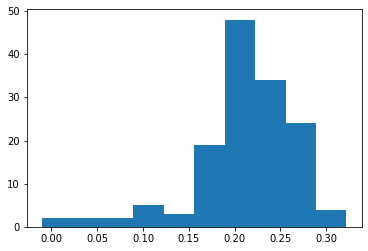

In [2]:
import numpy as np
import matplotlib.pyplot as plt


wpc_list = [0.19439563554728037, 0.27564258310989065, 0.25816783897908113, 0.26615550040433644, 0.24824854330353635, 0.20650074681449665, 0.1826130647504579, 0.20423829303780178, 0.18438662233482356, 0.2717427601704053, 0.2553406752757887, 0.3088493916531463, 0.18701073715731828, 0.20933426904370228, 0.19896603527760906, 0.2425778496250596, 0.020963556291426017, 0.2207091986699954, 0.11648497566878296, 0.27685166031501435, 0.23487185053675186, 0.28374809849936344, 0.20076319982750093, 0.21337030566274345, 0.1863133898323208, 0.2090619632875028, 0.1835767759089965, 0.18069713934336068, 0.2277997959433333, 0.2508233903319775, 0.2333743696762384, 0.19335199038042783, 0.23833796842439267, 0.25165744546243696, 0.19028670777123524, 0.32204811815002043, 0.2628635047680348, 0.19738386233563743, 0.09056585836106336, 0.29182403670066426, 0.19079811932161017, 0.20633768275061642, 0.1997636168034334, 0.16667890214891387, 0.1033773213705591, 0.19393911628844582, 0.2167217647131622, 0.21093974905196872, 0.1807022100594546, 0.07834956666583877, 0.26554176498439874, 0.2238665681037127, 0.1927603457877238, 0.25680909036261534, 0.1984136034287911, 0.2291157141150063, 0.2743328088907931, 0.1936644914480796, 0.18568194405190708, 0.1783459104642834, 0.25612490258391635, 0.2652002590205942, 0.19962650665251083, 0.21243744167711126, 0.23217713558775882, 0.19238776257534415, 0.13765464018893706, 0.12588104623172103, 0.21989945750141043, 0.21785597653654945, 0.23270700254424365, 0.22503046709299124, 0.2034238968201659, 0.06446098682872474, 0.2727406389587166, 0.1781898878292006, 0.25216215168184564, 0.16054970612743408, 0.2378374617927724, 0.2013158326522672, 0.22265117980475, 0.22294259483552167, 0.21477556794999947, 0.24262933280330648, 0.237046098883291, 0.23513396926448768, 0.23351145508035562, 0.2278971512929092, 0.277906061230563, 0.11032807114369847, 0.19319441834245146, 0.22611134144917894, 0.26282682743149816, 0.05115279412245032, 0.21676796144246252, 0.18156088647813443, 0.16639971532633868, -0.01010938701771652, 0.1601560640165417, 0.22406582285734883, 0.03619632672648529, 0.24874452722171705, 0.28449776580030073, 0.2526215581652612, 0.2792743345914591, 0.2366900152347597, 0.22035170211544197, 0.2662973410352046, 0.26920235514402135, 0.17436014953460674, 0.22507796658135557, 0.21163964071459562, 0.24911571105778235, 0.09979226804815515, 0.21677696976668095, 0.19616487641201516, 0.21279192076130582, 0.3068822048521647, 0.19669220793711698, 0.2076334733492423, 0.2185226015264071, 0.18693262307622577, 0.2132306429551405, 0.20822992629588732, 0.20396725204590224, 0.25109329313631823, 0.2621264565027239, 0.2725731429604007, 0.20274821749642455, 0.1834683247506879, 0.20054955854265633, 0.19021159604420848, 0.23263958715113423, 0.21330082517539956, 0.21304730054345392, 0.2720909763544588, 0.23722956325081862, 0.22356674651854272, 0.21491275869184331, 0.17207852460806103, 0.2578733836289361, 0.15365161720018092, 0.2588307819724219]

plt.hist(wpc_list)

In [1]:
print(5)

5
